# Trabalho Final

## Utilizando agrupamento nebuloso para analisar relação das vulnerabilidades demográficas e socioeconômicas dos municípios brasileiros com os efeitos da Covid-19

### Preparação dos dados 

In [1]:
import datetime
import pandas as pd
from scipy.stats import stats
from sklearn import preprocessing
import skfuzzy as fuzz
import skfuzzy.cluster as cluster
import skfuzzy.control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import os
from random import randrange
import unidecode
import seaborn as sns

#### Parâmetros gerais

In [2]:
data_maxima_considerada = datetime.datetime(year=2021, month=8, day=28)

#### Dados epidemiológicos - consolidado

In [223]:
directory_covid = os.fsencode('dados/covid')
df_covid = None
for file in os.listdir(directory_covid):
    filename = 'dados/covid/' + os.fsdecode(file)
    df_temp = pd.read_csv(filename, decimal=',', sep=';')
    if df_covid is None:
        df_covid = df_temp
    else:
        df_covid = pd.concat([df_covid, df_temp])

In [271]:
df_covid.data = pd.to_datetime(df_covid.data, infer_datetime_format=True)

In [227]:
df_covid[(df_covid.regiao == 'Brasil') & (df_covid.data == '2021-08-28')]

regiao estado municipio  coduf  codmun  codRegiaoSaude nomeRegiaoSaude  \
58  Brasil    NaN       NaN     76     NaN             NaN             NaN   

          data  semanaEpi  populacaoTCU2019  casosAcumulado  casosNovos  \
58  2021-08-28         34       210147125.0      20728605.0       24699   

    obitosAcumulado  obitosNovos  Recuperadosnovos  emAcompanhamentoNovos  \
58           579010          684        19646400.0               503195.0   

    interior/metropolitana  
58                     NaN

regiao estado municipio  coduf  codmun  codRegiaoSaude nomeRegiaoSaude  \
0    Brasil    NaN       NaN     76     NaN             NaN             NaN   
1    Brasil    NaN       NaN     76     NaN             NaN             NaN   
2    Brasil    NaN       NaN     76     NaN             NaN             NaN   
3    Brasil    NaN       NaN     76     NaN             NaN             NaN   
4    Brasil    NaN       NaN     76     NaN             NaN             NaN   
..      ...    ...       ...    ...     ...             ...             ...   
148  Brasil    NaN       NaN     76     NaN             NaN             NaN   
149  Brasil    NaN       NaN     76     NaN             NaN             NaN   
150  Brasil    NaN       NaN     76     NaN             NaN             NaN   
151  Brasil    NaN       NaN     76     NaN             NaN             NaN   
152  Brasil    NaN       NaN     76     NaN             NaN             NaN   

           data  semanaEpi  populacaoTCU2019  casosAcumulado  casosNovos  \
0    2020-02-25          9       210147125.0             0.0           0   
1    2020-02-26          9       210147125.0             1.0           1   
2    2020-02-27          9       210147125.0             1.0           0   
3    2020-02-28          9       210147125.0             1.0           0   
4    2020-02-29          9       210147125.0             2.0           1   
..          ...        ...               ...             ...         ...   
148  2020-12-27         53       210147125.0       7484285.0       18479   
149  2020-12-28         53       210147125.0       7504833.0       20548   
150  2020-12-29         53       210147125.0       7563551.0       58718   
151  2020-12-30         53       210147125.0       7619200.0       55649   
152  2020-12-31         53       210147125.0       7675973.0       56773   

     obitosAcumulado  obitosNovos  Recuperadosnovos  emAcompanhamentoNovos  \
0                  0            0               NaN                    NaN   
1                  0            0               NaN                    NaN   
2                  0            0               NaN                    NaN   
3                  0            0               NaN                    NaN   
4                  0            0               NaN                    NaN   
..               ...          ...               ...                    ...   
148           191139          344         6475466.0               799545.0   
149           191570          431         6515370.0               777776.0   
150           192681         1111         6568898.0               744365.0   
151           193875         1194         6647538.0               723332.0   
152           194949         1074         6707781.0               717544.0   

     interior/metropolitana  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
..                      ...  
148                     NaN  
149                     NaN  
150                     NaN  
151                     NaN  
152                     NaN  

[561 rows x 17 columns]

In [286]:
df_taxa_obitos = df_covid[(df_covid.codmun.isnull()) & (df_covid.regiao != 'Brasil') &
                          (df_covid.data <= '2021-08-28')]

regiao estado municipio  coduf  codmun  codRegiaoSaude  \
158          Norte     RO       NaN     11     NaN             NaN   
159          Norte     RO       NaN     11     NaN             NaN   
160          Norte     RO       NaN     11     NaN             NaN   
161          Norte     RO       NaN     11     NaN             NaN   
162          Norte     RO       NaN     11     NaN             NaN   
...            ...    ...       ...    ...     ...             ...   
4279  Centro-Oeste     DF       NaN     53     NaN             NaN   
4280  Centro-Oeste     DF       NaN     53     NaN             NaN   
4281  Centro-Oeste     DF       NaN     53     NaN             NaN   
4282  Centro-Oeste     DF       NaN     53     NaN             NaN   
4283  Centro-Oeste     DF       NaN     53     NaN             NaN   

     nomeRegiaoSaude       data  semanaEpi  populacaoTCU2019  casosAcumulado  \
158              NaN 2020-02-25          9         1777225.0             0.0   
159              NaN 2020-02-26          9         1777225.0             0.0   
160              NaN 2020-02-27          9         1777225.0             0.0   
161              NaN 2020-02-28          9         1777225.0             0.0   
162              NaN 2020-02-29          9         1777225.0             0.0   
...              ...        ...        ...               ...             ...   
4279             NaN 2020-12-27         53         3015268.0        248543.0   
4280             NaN 2020-12-28         53         3015268.0        249736.0   
4281             NaN 2020-12-29         53         3015268.0        250457.0   
4282             NaN 2020-12-30         53         3015268.0        251135.0   
4283             NaN 2020-12-31         53         3015268.0        251701.0   

      casosNovos  obitosAcumulado  obitosNovos  Recuperadosnovos  \
158            0                0            0               NaN   
159            0                0            0               NaN   
160            0                0            0               NaN   
161            0                0            0               NaN   
162            0                0            0               NaN   
...          ...              ...          ...               ...   
4279         615             4201            3               NaN   
4280        1193             4223           22               NaN   
4281         721             4241           18               NaN   
4282         678             4248            7               NaN   
4283         566             4259           11               NaN   

      emAcompanhamentoNovos  interior/metropolitana  
158                     NaN                     NaN  
159                     NaN                     NaN  
160                     NaN                     NaN  
161                     NaN                     NaN  
162                     NaN                     NaN  
...                     ...                     ...  
4279                    NaN                     NaN  
4280                    NaN                     NaN  
4281                    NaN                     NaN  
4282                    NaN                     NaN  
4283                    NaN                     NaN  

[14877 rows x 17 columns]

In [287]:
df_taxa_obitos = df_taxa_obitos.groupby(['regiao', 'data']).sum()[['obitosAcumulado', 'populacaoTCU2019']]
df_taxa_obitos['taxa_obitos'] = df_taxa_obitos.obitosAcumulado / df_taxa_obitos.populacaoTCU2019 * 100000
df_taxa_obitos = df_taxa_obitos.reset_index()
df_taxa_obitos

regiao       data  obitosAcumulado  populacaoTCU2019  taxa_obitos
0     Centro-Oeste 2020-02-25                0        16297074.0     0.000000
1     Centro-Oeste 2020-02-26                0        16297074.0     0.000000
2     Centro-Oeste 2020-02-27                0        16297074.0     0.000000
3     Centro-Oeste 2020-02-28                0        16297074.0     0.000000
4     Centro-Oeste 2020-02-29                0        16297074.0     0.000000
...            ...        ...              ...               ...          ...
2750           Sul 2021-08-24            89667        29975984.0   299.129463
2751           Sul 2021-08-25            89815        29975984.0   299.623192
2752           Sul 2021-08-26            89975        29975984.0   300.156952
2753           Sul 2021-08-27            90074        29975984.0   300.487217
2754           Sul 2021-08-28            90147        29975984.0   300.730745

[2755 rows x 5 columns]

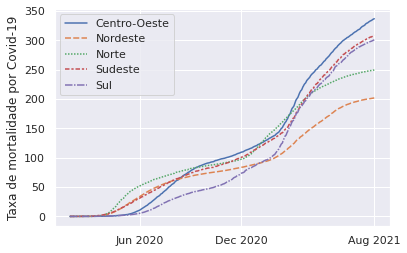

In [291]:
sns.set(font_scale=1)
fig, ax = plt.subplots()
handles, labels = ax.get_legend_handles_labels()
sns.lineplot(data=df_taxa_obitos, x="data", y="taxa_obitos", hue="regiao", style='regiao', markers=False)
ax.legend(handles=handles[1:], labels=labels[1:])
plt.ylabel('Taxa de mortalidade por Covid-19')
plt.xlabel(None)
datas_referencias = pd.Series([datetime.datetime(year=2020, month=6, day=30), datetime.datetime(year=2020, month=12, day=31),
                     datetime.datetime(year=2021, month=8, day=28)])
datas_referencias_str = datas_referencias.dt.strftime('%b %Y')
plt.xticks(datas_referencias, labels=datas_referencias_str)
plt.savefig('images/regiao_mortalidade.pdf', bbox_inches="tight")
plt.show()

In [ ]:
df_covid = df_covid[df_covid.municipio.isnull() == False]


df_covid = df_covid.rename(
    columns={'regiao': 'REGIAO', 'estado': 'SIGLA_ESTADO', 'municipio': 'MUNICIPIO', 'coduf': 'CODIGO_ESTADO',
             'codmun': 'CODIGO_MUNICIPIO_6', 'codRegiaoSaude': 'CODIGO_REGIAO_SAUDE', 'nomeRegiaoSaude': 'REGIAO_SAUDE',
             'casosAcumulado': 'CASOS', 'obitosAcumulado': 'OBITOS', 'interior/metropolitana': 'REGIAO_METROPOLITANA',
             'casosNovos': 'CASOS_NOVOS', 'obitosNovos': 'OBITOS_NOVOS', 'data': 'DATA', 'semanaEpi': 'SEMANA_EPIDEMIOLOGICA'})
df_covid.CODIGO_MUNICIPIO_6 = df_covid.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)

df_covid = df_covid[df_covid.DATA <= data_maxima_considerada]
df_covid_data_filtrada = df_covid[df_covid.DATA == data_maxima_considerada]

df_base = df_covid_data_filtrada[['MUNICIPIO', 'CODIGO_MUNICIPIO_6', 'SIGLA_ESTADO', 'CODIGO_ESTADO', 'REGIAO', 'REGIAO_SAUDE',
                    'CODIGO_REGIAO_SAUDE', 'REGIAO_METROPOLITANA', 'CASOS', 'OBITOS']]

#### Dados epidemiológicos - por semana epidemiológica

In [4]:
df_covid['ANO'] = df_covid.DATA.dt.year
df_covid_semana_epidemiologica = \
    df_covid.groupby(['MUNICIPIO','CODIGO_MUNICIPIO_6', 'ANO', 'SEMANA_EPIDEMIOLOGICA']).sum()['CASOS_NOVOS']
df_covid_semana_epidemiologica = df_covid_semana_epidemiologica.reset_index()

df_covid_2020_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2020) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2021) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_2021_53.drop(columns=['MUNICIPIO', 'ANO', 'SEMANA_EPIDEMIOLOGICA'])
df_covid_2021_53 = df_covid_2021_53.rename(columns={'CASOS_NOVOS': 'CASOS_NOVOS_2021'})

df_covid_2020_53 = pd.merge(df_covid_2020_53, df_covid_2021_53, how='left', on='CODIGO_MUNICIPIO_6')

df_covid_2020_53.CASOS_NOVOS = df_covid_2020_53.CASOS_NOVOS + df_covid_2020_53.CASOS_NOVOS_2021
df_covid_2020_53 = df_covid_2020_53.drop(columns=['CASOS_NOVOS_2021'])

df_covid_semana_epidemiologica = df_covid_semana_epidemiologica[df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA != 53]
df_covid_semana_epidemiologica = pd.concat([df_covid_semana_epidemiologica, df_covid_2020_53])

#### Nome dos estados

In [5]:
df_estados = pd.read_csv('dados/estados.csv', usecols=[1, 2])
df_estados.columns = ['ESTADO', 'SIGLA_ESTADO']
df_estados.SIGLA_ESTADO = df_estados.SIGLA_ESTADO.str.strip()
df_base = pd.merge(df_base, df_estados, how='left', on='SIGLA_ESTADO')

#### Aglomerados subnormais - Estimativa 2019

In [6]:
df_aglomerados_subnormais_estimativa = pd.read_excel('dados/IBGE/aglomerados_subnormais_estiamativa_2019.xls',
                                                     usecols=[1, 3, 4, 5, 8])
df_aglomerados_subnormais_estimativa.columns = \
    ['CODIGO_MUNICIPIO_7', 'POPULACAO_ESTIMADA', 'DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO',
     'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
     'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO']
df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais_estimativa['CODIGO_MUNICIPIO_6'] = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.str[0:6]
df_aglomerados_subnormais_estimativa = df_aglomerados_subnormais_estimativa.fillna(0)

df_base = pd.merge(df_base, df_aglomerados_subnormais_estimativa, how='left', on=['CODIGO_MUNICIPIO_6'])

#### Regiões imediatas e regiões intermediárias

In [7]:
df_regioes = pd.read_excel('dados/IBGE/regioes_geograficas_composicao_por_municipios_2017_20180911.ods',
                           usecols=[1, 2, 3, 4, 5])
df_regioes.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_REGIAO_IMEDIATA', 'REGIAO_IMEDIATA', 'CODIGO_REGIAO_INTERMEDIARIA', 'REGIAO_INTERMEDIARIA']
df_regioes.CODIGO_MUNICIPIO_7 = df_regioes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_base = pd.merge(df_base, df_regioes, how='left', on=['CODIGO_MUNICIPIO_7'])

#### Censo 2010 - Dados IBGE

##### Faixa etária

In [8]:
df_percentual_faixa_etaria = pd.read_csv('dados/IBGE/tab2_percentual_faixa_etaria.csv', sep=';', decimal=',')
df_percentual_faixa_etaria = df_percentual_faixa_etaria.dropna()
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.replace(" ", "_")
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.upper()
df_percentual_faixa_etaria.CODMUN7 = df_percentual_faixa_etaria.CODMUN7.astype('Int64').astype(str)
df_percentual_faixa_etaria = df_percentual_faixa_etaria[
    ['CODMUN7', '0_A_5_ANOS', '6_A_14_ANOS', '15_A_24_ANOS', '25_A_39_ANOS', '40_A_59_ANOS',
     '60_ANOS_OU_MAIS']]
df_percentual_faixa_etaria.columns = \
    ['CODIGO_MUNICIPIO_7', 'PERCENTUAL_POPULACAO_0_A_5_ANOS', 'PERCENTUAL_POPULACAO_6_A_14_ANOS',
     'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS', 'PERCENTUAL_POPULACAO_40_A_59_ANOS',
     'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS']
df_base = pd.merge(df_base, df_percentual_faixa_etaria, how="left", on=['CODIGO_MUNICIPIO_7'])

##### População sede municipal, área, densidade e domicílios

In [9]:
PATH_SINOPSE = 'dados/IBGE/SinopseEstados/'
directory_sinopse = os.fsencode(PATH_SINOPSE)
df_1_densidade = None
df_2_domicilios = None
for directory_state in os.listdir(directory_sinopse):
    directory_path = PATH_SINOPSE + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.startswith('tab2_1_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[3, 7, 8, 9],
                                 skiprows=10, skipfooter=1)
            df_temp.columns = ['POPULACAO_SEDE_MUNICIPAL', 'AREA', 'DENSIDADE', 'CODIGO_MUNICIPIO_7']
            if df_1_densidade is None:
                df_1_densidade = df_temp
            else:
                df_1_densidade = pd.concat([df_1_densidade, df_temp])

        if filename.startswith('tab2_2_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[2, 11],
                                 skiprows=10, skipfooter=2)
            df_temp.columns = ['DOMICILIOS_PARTICULARES_OCUPADOS', 'CODIGO_MUNICIPIO_7']
            if df_2_domicilios is None:
                df_2_domicilios = df_temp
            else:
                df_2_domicilios = pd.concat([df_2_domicilios, df_temp])
df_1_densidade.CODIGO_MUNICIPIO_7 = df_1_densidade.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_2_domicilios.CODIGO_MUNICIPIO_7 = df_2_domicilios.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_1_densidade, how = 'left', on=['CODIGO_MUNICIPIO_7'])
df_base = pd.merge(df_base, df_2_domicilios, how = 'left', on=['CODIGO_MUNICIPIO_7'])

##### Aglomerados subnormais - Censo 2010

In [10]:
df_aglomerados_subnormais = pd.read_excel('dados/IBGE/aglomerados_subnormais.xls', header=None,
                                          usecols=[1, 2, 3, 4, 5, 6, 7], skiprows=8, skipfooter=3)
df_aglomerados_subnormais.columns = \
    ['AGLOMERADOS', 'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS',
     'POPULACAO_AGLOMERADOS', 'AREA_AGLOMERADOS', 'DENSIDADE_DEMOGRAFICA_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_AGLOMERADOS','CODIGO_MUNICIPIO_7']
df_aglomerados_subnormais.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais = df_aglomerados_subnormais[df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.str.len() == 7]

df_base = pd.merge(df_base, df_aglomerados_subnormais, how='left', on=['CODIGO_MUNICIPIO_7'])

df_base.AGLOMERADOS = df_base.AGLOMERADOS.fillna(0)
df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS.fillna(0)
df_base.POPULACAO_AGLOMERADOS = df_base.POPULACAO_AGLOMERADOS.fillna(0)
df_base.AREA_AGLOMERADOS = df_base.AREA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS = df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS = df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS.fillna(0)

##### Atributos sistematizados pelo Atlas BR

In [11]:
df_censo = pd.read_csv('dados/AtlasBrasil/censo.csv', sep=';', decimal=',')
df_censo = df_censo[df_censo.ANO ==  2010]
df_censo.columns = df_censo.columns.str.upper()
df_censo = df_censo[['CODMUN7', 'IDHM','IDHM_E','IDHM_L','IDHM_R', 'FECTOT','CORTE1','CORTE2',
                    'CORTE3','CORTE4','CORTE9','GINI', 'PIND', 'PMPOB', 'PPOB', 'PREN10RICOS', 'PREN20','PREN20RICOS',
                    'PREN40','PREN60','PREN80', 'PRENTRAB','R1040','R2040', 'RDPC1','RDPC10','RDPC2','RDPC3','RDPC4',
                    'RDPC5','RIND','RMPOB','RPOB','THEIL', 'CPR','P_AGRO','P_COM','P_CONSTR','P_EXTR',
                    'P_FORMAL', 'P_SERV', 'P_SIUP', 'P_TRANSF', 'REN0','REN1','REN2','REN3','REN5', 'T_ATIV', 'T_DES',
                    'THEILTRAB', 'TRABPUB','T_BANAGUA', 'T_DENS', 'T_OCUPDESLOC_1', 'HOMEMTOT',
                     'MULHERTOT', 'PESO1', 'PESO13', 'PESO4', 'PESO5', 'PESO610',
                    'PESO1114', 'PESO1517', 'PESO18', 'PESO65', 'PESORUR','PESOTOT','PESOURB', 'RAZDEP', 'POP']]
df_censo = df_censo.rename(
    columns={'CODMUN7': 'CODIGO_MUNICIPIO_7', 'IDHM_E': 'IDHM_EDUCACAO','IDHM_L': 'IDHM_LONGEVIDADE','IDHM_R': 'IDHM_RENDA',
             'FECTOT': 'TAXA_FECUNDIDADE','CORTE1': 'RENDA_PER_CAPTA_MAXIMA_1_QUINTO_MAIS_POBRE',
             'CORTE2': 'RENDA_PER_CAPTA_MAXIMA_2_QUINTO_MAIS_POBRE', 'CORTE3': 'RENDA_PER_CAPTA_MAXIMA_3_QUINTO_MAIS_POBRE',
             'CORTE4': 'RENDA_PER_CAPTA_MAXIMA_4_QUINTO_MAIS_POBRE','CORTE9': 'RENDA_PER_CAPTA_MINIMA_10_PORCENTO_MAIS_RICOS',
             'PIND': 'PERCENTUAL_EXTREMAMENTE_POBRES', 'PMPOB': 'PERCENTUAL_POBRES', 'PPOB': 'PERCENTUAL_VULNERAVEIS_POBREZA',
             'PREN10RICOS': 'PERCENTUAL_RENDA_APROPRIADA_10_PORCENTO_MAIS_RICOS',
             'PREN20RICOS': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_RICOS',
             'PREN20': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_POBRES',
             'PREN40': 'PERCENTUAL_RENDA_APROPRIADA_40_PORCENTO_MAIS_POBRES',
             'PREN60': 'PERCENTUAL_RENDA_APROPRIADA_60_PORCENTO_MAIS_POBRES',
             'PREN80': 'PERCENTUAL_RENDA_APROPRIADA_80_PORCENTO_MAIS_POBRES',
             'PRENTRAB': 'PERCENTUAL_RENDA_PROVENIENTE_TRABALHO','R1040': 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'R2040': 'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'RDPC1': 'RENDA_PER_CAPTA_MEDIA_1_QUINTO_MAIS_POBRE', 'RDPC2': 'RENDA_PER_CAPTA_MEDIA_2_QUINTO_MAIS_POBRE',
             'RDPC3': 'RENDA_PER_CAPTA_MEDIA_3_QUINTO_MAIS_POBRE','RDPC4': 'RENDA_PER_CAPTA_MEDIA_4_QUINTO_MAIS_POBRE',
             'RDPC5': 'RENDA_PER_CAPTA_MEDIA_20_PORCENTO_MAIS_RICOS', 'RDPC10': 'RENDA_PER_CAPTA_MEDIA_10_PORCENTO_MAIS_RICOS',
             'RIND': 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES','RMPOB': 'RENDA_PER_CAPTA_MEDIA_POBRES',
             'RPOB': 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA','CPR': 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA',
             'P_AGRO': 'PERCENTUAL_OCUPADOS_AGROPECUARIA','P_COM': 'PERCENTUAL_OCUPADOS_COMERCIO','P_CONSTR': 'PERCENTUAL_OCUPADOS_CONSTRUCAO',
             'P_EXTR': 'PERCENTUAL_OCUPADOS_MINERACAO', 'P_FORMAL': 'PERCENTUAL_TRABALHADORES_FORMALIZADOS',
             'P_SERV': 'PERCENTUAL_OCUPADOS_SERVICO', 'P_SIUP': 'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA',
             'P_TRANSF': 'PERCENTUAL_OCUPADOS_INDUSTRIA', 'REN0': 'PERCENTUAL_OCUPADOS_SEM_RENDA',
             'REN1': 'PERCENTUAL_OCUPADOS_ATE_1_SALARIO_MINIMO','REN2': 'PERCENTUAL_OCUPADOS_ATE_2_SALARIOS_MINIMOS',
             'REN3': 'PERCENTUAL_OCUPADOS_ATE_3_SALARIOS_MINIMOS','REN5': 'PERCENTUAL_OCUPADOS_ATE_5_SALARIOS_MINIMOS',
             'T_ATIV': 'TAXA_ATIVIDADE', 'T_DES': 'TAXA_DESOCUPACAO', 'THEILTRAB': 'THEIL_TRABALHO', 'TRABPUB': 'PERCENTUAL_TRABALHADORES_PUBLICOS',
             'T_BANAGUA': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
             'T_DENS': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO',
             'T_OCUPDESLOC_1': 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
             'HOMEMTOT': 'POPULACAO_MASCULINA', 'MULHERTOT': 'POPULACAO_FEMININA', 'PESO1': 'POPULACAO_ATE_1_ANO',
             'PESO13': 'POPULACAO_1_A_3_ANOS', 'PESO4': 'POPULACAO_4_ANOS', 'PESO5': 'POPULACAO_5_ANOS',
             'PESO610': 'POPULACAO_6_A_10_ANOS', 'PESO1114': 'POPULACAO_11_A_14_ANOS', 'PESO1517': 'POPULACAO_15_A_17_ANOS',
             'PESO18': 'POPULACAO_18_ANOS_OU_MAIS', 'PESO65': 'POPULACAO_65_ANOS_OU_MAIS', 'PESORUR': 'POPULACAO_RURAL',
             'PESOTOT': 'POPULACAO_TOTAL','PESOURB': 'POPULACAO_URBANA', 'RAZDEP': 'RAZAO_DEPENDENCIA', 'POP': 'POPULACAO_DOMICILIOS_PARTICULARES'})
df_censo = df_censo.astype({'CODIGO_MUNICIPIO_7': str})

df_base = pd.merge(df_base, df_censo, how='left', on='CODIGO_MUNICIPIO_7')

#### Registros administrativos sistematizados pelo Atlas BR

In [12]:
df_registros_administrativos =  pd.read_csv('dados/AtlasBrasil/registros_administrativos.csv', decimal=',', sep=';')
df_registros_administrativos = df_registros_administrativos.astype({'IBGE7': str})

df_registros_administrativos_2017 = df_registros_administrativos[df_registros_administrativos.ANO == 2017]
df_registros_administrativos_2017 = df_registros_administrativos_2017[
    ['IBGE7','PINTERDRSAI', 'REN_TRPCBF_D', 'TXCOBPLP']]
df_registros_administrativos_2017 = df_registros_administrativos_2017.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'PINTERDRSAI': 'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO',
             'REN_TRPCBF_D': 'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'TXCOBPLP': 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'})
df_base = pd.merge(df_base, df_registros_administrativos_2017, how="left", on=['CODIGO_MUNICIPIO_7'])

df_registros_administrativos_2016 = df_registros_administrativos[df_registros_administrativos.ANO == 2016]
df_registros_administrativos_2016 = df_registros_administrativos_2016[
    ['IBGE7', 'REN_PVAADM', 'REN_PVAAGR', 'REN_PVAIND', 'REN_PVASERV']]
df_registros_administrativos_2016 = df_registros_administrativos_2016.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'REN_PVAADM': 'PERCENTUAL_VALOR_ADICIONADO_ADMINISTRACAO_PUBLICA',
             'REN_PVAAGR': 'PERCENTUAL_VALOR_ADICIONADO_AGRICULTURA', 'REN_PVAIND': 'PERCENTUAL_VALOR_ADICIONADO_INDUSTRIA',
             'REN_PVASERV': 'PERCENTUAL_VALOR_ADICIONADO_SERVICO'})
df_base = pd.merge(df_base, df_registros_administrativos_2016, how="left", on=['CODIGO_MUNICIPIO_7'])


##### Tratamento de dados ausentes em PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE

In [13]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').mean()[['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE']]
df_group_regiao_imediata.columns = ['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')
df_base.loc[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull(), 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'] = \
    df_base[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull()].PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA
df_base = df_base.drop(columns=['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA'])

#### Eleições 2018

In [14]:
PATH_ELEICOES = 'dados/Eleicao2018/'
directory_eleicoes = os.fsencode(PATH_ELEICOES)
df_eleicoes = None
for directory_state in os.listdir(directory_eleicoes):
    directory_path = PATH_ELEICOES + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.endswith('.csv'):
            relative_filename = directory_path + '/' + filename
            df_eleicoes_temp = pd.read_csv(relative_filename, encoding='Latin 1', sep=';')
            df_eleicoes_temp = df_eleicoes_temp[df_eleicoes_temp.DS_CARGO_PERGUNTA == 'Presidente']
            df_eleicoes_temp = df_eleicoes_temp.groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NM_VOTAVEL']).sum()
            df_eleicoes_temp = df_eleicoes_temp[['QT_VOTOS']]
            df_eleicoes_branco = df_eleicoes_temp.loc[(slice(None), slice(None), 'Branco')]
            df_eleicoes_branco.columns = ['VOTOS_BRANCO']
            df_eleicoes_nulo = df_eleicoes_temp.loc[(slice(None), slice(None), 'Nulo')]
            df_eleicoes_nulo.columns = ['VOTOS_NULO']
            df_eleicoes_bolsonaro = df_eleicoes_temp.loc[(slice(None), slice(None), 'JAIR BOLSONARO')]
            df_eleicoes_bolsonaro.columns = ['VOTOS_BOLSONARO']
            df_eleicoes_haddad = df_eleicoes_temp.loc[(slice(None), slice(None), 'FERNANDO HADDAD')]
            df_eleicoes_haddad.columns = ['VOTOS_HADDAD']
            df_eleicoes_temp = pd.merge(df_eleicoes_bolsonaro, df_eleicoes_haddad, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_branco, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_nulo, left_index=True, right_index=True)
            df_eleicoes_temp = df_eleicoes_temp.reset_index(level=['CD_MUNICIPIO', 'NM_MUNICIPIO'])
            if df_eleicoes is None:
                df_eleicoes = df_eleicoes_temp
            else:
                df_eleicoes = pd.concat([df_eleicoes, df_eleicoes_temp])

df_eleicoes = df_eleicoes.drop(columns=['NM_MUNICIPIO'])
df_eleicoes = df_eleicoes.rename(columns={'CD_MUNICIPIO': 'CODIGO_MUNICIPIO_TSE'})
df_codigos_tse_ibge = pd.read_csv('dados/municipios_brasileiros_tse.csv', usecols=[0, 3, 4])
df_codigos_tse_ibge.columns = ['CODIGO_MUNICIPIO_TSE', 'CAPITAL', 'CODIGO_MUNICIPIO_7']
df_eleicoes = pd.merge(df_eleicoes, df_codigos_tse_ibge, how="left", on=['CODIGO_MUNICIPIO_TSE'])
df_eleicoes.CODIGO_MUNICIPIO_7 = df_eleicoes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_eleicoes, how='left', on=['CODIGO_MUNICIPIO_7'])

/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27,30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Dados da saúde

##### Cobertura da Estratégia de Saúde da Família

In [15]:
df_cobertura_estrategia_saude_familia = pd.read_excel('dados/saude/Cobertura-AB-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 12], skiprows=9, skipfooter=6)
df_cobertura_estrategia_saude_familia.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA']
df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6 = df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace("%","")
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace(",",".")
df_cobertura_estrategia_saude_familia = df_cobertura_estrategia_saude_familia.astype({'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA': float})

df_base = pd.merge(df_base, df_cobertura_estrategia_saude_familia, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Cobertura dos Agentes Comunitários de Saúde

In [16]:
df_cobertura_agentes_saude = pd.read_excel('dados/saude/Cobertura-ACS-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 8], skiprows=9, skipfooter=6)
df_cobertura_agentes_saude.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE']
df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6 = df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace("%","")
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace(",",".")
df_cobertura_agentes_saude = df_cobertura_agentes_saude.astype({'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE': float})

df_base = pd.merge(df_base, df_cobertura_agentes_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Enfermeiros

In [17]:
df_enfermeiros = pd.read_csv('dados/saude/enfermeiros_2019_12.csv', sep=';', decimal=',')
df_enfermeiros.columns = ['MUNICIPIO', 'ENFERMEIROS_SUS_2019_12', 'ENFERMEIROS_NAO_SUS_2019_12', 'ENFERMEIROS_TOTAL_2019_12']
df_enfermeiros =  df_enfermeiros.replace("-", 0)
df_enfermeiros['CODIGO_MUNICIPIO_6'] = df_enfermeiros.MUNICIPIO.str[:6]
df_enfermeiros = df_enfermeiros.astype({'ENFERMEIROS_SUS_2019_12': int, 'ENFERMEIROS_NAO_SUS_2019_12': int, 'ENFERMEIROS_TOTAL_2019_12': int})
df_enfermeiros = df_enfermeiros.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_enfermeiros, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Médicos

In [18]:
df_medicos = pd.read_csv('dados/saude/medicos_2019_12.csv', sep=';', decimal=',')
df_medicos.columns = ['MUNICIPIO', 'MEDICOS_SUS_2019_12', 'MEDICOS_NAO_SUS_2019_12', 'MEDICOS_TOTAL_2019_12']
df_medicos =  df_medicos.replace("-", 0)
df_medicos['CODIGO_MUNICIPIO_6'] = df_medicos.MUNICIPIO.str[:6]
df_medicos = df_medicos.astype({'MEDICOS_SUS_2019_12': int, 'MEDICOS_NAO_SUS_2019_12': int, 'MEDICOS_TOTAL_2019_12': int})
df_medicos = df_medicos.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_medicos, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS INTERNAÇÃO

In [19]:
df_leitos_internacao = pd.read_csv('dados/saude/leitos_internacao_2019_12.csv', sep=';', decimal=',')
df_leitos_internacao.columns = ['MUNICIPIO', 'LEITOS_INTERNACAO_SUS_2019_12', 'LEITOS_INTERNACAO_NAO_SUS_2019_12', 'LEITOS_INTERNACAO_TOTAL_2019_12']
df_leitos_internacao =  df_leitos_internacao.replace("-", 0)
df_leitos_internacao['CODIGO_MUNICIPIO_6'] = df_leitos_internacao.MUNICIPIO.str[:6]
df_leitos_internacao = df_leitos_internacao.astype({'LEITOS_INTERNACAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_NAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_TOTAL_2019_12': int})
df_leitos_internacao = df_leitos_internacao.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_internacao, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS UTI

In [20]:
df_leitos_uti = pd.read_csv('dados/saude/leitos_uti_2019_12.csv', sep=';', decimal=',')
df_leitos_uti.columns = ['MUNICIPIO', 'LEITOS_UTI_SUS_2019_12', 'LEITOS_UTI_NAO_SUS_2019_12', 'LEITOS_UTI_TOTAL_2019_12']
df_leitos_uti =  df_leitos_uti.replace("-", 0)
df_leitos_uti['CODIGO_MUNICIPIO_6'] = df_leitos_uti.MUNICIPIO.str[:6]
df_leitos_uti = df_leitos_uti.astype({'LEITOS_UTI_SUS_2019_12': int, 'LEITOS_UTI_NAO_SUS_2019_12': int, 'LEITOS_UTI_TOTAL_2019_12': int})
df_leitos_uti = df_leitos_uti.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_uti, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Ventiladores/Respiradores

In [21]:
df_ventiladores_respiradores = pd.read_csv('dados/saude/ventiladores_respiradores_2019_12.csv',
                                           sep=';', decimal=',', usecols=[0, 1, 2])
df_ventiladores_respiradores.columns = ['MUNICIPIO', 'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']
df_ventiladores_respiradores =  df_ventiladores_respiradores.replace("-", 0)
df_ventiladores_respiradores['CODIGO_MUNICIPIO_6'] = df_ventiladores_respiradores.MUNICIPIO.str[:6]
df_ventiladores_respiradores = df_ventiladores_respiradores.astype({'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12': int,
                                                                    'VENTILADORES_RESPIRADORES_EM_USO_2019_12': int})
df_ventiladores_respiradores = df_ventiladores_respiradores.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_ventiladores_respiradores, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Merge df_base and df_group_regiao_imediata

In [22]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_imediata.columns = ['POPULACAO_ESTIMADA_REGIAO_IMEDIATA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA', 'MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')

##### Merge df_base and df_group_regiao_intermediaria

In [23]:
df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_intermediaria.columns = ['POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA']
df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

##### Enfermeiros, médicos, leitos de internação, leitos UTI, leitos UTI Covid e ventiladores pulmonares durante os anos 2020 e 2021

In [24]:
PATH_SAUDE = 'dados/saude/'
directory_saude = os.fsencode(PATH_SAUDE)
for file in os.listdir(directory_saude):
    filename = os.fsdecode(file)

    if filename.endswith('_2020_2021.csv'):
        relative_filename = PATH_SAUDE + filename
        item = filename.replace('_2020_2021.csv', '').upper()
        df_saude = pd.read_csv(relative_filename, sep=';', decimal=',')
        column1 = item+'_2020_06'
        column2 = item+'_2020_12'
        column3 = item+'_2021_06'
        df_saude.columns = ['CODIGO_MUNICIPIO_6', column1, column2, column3]
        df_saude =  df_saude.replace("-", 0)
        df_saude['CODIGO_MUNICIPIO_6'] = df_saude.CODIGO_MUNICIPIO_6.str[:6]
        df_saude = df_saude.astype({column1: int, column2: int, column3: int})
        df_base = pd.merge(df_base, df_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

        df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[[column1, column2, column3]]
        column1_regiao_intermediaria = column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria = column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria = column3 + '_REGIAO_INTERMEDIARIA'
        df_group_regiao_intermediaria.columns = [column1_regiao_intermediaria, column2_regiao_intermediaria,
                                                 column3_regiao_intermediaria]
        df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
        df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

        column1_regiao_intermediaria_taxa = 'TAXA_' + column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria_taxa = 'TAXA_' + column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria_taxa = 'TAXA_' + column3 + '_REGIAO_INTERMEDIARIA'
        df_base[column1_regiao_intermediaria_taxa] = df_base[column1_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column2_regiao_intermediaria_taxa] = df_base[column2_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column3_regiao_intermediaria_taxa] = df_base[column3_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000

#### Doenças de risco à Covid-19

In [25]:
# directory_disease_path = 'dados/pesquisa_nacional_saude/'
# directory_disease = os.fsencode(directory_disease_path)
# for file in os.listdir(directory_disease):
#     file_single_name = os.fsdecode(file)
#     filename = directory_disease_path + file_single_name
#     disease_name = file_single_name[:-4].upper()
#
#     column_percentual = 'PERCENTUAL_' + disease_name
#
#     df_capital_disease = pd.read_excel(filename, sheet_name=2, header=None, usecols=[0, 1], skiprows=11, skipfooter=3)
#     df_capital_disease.columns = ['MUNICIPIO', column_percentual]
#     df_capital_disease['CAPITAL'] = 1
#     df_base = pd.merge(df_base, df_capital_disease, how='left', on=['MUNICIPIO', 'CAPITAL'])

directory_disease_path = 'dados/pesquisa_nacional_saude/'
directory_disease = os.fsencode(directory_disease_path)
for file in os.listdir(directory_disease):
    file_single_name = os.fsdecode(file)
    filename = directory_disease_path + file_single_name
    disease_name = file_single_name[:-4].upper()

    df_disease = pd.read_excel(filename, header=None, usecols=[0, 1], skiprows=13, skipfooter=2)
    column_percentual = 'PERCENTUAL_' + disease_name
    df_disease.columns = ['ESTADO', column_percentual]
    df_base = pd.merge(df_base, df_disease, how='left', on='ESTADO')

    df_capital_disease = pd.read_excel(filename, sheet_name=2, header=None, usecols=[0, 1], skiprows=11, skipfooter=3)
    column_percentual_capital = 'PERCENTUAL_' + disease_name + '_CAPITAL'
    df_capital_disease.columns = ['MUNICIPIO', column_percentual_capital]
    df_capital_disease['CAPITAL'] = 1
    df_base = pd.merge(df_base, df_capital_disease, how='left', on=['MUNICIPIO', 'CAPITAL'])
    df_base.loc[df_base[column_percentual_capital].isnull() == False, column_percentual] = \
        df_base[df_base[column_percentual_capital].isnull() == False][column_percentual_capital]
    df_base = df_base.drop(columns=[column_percentual_capital])

#### Hierarquia urbana

In [26]:
df_arranjo_populacional = \
    pd.read_excel('dados/hierarquia_urbana/REGIC2018_Arranjos_Populacionais_v2.xlsx', usecols=[0, 2, 3])
df_arranjo_populacional.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_ARRANJO_POPULACIONAL','ARRANJO_POPULACIONAL']
df_arranjo_populacional.CODIGO_MUNICIPIO_7 = df_arranjo_populacional.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL = df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_arranjo_populacional, how='left', on='CODIGO_MUNICIPIO_7')

df_base['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = df_base.CODIGO_MUNICIPIO_7
df_base.loc[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False, 'CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = \
    df_base[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False].CODIGO_ARRANJO_POPULACIONAL

df_hierarquia_urbana = pd.read_excel('dados/hierarquia_urbana/REGIC2018_Cidades_v2.xlsx', usecols=[2, 12, 13])
df_hierarquia_urbana.columns = ['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7', 'NIVEL_HIERARQUIA_URBANA', 'HIERARQUIA_URBANA']
df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7 = \
    df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_hierarquia_urbana, how='left', on='CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7')

df_base['NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 0
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 11
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 10
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 9
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 8
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 7
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 6
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 5
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 4
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 3
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 2
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '5', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 1

#### Mobilidade (Google)

In [27]:
directory_mobility_path = 'dados/GoogleMobilidade/'
directory_mobility = os.fsencode(directory_mobility_path)
df_mobilidade = None
for file in os.listdir(directory_mobility):
    filename = directory_mobility_path + os.fsdecode(file)
    df_temp = pd.read_csv(filename, usecols=[2, 3, 8, 12, 13, 14])
    if df_mobilidade is None:
        df_mobilidade = df_temp
    else:
        df_mobilidade = pd.concat([df_mobilidade, df_temp])

df_mobilidade.columns = ['ESTADO', 'MUNICIPIO', 'DATA', 'PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                         'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_mobilidade = df_mobilidade[(df_mobilidade.ESTADO == "Federal District") | (df_mobilidade.MUNICIPIO.isnull() == False)].copy()
df_mobilidade.ESTADO = df_mobilidade.ESTADO.str.replace('State of ', '')
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "MUNICIPIO"] = 'Brasília'
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "ESTADO"] = 'Distrito Federal'
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df_municipio = df_base[['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']].copy()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

estados_sem_acento = df_estados.ESTADO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
for estado in estados_sem_acento:
    palavra_pesquisa = ', ' + estado
    df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.replace(palavra_pesquisa, '')

df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Poxoreo', 'MUNICIPIO'] = 'Poxoreu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Brasopolis', 'MUNICIPIO'] = 'Brazopolis'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Thome das Letras', 'MUNICIPIO'] = 'Sao Tome das Letras'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Eldorado dos Carajas', 'MUNICIPIO'] = 'Eldorado do Carajas'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Santa Isabel do Para', 'MUNICIPIO'] = 'Santa Izabel do Para'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Itamaraca', 'MUNICIPIO'] = 'Ilha de Itamaraca'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Caetano', 'MUNICIPIO'] = 'Sao Caitano'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Assu', 'MUNICIPIO'] = 'Acu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.upper()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.upper()
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "PICARRAS", 'MUNICIPIO'] = "BALNEARIO PICARRAS"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "BIRITIBA-MIRIM", 'MUNICIPIO'] = "BIRITIBA MIRIM"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "EMBU", 'MUNICIPIO'] = "EMBU DAS ARTES"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "MOJI-MIRIM", 'MUNICIPIO'] = "MOGI MIRIM"

df_mobilidade = pd.merge(df_mobilidade, df_municipio, how='left', on=['ESTADO', 'MUNICIPIO'])

SABADO = 5
DOMINGO = 6
df_mobilidade.DATA = pd.to_datetime(df_mobilidade.DATA, infer_datetime_format=True)
df_mobilidade = df_mobilidade[df_mobilidade.DATA <= data_maxima_considerada]
df_mobilidade = df_mobilidade[(df_mobilidade.DATA.dt.weekday != SABADO) & (df_mobilidade.DATA.dt.weekday != DOMINGO)]

##### Agrupa dados de mobilidade e número de casos no mesmo intervalo de semanas epidemiológicas

In [28]:
df_mobilidade_semana_epidemiologica = None
df_covid_semana_epidemiologica_agrupada = None
NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR = 1
SEMANA_EPIDEMIOLOGICA_INICIAL = 14
data_inicio_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=29)
data_fim_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=28)
semana_epidemiologica = SEMANA_EPIDEMIOLOGICA_INICIAL
while(data_inicio_semana_epidemiologica < data_maxima_considerada):
    ano_inicio_semana_epidemiologica = data_inicio_semana_epidemiologica.year
    data_fim_semana_epidemiologica += datetime.timedelta(days= 7 * NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR)

    df_temp = df_mobilidade[(df_mobilidade.DATA >= data_inicio_semana_epidemiologica) & (df_mobilidade.DATA <= data_fim_semana_epidemiologica)]
    df_temp = df_temp.groupby(['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']).mean()
    ano_semana_epidemiologica_inicio_definitivo = ano_inicio_semana_epidemiologica
    semana_epidemiologica_inicio_definitivo = semana_epidemiologica


    for i in range(NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR):
        data_inicio_semana_epidemiologica += datetime.timedelta(days= 7)
        ano_inicio_proxima_semana_epidemiologica = data_inicio_semana_epidemiologica.year
        if ano_inicio_semana_epidemiologica != ano_inicio_proxima_semana_epidemiologica:
            ultima_semana_epidemiologica_ano = semana_epidemiologica
            semana_epidemiologica = 1
            ano_inicio_semana_epidemiologica = ano_inicio_proxima_semana_epidemiologica
        else:
            semana_epidemiologica += 1

    if semana_epidemiologica > 1:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica
        semana_epidemiologica_fim_definitivo = semana_epidemiologica - 1
    else:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica - 1
        semana_epidemiologica_fim_definitivo = ultima_semana_epidemiologica_ano

    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo

    if df_mobilidade_semana_epidemiologica is None:
        df_mobilidade_semana_epidemiologica = df_temp
    else:
        df_mobilidade_semana_epidemiologica = pd.concat([df_mobilidade_semana_epidemiologica, df_temp])

    if ano_semana_epidemiologica_inicio_definitivo != ano_semana_epidemiologica_fim_definitivo:
        df_temp_covid = df_covid_semana_epidemiologica[
            ((df_covid_semana_epidemiologica.ANO >= ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo)) |
            ((df_covid_semana_epidemiologica.ANO <= ano_semana_epidemiologica_fim_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo))]
    else:
        df_temp_covid = df_covid_semana_epidemiologica[
            (df_covid_semana_epidemiologica.ANO == ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo)]

    df_temp_covid = df_temp_covid.groupby('CODIGO_MUNICIPIO_6').sum()[['CASOS_NOVOS']]
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo
    if df_covid_semana_epidemiologica_agrupada is None:
        df_covid_semana_epidemiologica_agrupada = df_temp_covid
    else:
        df_covid_semana_epidemiologica_agrupada = pd.concat([df_covid_semana_epidemiologica_agrupada, df_temp_covid])

df_mobilidade_semana_epidemiologica = df_mobilidade_semana_epidemiologica.reset_index()
df_covid_semana_epidemiologica_agrupada = df_covid_semana_epidemiologica_agrupada.reset_index()

df_municipio_populacao_estimada = df_base[['CODIGO_MUNICIPIO_6', 'POPULACAO_ESTIMADA']]
df_covid_semana_epidemiologica_agrupada = pd.merge(df_covid_semana_epidemiologica_agrupada,
                                                   df_municipio_populacao_estimada, how='left', on='CODIGO_MUNICIPIO_6')
df_covid_semana_epidemiologica_agrupada['TAXA_CASOS_NOVOS'] = df_covid_semana_epidemiologica_agrupada.CASOS_NOVOS / df_covid_semana_epidemiologica_agrupada.POPULACAO_ESTIMADA * 100000

In [29]:
df_mobilidade_trabalho_semana_epidemiologica = \
    df_mobilidade_semana_epidemiologica[df_mobilidade_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.isnull() == False][
        ['CODIGO_MUNICIPIO_6', 'MUNICIPIO', 'ESTADO', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
         'ANO_SEMANA_EPIDEMIOLOGICA_INICIO', 'SEMANA_EPIDEMIOLOGICA_INICIO', 'ANO_SEMANA_EPIDEMIOLOGICA_FIM',
         'SEMANA_EPIDEMIOLOGICA_FIM']]
df_mobilidade_trabalho_covid_semana_epidemiologica = pd.merge(
    df_mobilidade_trabalho_semana_epidemiologica, df_covid_semana_epidemiologica_agrupada, how='left',
    on=['CODIGO_MUNICIPIO_6', 'ANO_SEMANA_EPIDEMIOLOGICA_INICIO', 'SEMANA_EPIDEMIOLOGICA_INICIO', 'ANO_SEMANA_EPIDEMIOLOGICA_FIM',
         'SEMANA_EPIDEMIOLOGICA_FIM'])
df_mobilidade_trabalho_covid_semana_epidemiologica.loc[df_mobilidade_trabalho_covid_semana_epidemiologica.CASOS_NOVOS < 0, 'CASOS_NOVOS'] = None
df_mobilidade_trabalho_covid_semana_epidemiologica.loc[df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS < 0, 'TAXA_CASOS_NOVOS'] = None
df_mobilidade_trabalho_covid_semana_epidemiologica = \
    df_mobilidade_trabalho_covid_semana_epidemiologica[df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.isnull() == False]

In [30]:
df_mobilidade_media = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').mean()[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_media = df_mobilidade_media.reset_index()
df_mobilidade_media.columns = ['CODIGO_MUNICIPIO_6', 'MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_media, how='left', on='CODIGO_MUNICIPIO_6')


df_mobilidade_mediana = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').median()[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_mediana = df_mobilidade_mediana.reset_index()
df_mobilidade_mediana.columns = ['CODIGO_MUNICIPIO_6', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_mediana, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_3_quartile = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').quantile(0.75)[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_3_quartile = df_mobilidade_3_quartile.reset_index()
df_mobilidade_3_quartile.columns = ['CODIGO_MUNICIPIO_6', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_3_quartile, how='left', on='CODIGO_MUNICIPIO_6')

In [31]:
df_municipios_mobilidade = df_mobilidade_semana_epidemiologica.groupby(['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']).count()
df_municipios_mobilidade = df_municipios_mobilidade.reset_index()
df_municipios_mobilidade = df_municipios_mobilidade[['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']]
df_municipios_mobilidade

MUNICIPIO          ESTADO CODIGO_MUNICIPIO_6 CODIGO_MUNICIPIO_7
0     ABADIA DE GOIAS           Goiás             520005            5200050
1           ABADIANIA           Goiás             520010            5200100
2              ABAETE    Minas Gerais             310020            3100203
3          ABAETETUBA            Pará             150010            1500107
4        ABELARDO LUZ  Santa Catarina             420010            4200101
...               ...             ...                ...                ...
2303          XANXERE  Santa Catarina             421950            4219507
2304            XAXIM  Santa Catarina             421970            4219705
2305         XINGUARA            Pará             150840            1508407
2306      XIQUE-XIQUE           Bahia             293360            2933604
2307          ZE DOCA        Maranhão             211400            2114007

[2308 rows x 4 columns]

/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


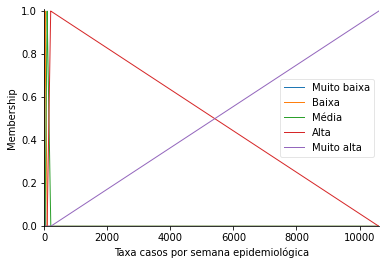

In [32]:
x_taxa_casos = np.arange(df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
                         df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max(), 0.1)
antecedent_taxa_casos = ctrl.Antecedent(x_taxa_casos, "Taxa casos por semana epidemiológica")
antecedent_taxa_casos['Muito baixa'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25)])
antecedent_taxa_casos['Baixa'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median()])
antecedent_taxa_casos['Média'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75)])
antecedent_taxa_casos['Alta'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max()])
antecedent_taxa_casos['Muito alta'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max()])
antecedent_taxa_casos.view()

/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


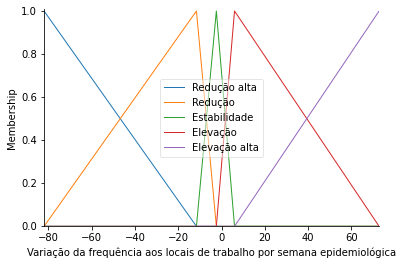

In [33]:
x_variacao_trabalho = np.arange(df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
                         df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max(), 0.1)
antecedent_variacao_trabalho = ctrl.Antecedent(x_variacao_trabalho, "Variação da frequência aos locais de trabalho por semana epidemiológica")
antecedent_variacao_trabalho['Redução alta'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25)])
antecedent_variacao_trabalho['Redução'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median()])
antecedent_variacao_trabalho['Estabilidade'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75)])
antecedent_variacao_trabalho['Elevação'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max()])
antecedent_variacao_trabalho['Elevação alta'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max()])
antecedent_variacao_trabalho.view()

/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


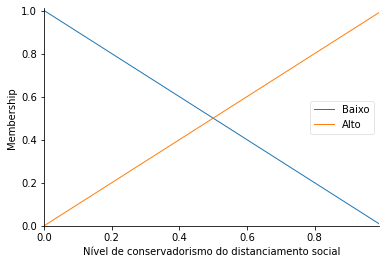

In [34]:
consequent_nivel_conservadorismo_resposta = ctrl.Consequent(np.arange(0, 1, 0.01), "Nível de conservadorismo do distanciamento social")
consequent_nivel_conservadorismo_resposta['Baixo'] = fuzz.trimf(consequent_nivel_conservadorismo_resposta.universe, [0, 0, 1])
consequent_nivel_conservadorismo_resposta['Alto'] = fuzz.trimf(consequent_nivel_conservadorismo_resposta.universe, [0, 1, 1])
consequent_nivel_conservadorismo_resposta.view()

In [35]:
regra_1 = ctrl.Rule(
    (antecedent_taxa_casos['Muito alta'] & antecedent_variacao_trabalho['Redução alta']),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_2 = ctrl.Rule(
    (antecedent_taxa_casos['Alta'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_3 = ctrl.Rule(
    (antecedent_taxa_casos['Média'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_4 = ctrl.Rule(
    (antecedent_taxa_casos['Baixa'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_5 = ctrl.Rule(
    (antecedent_taxa_casos['Muito baixa'] & (
            antecedent_variacao_trabalho['Elevação'] |
            antecedent_variacao_trabalho['Estabilidade'] |
            antecedent_variacao_trabalho['Redução'] |
            antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_6 = ctrl.Rule(
    (antecedent_taxa_casos['Muito alta'] & (antecedent_variacao_trabalho['Redução'] |
                                            antecedent_variacao_trabalho['Estabilidade'] |
                                            antecedent_variacao_trabalho['Elevação'] |
                                            antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_7 = ctrl.Rule(
    (antecedent_taxa_casos['Alta'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                            antecedent_variacao_trabalho['Elevação'] |
                                            antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_8 = ctrl.Rule(
    (antecedent_taxa_casos['Média'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                       antecedent_variacao_trabalho['Elevação'] |
                                       antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_9 = ctrl.Rule(
    (antecedent_taxa_casos['Baixa'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                       antecedent_variacao_trabalho['Elevação'] |
                                       antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_10 = ctrl.Rule(
    (antecedent_taxa_casos['Muito baixa'] & antecedent_variacao_trabalho['Elevação alta']),
    consequent_nivel_conservadorismo_resposta['Alto'])

control_system = ctrl.ControlSystem(
    rules = [regra_1, regra_2, regra_3, regra_4, regra_5, regra_6, regra_7, regra_8, regra_9, regra_10])
simulation = ctrl.ControlSystemSimulation(control_system)

In [36]:
# df_mobilidade_trabalho_covid_semana_epidemiologica['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = None
# for index, row in df_mobilidade_trabalho_covid_semana_epidemiologica.iterrows():
#     simulation.input["Taxa casos por semana epidemiológica"] = row['TAXA_CASOS_NOVOS']
#     simulation.input["Variação da frequência aos locais de trabalho por semana epidemiológica"] = row['PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO']
#     simulation.compute()
#     df_mobilidade_trabalho_covid_semana_epidemiologica.loc[index, 'INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = \
#         simulation.output['Nível de conservadorismo do distanciamento social']
#
# df_mobilidade_trabalho_covid_semana_epidemiologica['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = \
#     df_mobilidade_trabalho_covid_semana_epidemiologica.INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO.astype(float)
#
# df_mobilidade_trabalho_covid_semana_epidemiologica.to_csv('dados/df_mobilidade_trabalho_covid_semana_epidemiologica.csv', index=False)

In [37]:
df_mobilidade_trabalho_covid_semana_epidemiologica = pd.read_csv('dados/df_mobilidade_trabalho_covid_semana_epidemiologica.csv')
df_mobilidade_trabalho_covid_semana_epidemiologica.CODIGO_MUNICIPIO_6 = \
    df_mobilidade_trabalho_covid_semana_epidemiologica.CODIGO_MUNICIPIO_6.astype(int).astype(str)

In [38]:
df_mobilidade_trabalho_covid_media = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').mean()[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_media = df_mobilidade_trabalho_covid_media.reset_index()
df_mobilidade_trabalho_covid_media.columns = ['CODIGO_MUNICIPIO_6', 'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_media, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_trabalho_covid_mediana = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').median()[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_mediana = df_mobilidade_trabalho_covid_mediana.reset_index()
df_mobilidade_trabalho_covid_mediana.columns = ['CODIGO_MUNICIPIO_6', 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_mediana, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_trabalho_covid_3_quartile = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').quantile(0.75)[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_3_quartile = df_mobilidade_trabalho_covid_3_quartile.reset_index()
df_mobilidade_trabalho_covid_3_quartile.columns = ['CODIGO_MUNICIPIO_6', 'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_3_quartile, how='left', on='CODIGO_MUNICIPIO_6')

#### Creating new attributes

In [39]:
df_base['TAXA_CASOS'] = df_base.CASOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_OBITOS'] = df_base.OBITOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LETALIDADE'] = df_base.OBITOS / df_base.CASOS * 100
df_base['RAZAO_POPULACAO_MASCULINA_FEMININA'] = df_base.POPULACAO_MASCULINA / df_base.POPULACAO_FEMININA
df_base['RAZAO_POPULACAO_RURAL_URBANA'] = df_base.POPULACAO_RURAL / df_base.POPULACAO_URBANA
df_base['PERCENTUAL_POPULACAO_URBANA'] = df_base.POPULACAO_URBANA / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_SEDE_MUNICIPAL'] = df_base.POPULACAO_SEDE_MUNICIPAL / df_base.POPULACAO_TOTAL * 100
df_base['RAZAO_POPULCAO_DOMICILIOS_ESTIMADA'] = df_base.POPULACAO_ESTIMADA / df_base.DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO
df_base['PERCENTUAL_POPULACAO_17_ANOS_OU_MENOS'] = \
    (df_base.POPULACAO_ATE_1_ANO + df_base.POPULACAO_1_A_3_ANOS + df_base.POPULACAO_4_ANOS + df_base.POPULACAO_5_ANOS +
     df_base.POPULACAO_6_A_10_ANOS + df_base.POPULACAO_11_A_14_ANOS + df_base.POPULACAO_15_A_17_ANOS) / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_18_ATE_39_ANOS'] = (df_base.POPULACAO_18_ANOS_OU_MAIS / df_base.POPULACAO_TOTAL * 100) - df_base.PERCENTUAL_POPULACAO_40_A_59_ANOS - df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS
df_base['DENSIDADE_DOMICILIOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS / df_base.AREA
df_base['PERCENTUAL_DOMICILIOS_AGLOMERADOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS / df_base.DOMICILIOS_PARTICULARES_OCUPADOS * 100
df_base['PERCENTUAL_POPULACAO_AGLOMERADOS'] = df_base.POPULACAO_AGLOMERADOS / df_base.POPULACAO_TOTAL * 100
df_base['DENSIDADE_DOMICILIOS_ESTIMADA'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO / df_base.AREA
df_base['TOTAL_VOTOS'] = df_base.VOTOS_BOLSONARO + df_base.VOTOS_HADDAD + df_base.VOTOS_NULO + df_base.VOTOS_BRANCO
df_base['PERCENTUAL_VOTOS_BOLSONARO'] = df_base.VOTOS_BOLSONARO / df_base.TOTAL_VOTOS * 100
df_base['PERCENTUAL_VOTOS_HADDAD'] = df_base.VOTOS_HADDAD / df_base.TOTAL_VOTOS * 100
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12'] = df_base.LEITOS_UTI_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12'] = df_base.MEDICOS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12'] = df_base.ENFERMEIROS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA'] = 100 - df_base.PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA
df_base['PERCENTUAL_TRABALHADORES_INFORMAIS'] = 100 - df_base.PERCENTUAL_TRABALHADORES_FORMALIZADOS

#### Analizing the attributes

In [40]:
taxa_obitos_brasil = df_base.OBITOS.sum() / df_base.POPULACAO_ESTIMADA.sum() * 100000
print('Taxa de óbitos no Brasil: '+ str(taxa_obitos_brasil))

df_regioes_brasil = df_base.groupby('REGIAO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_regioes_brasil['TAXA_OBITOS'] = df_regioes_brasil.OBITOS / df_regioes_brasil.POPULACAO_ESTIMADA * 100000
print(df_regioes_brasil)

df_estados_brasil = df_base.groupby('ESTADO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_estados_brasil['TAXA_OBITOS'] = df_estados_brasil.OBITOS / df_estados_brasil.POPULACAO_ESTIMADA * 100000
print(df_estados_brasil)

Taxa de óbitos no Brasil: 274.99686231729316
              OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
REGIAO                                               
Centro-Oeste   54888            16297074   336.796654
Nordeste      114905            57071654   201.334624
Norte          45951            18430980   249.313927
Sudeste       272226            88371433   308.047511
Sul            89928            29975984   300.000160
                     OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
ESTADO                                                      
Acre                   1813              881935   205.570705
Alagoas                6054             3337357   181.401031
Amapá                  1951              845731   230.688008
Amazonas              13677             4144597   329.995896
Bahia                 26129            14873064   175.680008
Ceará                 24015             9132078   262.974101
Distrito Federal      10007             3015268   331.877631
Espírito Santo        11976 

array([[<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>],
       [<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:>]], dtype=object)

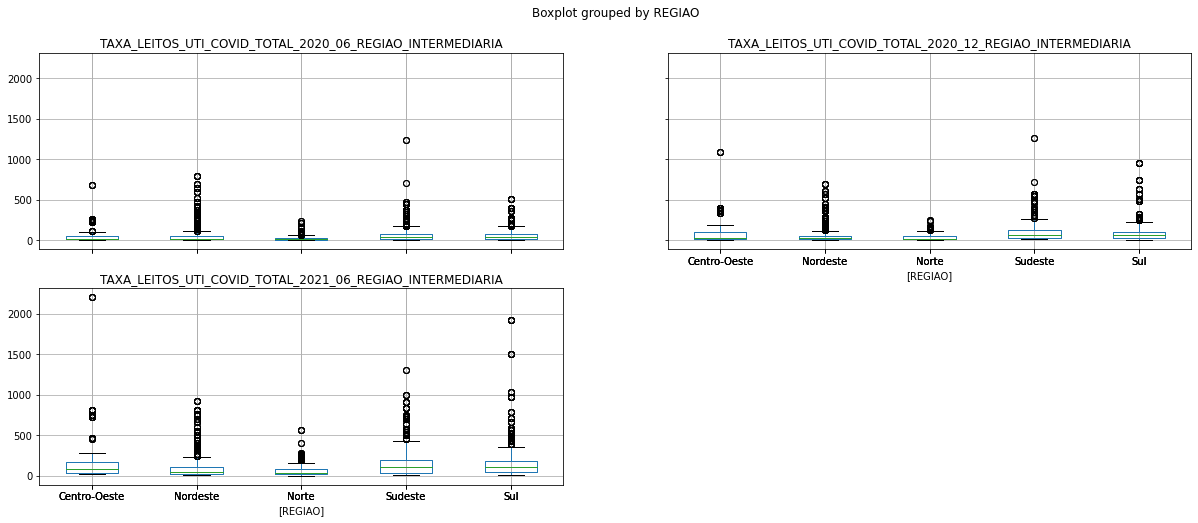

In [41]:
df_base[["TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA", 'REGIAO']].boxplot(by='REGIAO', figsize=(20,8))

In [42]:
from IPython.display import display

def show_analisys_attribute(df, attribute):
    display(df)
    display(df.describe())

    df[attribute].hist(legend=True)
    plt.show()
    df.boxplot(column=[attribute])
    plt.show()
    df[attribute].hist(by=df_base.REGIAO)
    plt.show()
    df[[attribute,'REGIAO']].boxplot(by='REGIAO')
    plt.show()
    ax = plt.figure(figsize = (15,20)).gca()
    df[attribute].hist(by=df_base.ESTADO, ax=ax)
    plt.show()
    df[[attribute,'SIGLA_ESTADO']].boxplot(by='SIGLA_ESTADO', figsize=(20,8))
    plt.show()
    df_mg = df[df['SIGLA_ESTADO'] == 'MG']
    ax = plt.figure(figsize = (15,20)).gca()
    df_mg[attribute].hist(by=df_mg.REGIAO_INTERMEDIARIA, ax=ax)
    plt.show()
    df_mg[[attribute,'REGIAO_INTERMEDIARIA']].boxplot(by='REGIAO_INTERMEDIARIA', figsize=(20,8))
    plt.show()
    df_regiao_moc = df[df.REGIAO_INTERMEDIARIA == 'Montes Claros']
    ax = plt.figure(figsize = (15,20)).gca()
    df_regiao_moc[attribute].hist(by=df_regiao_moc.REGIAO_IMEDIATA, ax=ax)
    plt.show()
    df_regiao_moc[[attribute,'REGIAO_IMEDIATA']].boxplot(by='REGIAO_IMEDIATA', figsize=(20,8))
    plt.show()

MUNICIPIO CODIGO_MUNICIPIO_6 SIGLA_ESTADO  CODIGO_ESTADO  \
0     Alta Floresta D'Oeste             110001           RO             11   
1                 Ariquemes             110002           RO             11   
2                    Cabixi             110003           RO             11   
3                    Cacoal             110004           RO             11   
4                Cerejeiras             110005           RO             11   
...                     ...                ...          ...            ...   
5565             Vianópolis             522200           GO             52   
5566         Vicentinópolis             522205           GO             52   
5567               Vila Boa             522220           GO             52   
5568          Vila Propício             522230           GO             52   
5569               Brasília             530010           DF             53   

            REGIAO      REGIAO_SAUDE  CODIGO_REGIAO_SAUDE  \
0            Norte      ZONA DA MATA              11005.0   
1            Norte    VALE DO JAMARI              11001.0   
2            Norte          CONE SUL              11006.0   
3            Norte              CAFE              11002.0   
4            Norte          CONE SUL              11006.0   
...            ...               ...                  ...   
5565  Centro-Oeste        CENTRO SUL              52002.0   
5566  Centro-Oeste        CENTRO SUL              52002.0   
5567  Centro-Oeste     ENTORNO NORTE              52003.0   
5568  Centro-Oeste   SAO PATRICIO II              52018.0   
5569  Centro-Oeste  DISTRITO FEDERAL              53001.0   

      REGIAO_METROPOLITANA     CASOS  OBITOS  ...  \
0                      0.0    4057.0      65  ...   
1                      0.0   22501.0     494  ...   
2                      0.0     907.0      21  ...   
3                      0.0   14507.0     302  ...   
4                      0.0    2537.0      61  ...   
...                    ...       ...     ...  ...   
5565                   0.0     974.0      33  ...   
5566                   0.0    1377.0      24  ...   
5567                   0.0     198.0       4  ...   
5568                   0.0     391.0       7  ...   
5569                   1.0  468264.0   10007  ...   

     TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA  \
0                                    157.813728   
1                                     85.417156   
2                                    130.286567   
3                                    157.813728   
4                                    130.286567   
...                                         ...   
5565                                 173.719449   
5566                                  65.840666   
5567                                  63.498111   
5568                                 140.043764   
5569                                 338.145730   

     TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA  \
0                                        120.146254   
1                                         71.323325   
2                                        111.312795   
3                                        120.146254   
4                                        111.312795   
...                                             ...   
5565                                     101.404056   
5566                                      94.271862   
5567                                      71.435375   
5568                                     126.118958   
5569                                     198.191338   

      TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA  \
0                                             12.988784              
1                                             20.927203              
2                                             10.119345              
3                                             12.988784              
4                                             10.119345              
...              

CODIGO_ESTADO  CODIGO_REGIAO_SAUDE  REGIAO_METROPOLITANA  \
count    5570.000000          5570.000000           5570.000000   
mean       32.377738         32403.123698              0.069300   
std         9.833862          9837.224401              0.253986   
min        11.000000         11001.000000              0.000000   
25%        25.000000         25010.000000              0.000000   
50%        31.000000         31059.000000              0.000000   
75%        41.000000         41015.000000              0.000000   
max        53.000000         53001.000000              1.000000   

               CASOS        OBITOS  POPULACAO_ESTIMADA  \
count    5570.000000   5570.000000        5.570000e+03   
mean     3714.094434    103.751885        3.772839e+04   
std     19091.629993    765.152091        2.214581e+05   
min        10.000000      0.000000        7.810000e+02   
25%       450.000000      9.000000        5.446500e+03   
50%       960.000000     20.000000        1.163100e+04   
75%      2355.750000     51.000000        2.549050e+04   
max    938981.000000  37030.000000        1.225202e+07   

       DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO  \
count                               5.570000e+03   
mean                                1.176968e+04   
std                                 7.378126e+04   
min                                 3.190000e+02   
25%                                 1.698500e+03   
50%                                 3.432500e+03   
75%                                 7.373000e+03   
max                                 4.104611e+06   

       DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO  \
count                                        5570.000000       
mean                                          920.600898       
std                                         12945.799490       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             0.000000       
max                                        529921.000000       

       PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO  \
count                                        5570.000000                  
mean                                            1.043896                  
std                                             4.509078                  
min                                             0.000000                  
25%                                             0.000000                  
50%                                             0.000000                  
75%                                             0.000000                  
max                                            73.993700                  

       CODIGO_REGIAO_IMEDIATA  ...  \
count             5570.000000  ...   
mean            323793.462657  ...   
std              98340.639166  ...   
min             110001.000000  ...   
25%             250009.000000  ...   
50%             310039.000000  ...   
75%             410019.000000  ...   
max             530001.000000  ...   

       TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA  \
count                                 5570.000000   
mean                                   141.237603   
std                                     79.544378   
min                                     22.013312   
25%                                     75.856192   
50%                                    123.168115   
75%                                    186.799997   
max                                    490.043880   

       TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA  \
count                                     5570.000000   
mean                                       113.414440   
std                                         33.585401   
min                                         35.609769   
25%                                         88.70453

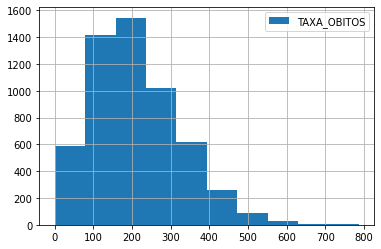

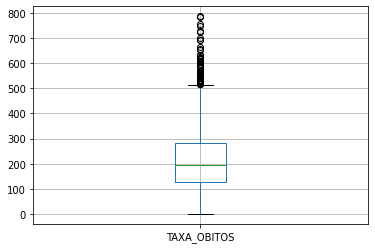

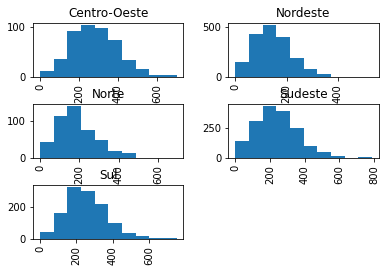

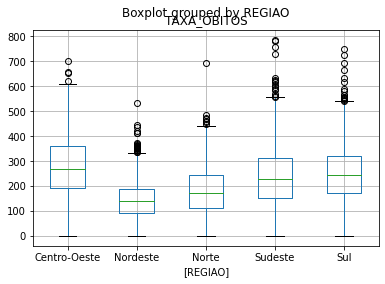

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


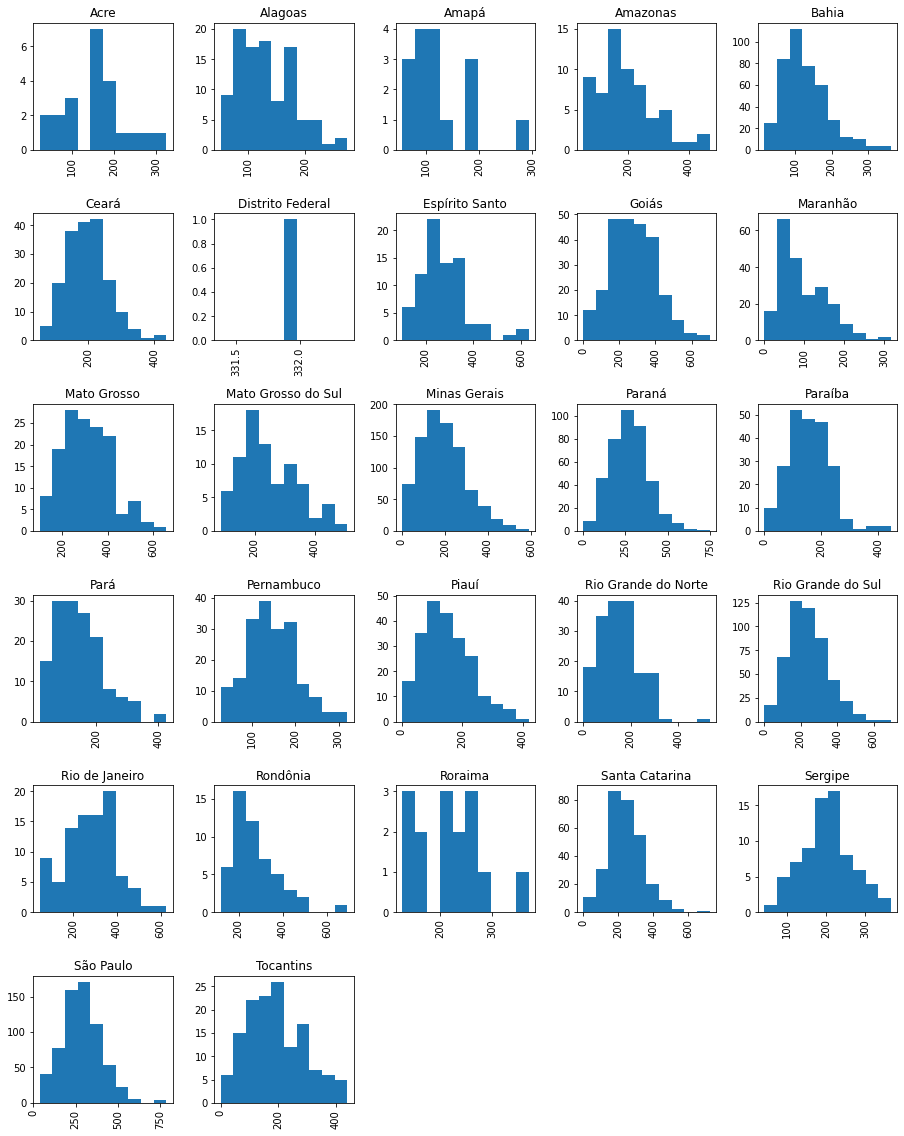

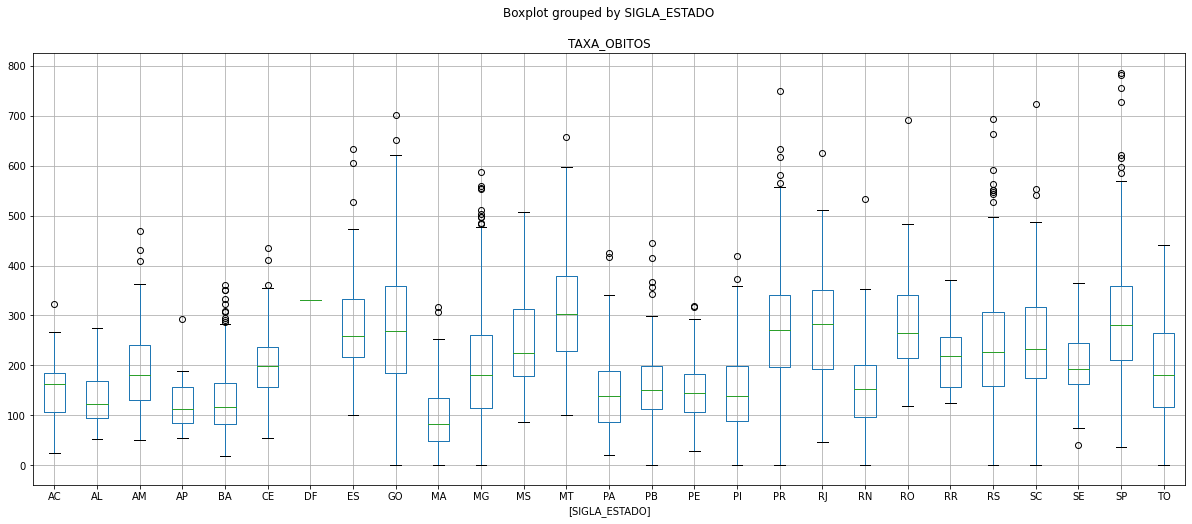

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


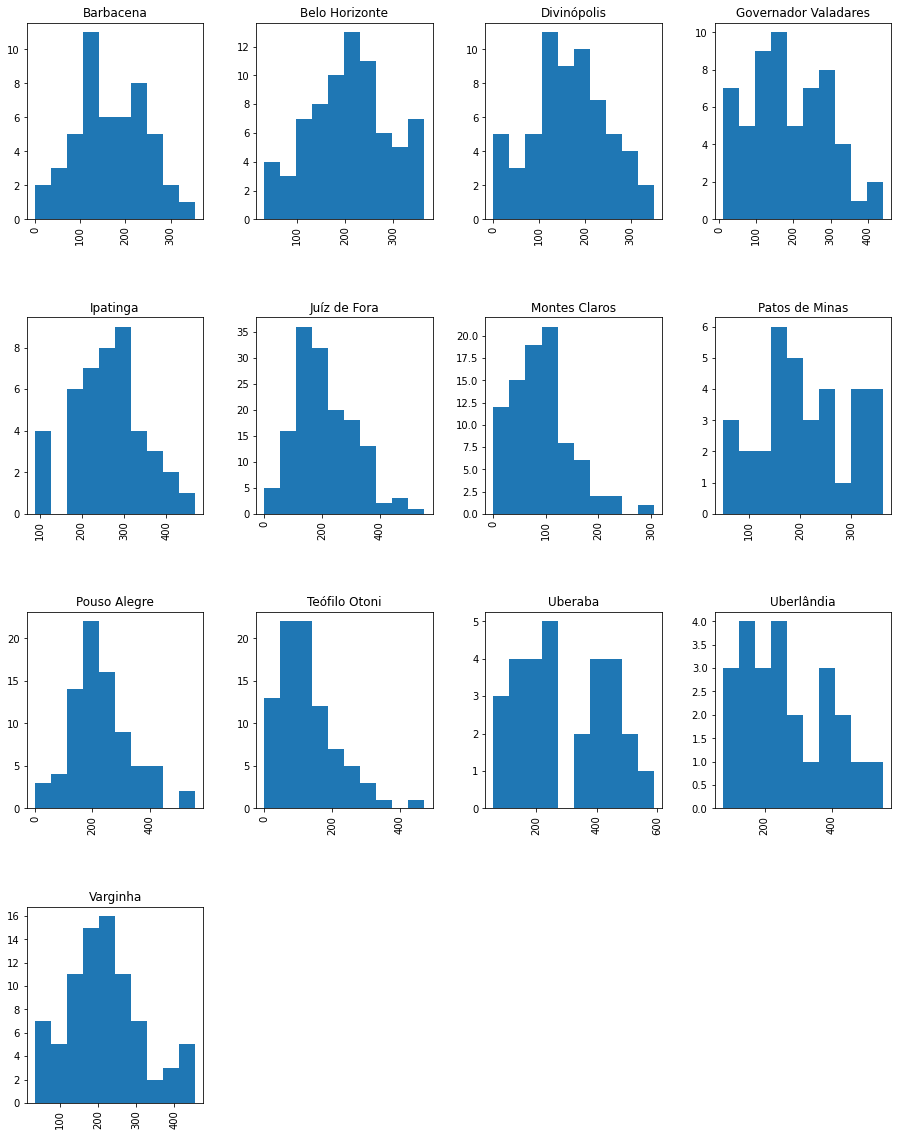

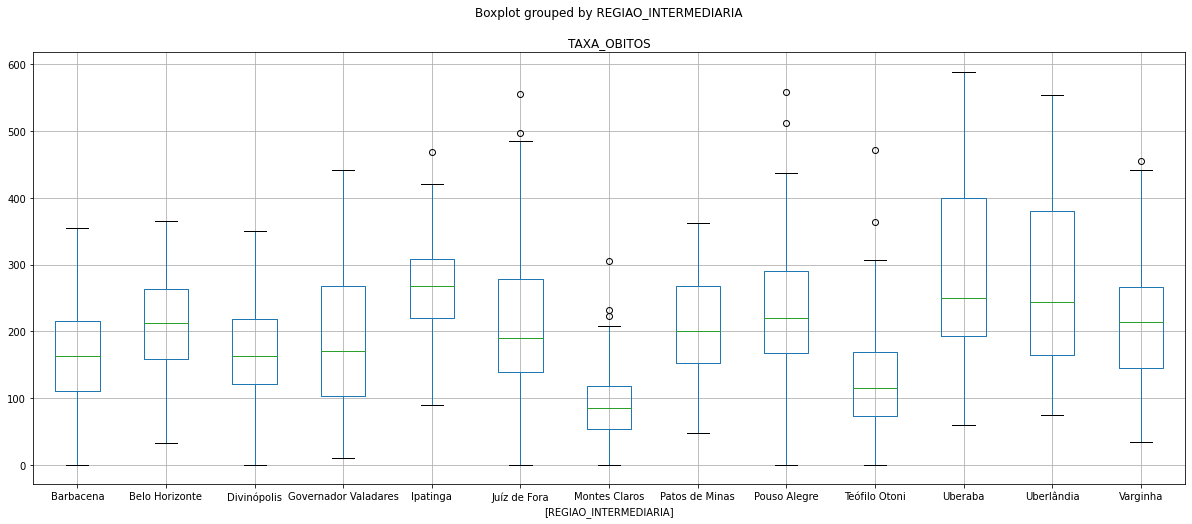

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


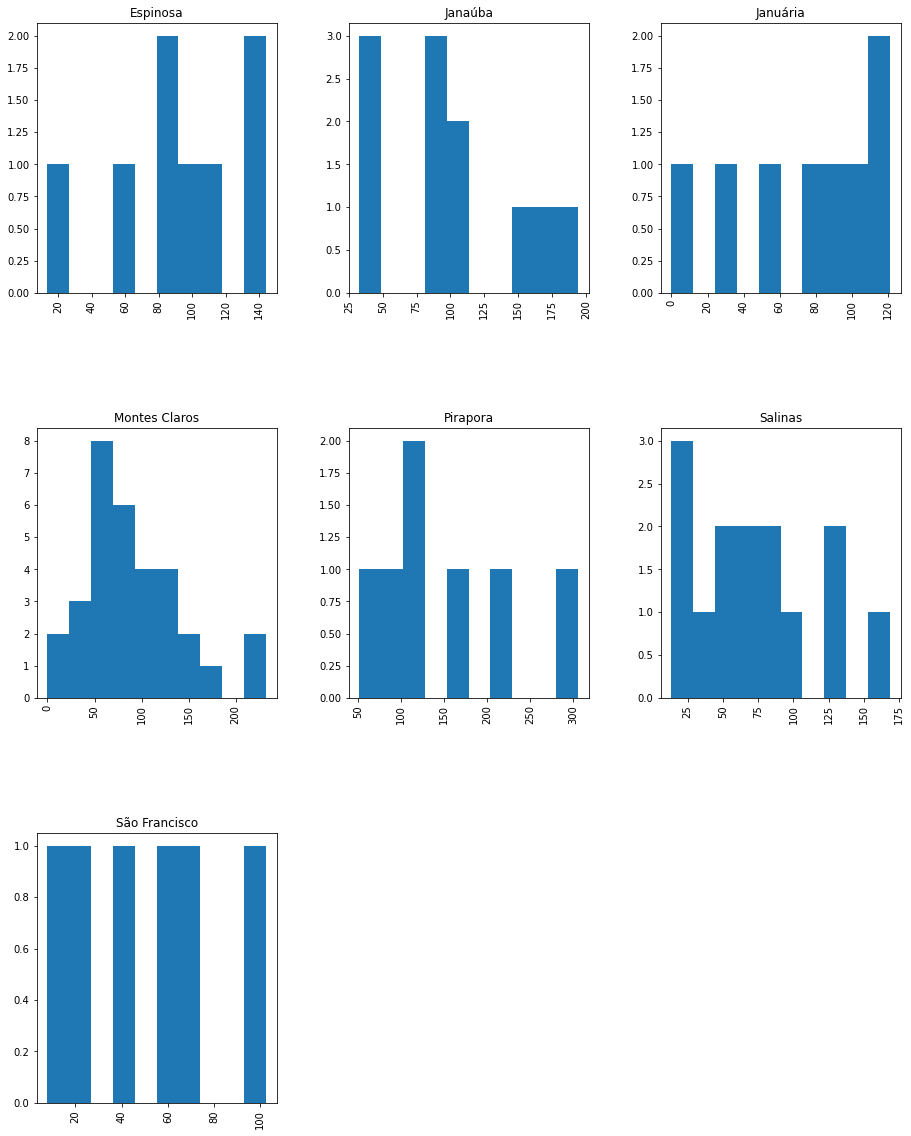

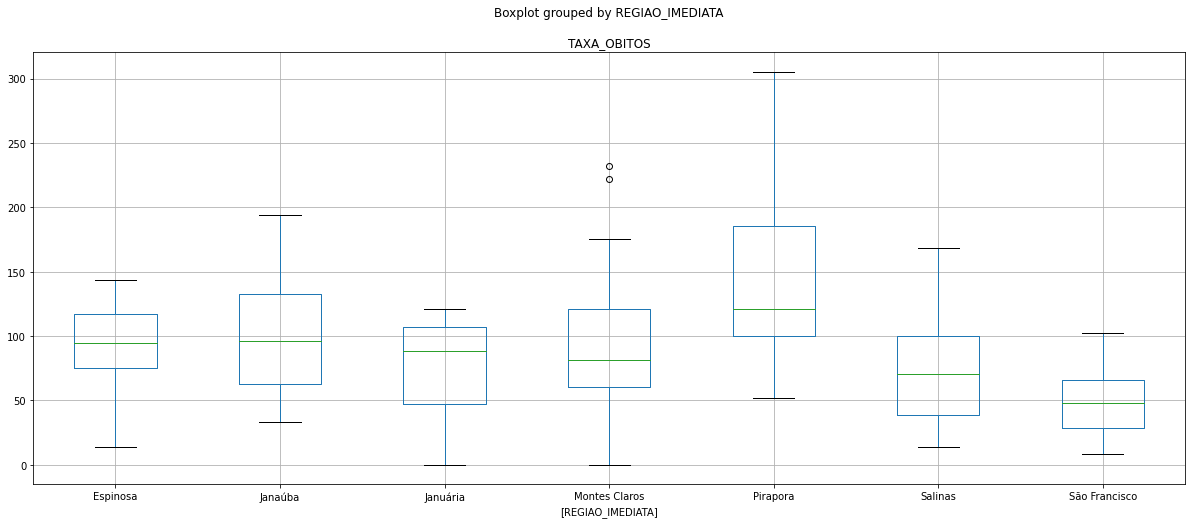

CODIGO_MUNICIPIO_6  MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
0                110001                                                NaN      
1                110002                                                NaN      
2                110004                                                NaN      
3                110005                                                NaN      
4                110006                                                NaN      
...                 ...                                                ...      
2303             522140                                          -0.975676      
2304             522160                                         -44.336992      
2305             522185                                          17.002817      
2306             522200                                                NaN      
2307             530010                                         -15.989189      

      MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
0                                             12.369697   
1                                              9.708108   
2                                              6.062162   
3                                              3.489951   
4                                              5.028125   
...                                                 ...   
2303                                          -3.935135   
2304                                           3.476056   
2305                                          -5.797297   
2306                                           0.845775   
2307                                         -19.843243   

      MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS        REGIAO  \
0                                                   NaN         Norte   
1                                              8.945946         Norte   
2                                              5.964865         Norte   
3                                                   NaN         Norte   
4                                                   NaN         Norte   
...                                                 ...           ...   
2303                                          11.545946  Centro-Oeste   
2304                                           6.425676  Centro-Oeste   
2305                                          12.935135  Centro-Oeste   
2306                                                NaN  Centro-Oeste   
2307                                          12.627027  Centro-Oeste   

     SIGLA_ESTADO              REGIAO_INTERMEDIARIA       REGIAO_IMEDIATA  
0              RO                         Ji-Paraná                Cacoal  
1              RO                       Porto Velho             Ariquemes  
2              RO                         Ji-Paraná                Cacoal  
3              RO                         Ji-Paraná               Vilhena  
4              RO                         Ji-Paraná               Vilhena  
...           ...                               ...                   ...  
2303           GO                           Goiânia               Goiânia  
2304           GO                Porangatu - Uruaçu  Uruaçu - Niquelândia  
2305           GO  Luziânia - Águas Lindas de Goiás              Luziânia  
2306           GO                           Goiânia              Anápolis  
2307           DF                  Distrito Federal      Distrito Federal  

[2308 rows x 8 columns]

MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
count                                         710.000000      
mean                                          -28.645484      
std                                            25.528351      
min                                           -99.937838      
25%                                           -46.319928      
50%                                           -32.978150      
75%                                           -16.133099      
max                                           110.245540      

       MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
count                                        2285.000000   
mean                                           -3.179237   
std                                             7.395087   
min                                           -56.000000   
25%                                            -7.642537   
50%                                            -3.000000   
75%                                             1.406557   
max                                            22.698361   

       MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS  
count                                        1091.000000  
mean                                            7.502753  
std                                             4.146249  
min                                           -71.000000  
25%                                             5.611895  
50%                                             7.829932  
75%                                             9.820946  
max                                            16.706757

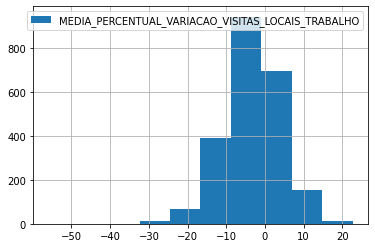

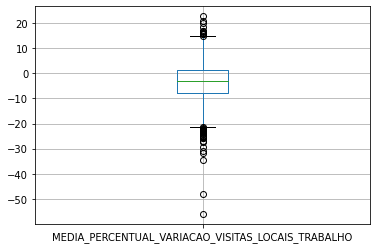

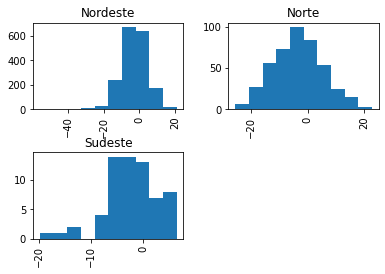

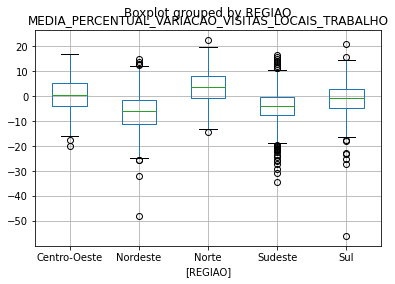

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


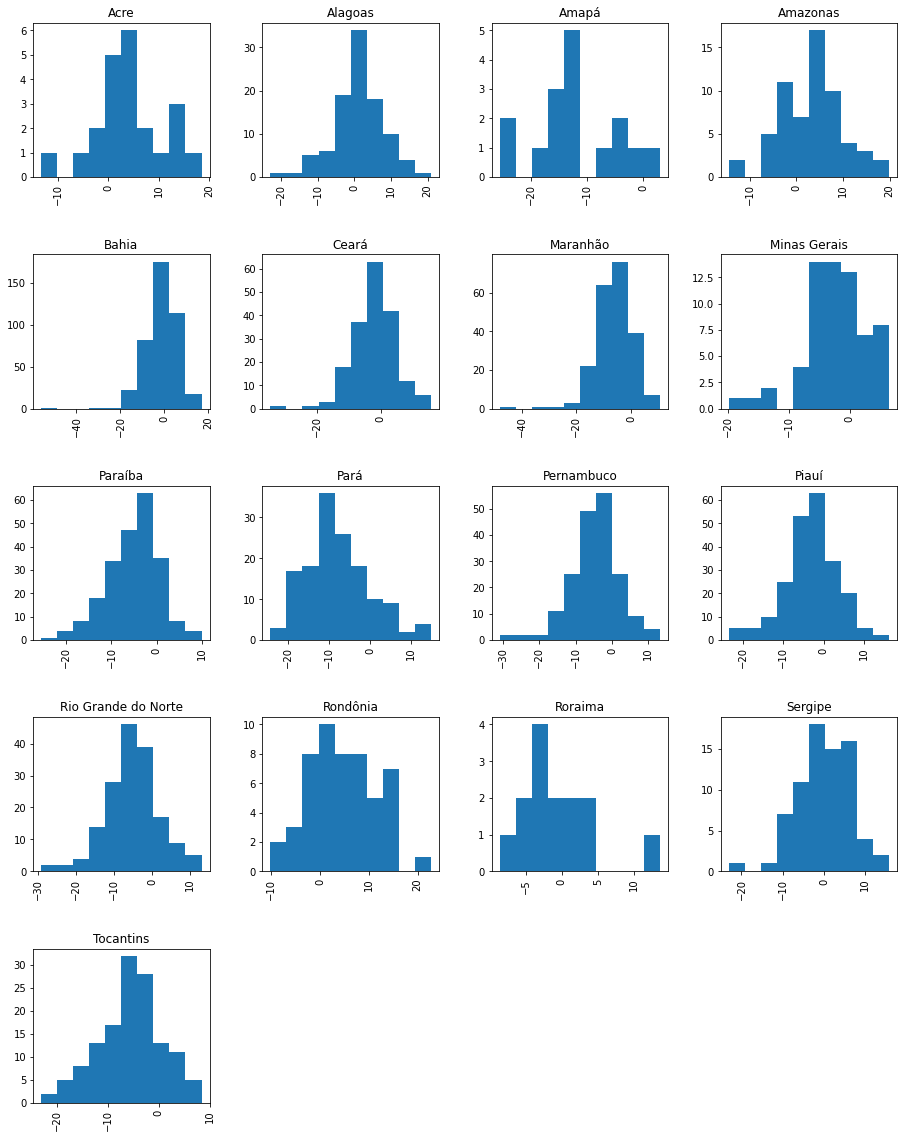

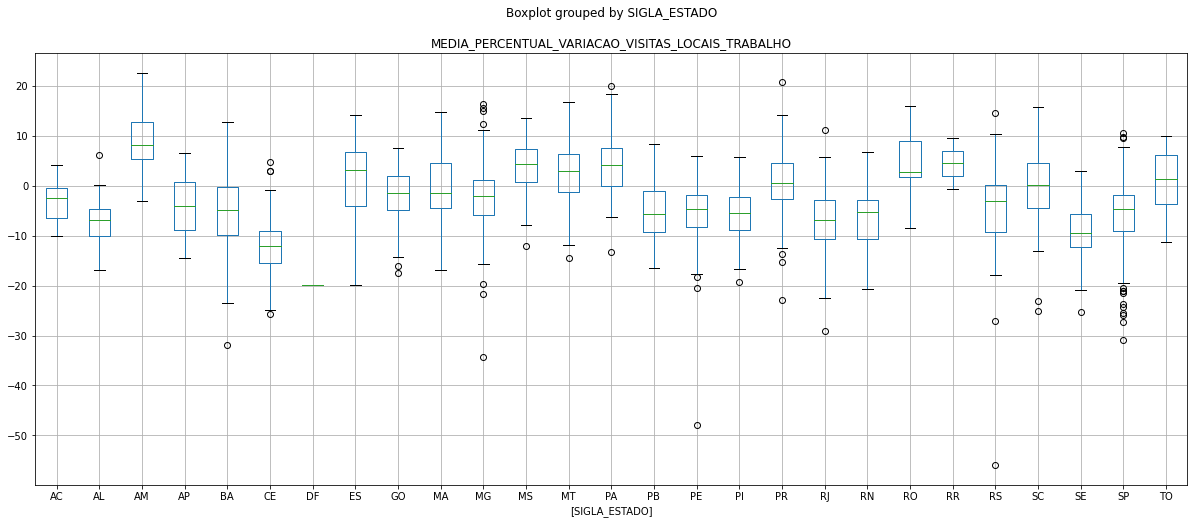

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


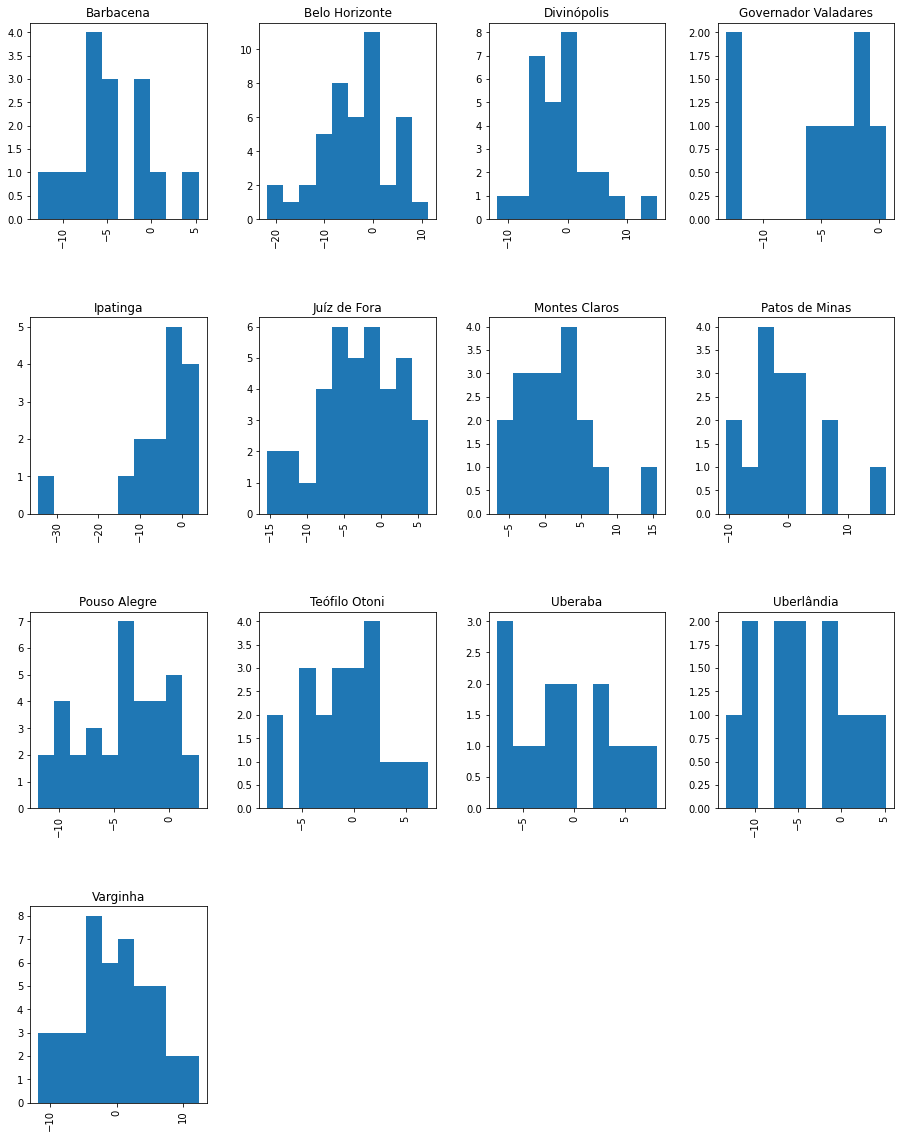

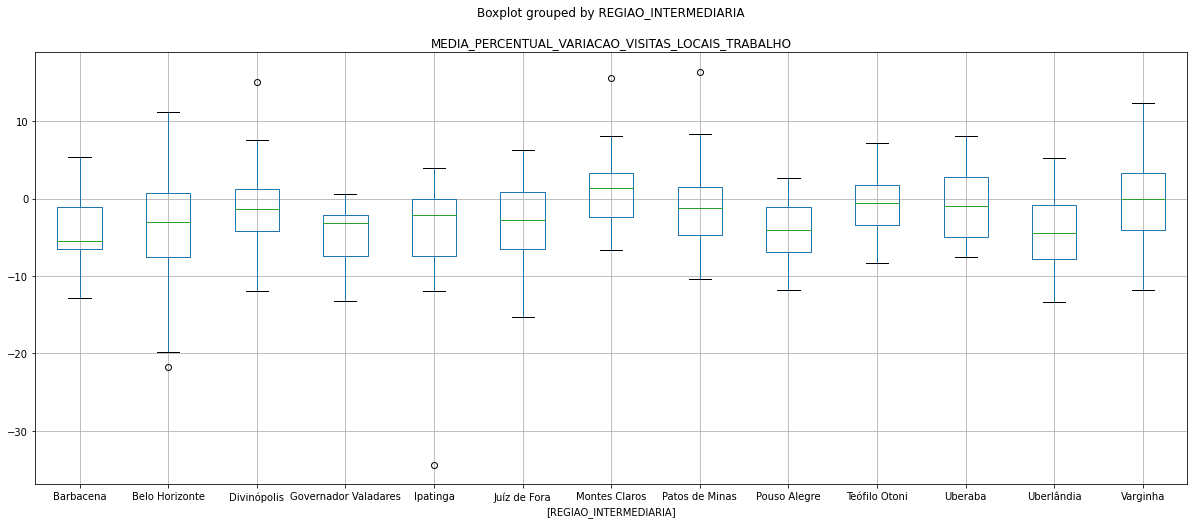

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


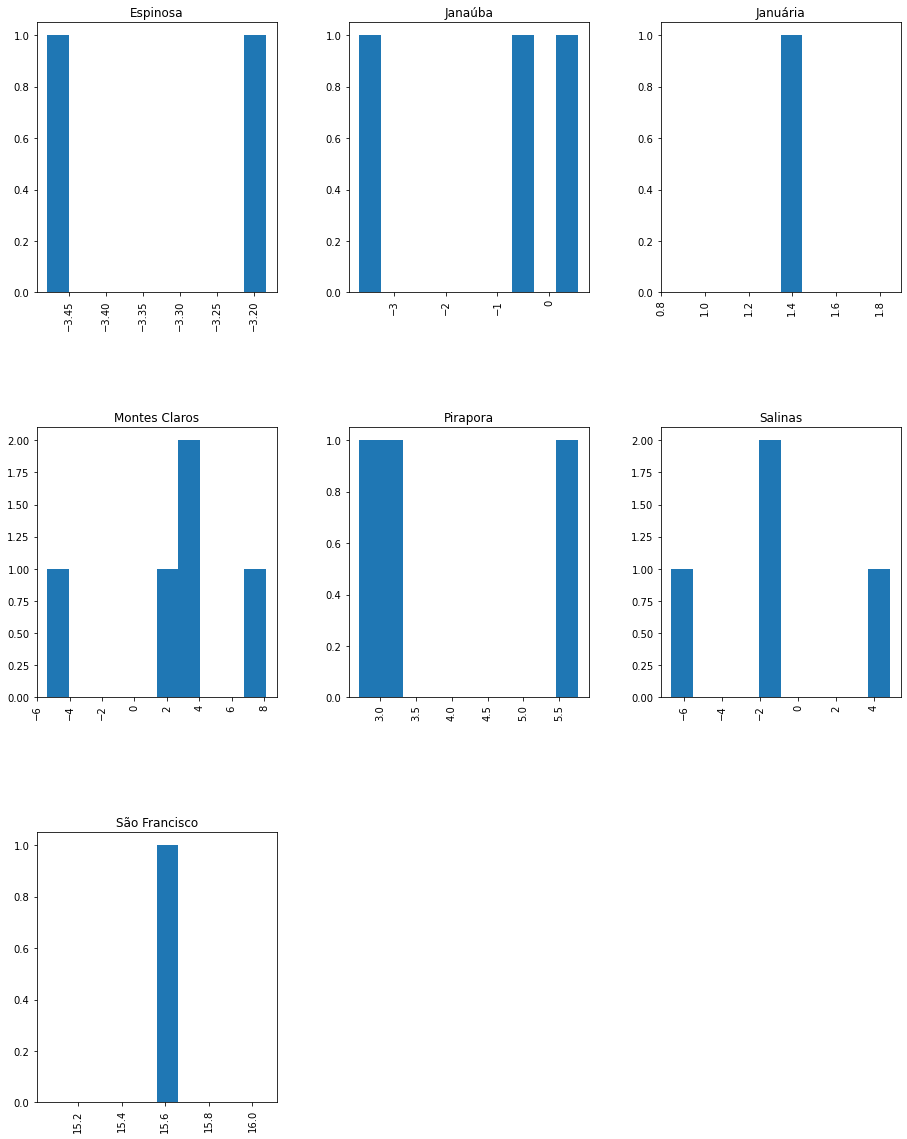

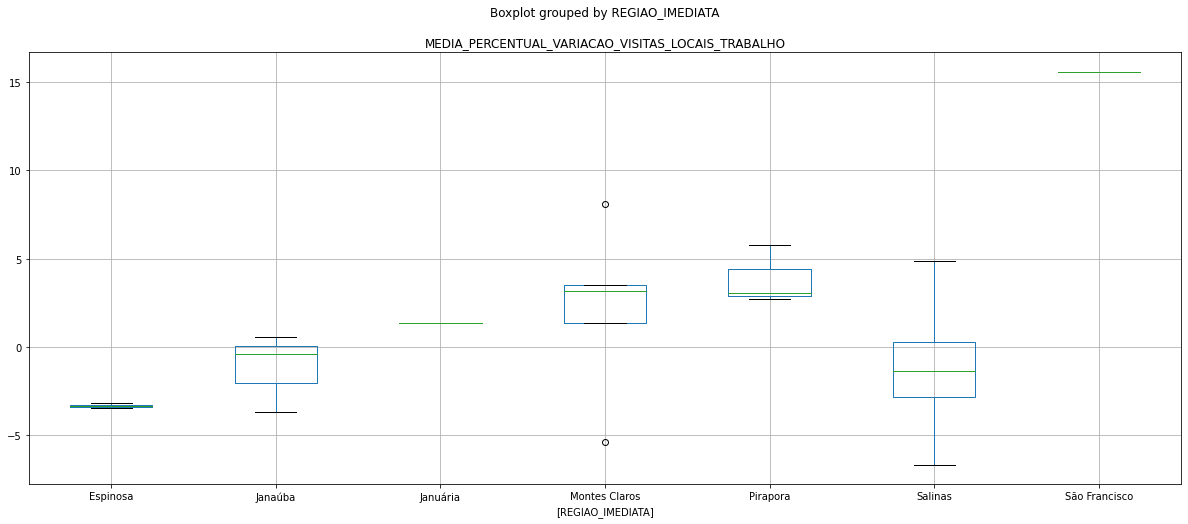

CODIGO_MUNICIPIO_6  \
0                110001   
1                110002   
2                110004   
3                110005   
4                110006   
...                 ...   
2303             522140   
2304             522160   
2305             522185   
2306             522200   
2307             530010   

      MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
0                                                   NaN        
1                                                   NaN        
2                                                   NaN        
3                                                   NaN        
4                                                   NaN        
...                                                 ...        
2303                                          -2.100000        
2304                                         -44.666667        
2305                                          16.800000        
2306                                                NaN        
2307                                         -13.400000        

      MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
0                                                  14.9     
1                                                  11.2     
2                                                   7.2     
3                                                   6.5     
4                                                   8.3     
...                                                 ...     
2303                                               -0.8     
2304                                                3.8     
2305                                               -3.0     
2306                                                2.6     
2307                                              -18.5     

      MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS        REGIAO  \
0                                                   NaN           Norte   
1                                                   8.9           Norte   
2                                                   5.4           Norte   
3                                                   NaN           Norte   
4                                                   NaN           Norte   
...                                                 ...             ...   
2303                                               10.9    Centro-Oeste   
2304                                                5.8    Centro-Oeste   
2305                                               11.8    Centro-Oeste   
2306                                                NaN    Centro-Oeste   
2307                                               11.6    Centro-Oeste   

     SIGLA_ESTADO              REGIAO_INTERMEDIARIA       REGIAO_IMEDIATA  
0              RO                         Ji-Paraná                Cacoal  
1              RO                       Porto Velho             Ariquemes  
2              RO                         Ji-Paraná                Cacoal  
3              RO                         Ji-Paraná               Vilhena  
4              RO                         Ji-Paraná               Vilhena  
...           ...                               ...                   ...  
2303           GO                           Goiânia               Goiânia  
2304           GO                Porangatu - Uruaçu  Uruaçu - Niquelândia  
2305           GO  Luziânia - Águas Lindas de Goiás              Luziânia  
2306           GO                           Goiânia              Anápolis  
2307           DF                  Distrito Federal      Distrito Federal  

[2308 rows x 8 columns]

MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
count                                         710.000000        
mean                                          -27.429930        
std                                            28.105821        
min                                          -100.000000        
25%                                           -46.575000        
50%                                           -31.150000        
75%                                           -14.025000        
max                                           143.800000        

       MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
count                                        2285.000000     
mean                                           -2.004894     
std                                             6.996362     
min                                           -56.000000     
25%                                            -6.000000     
50%                                            -1.800000     
75%                                             2.400000     
max                                            22.800000     

       MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS  
count                                        1091.000000    
mean                                            6.756470    
std                                             3.898822    
min                                           -71.000000    
25%                                             5.100000    
50%                                             7.000000    
75%                                             8.800000    
max                                            16.200000

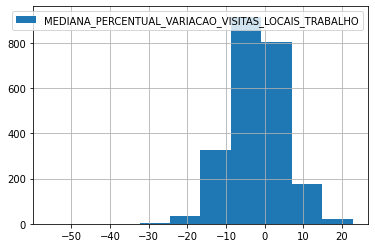

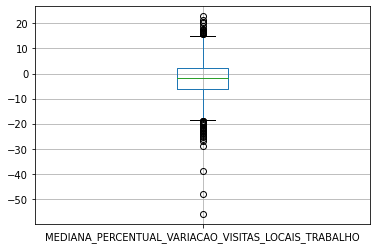

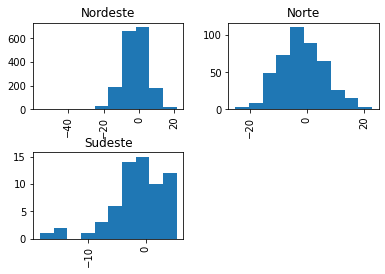

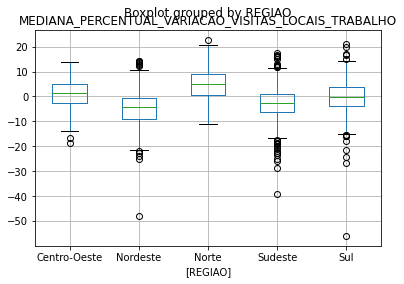

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


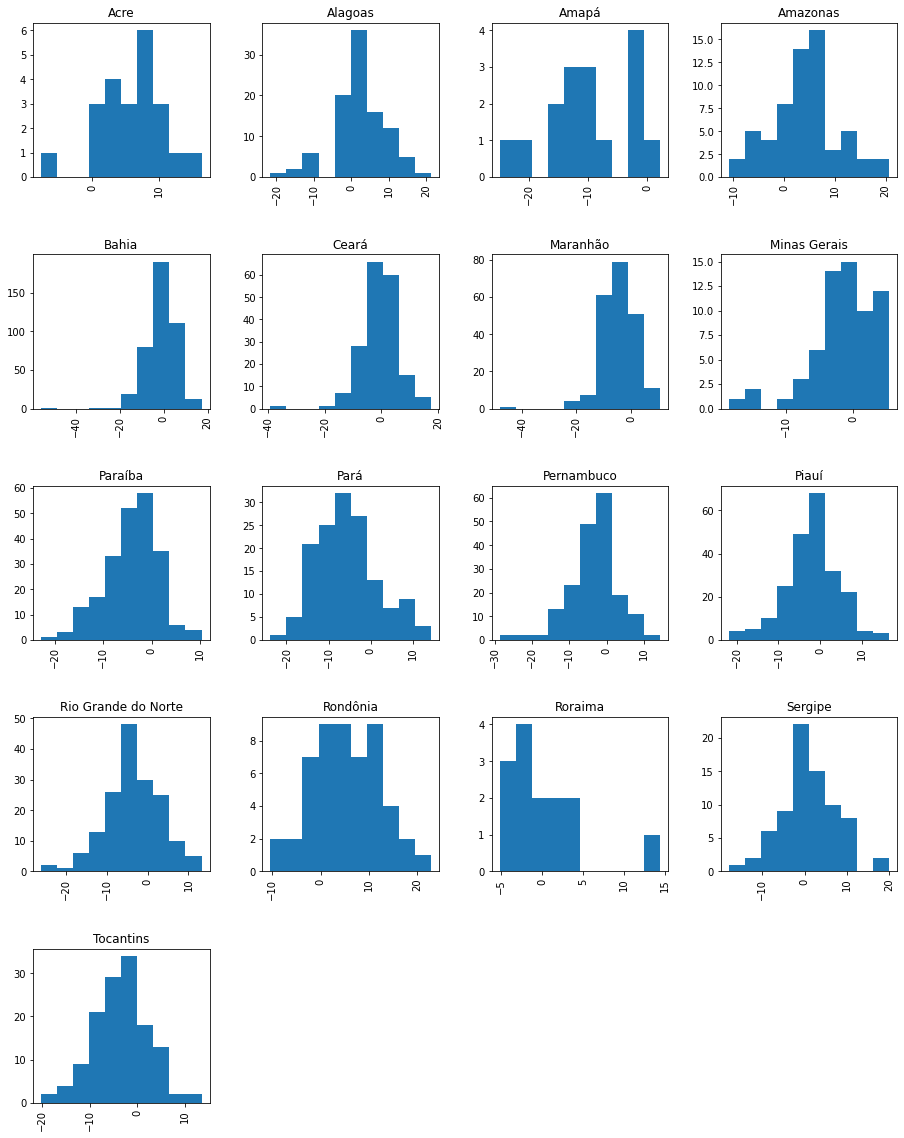

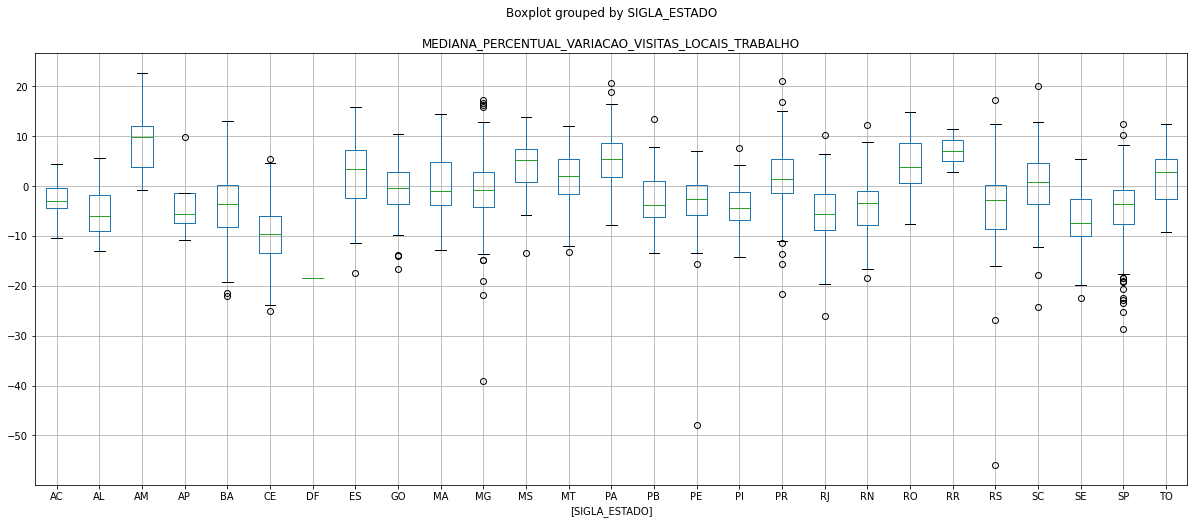

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


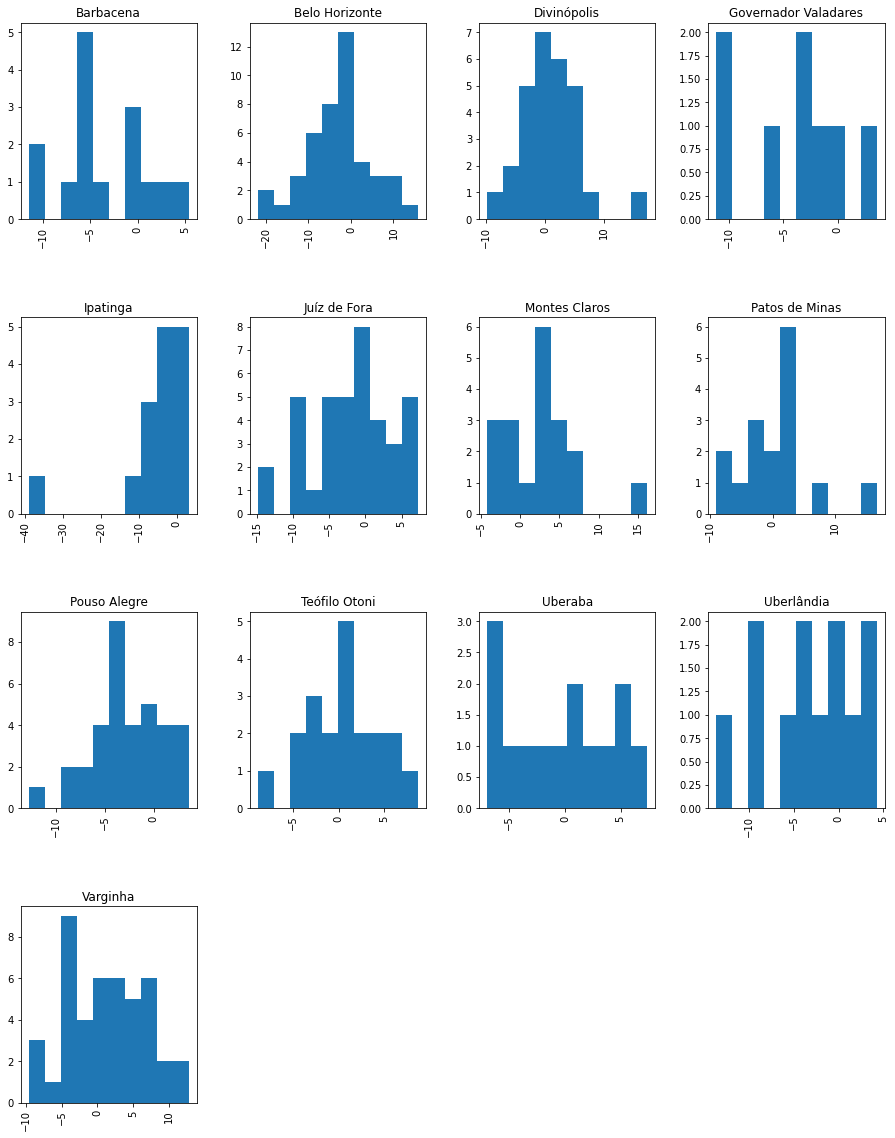

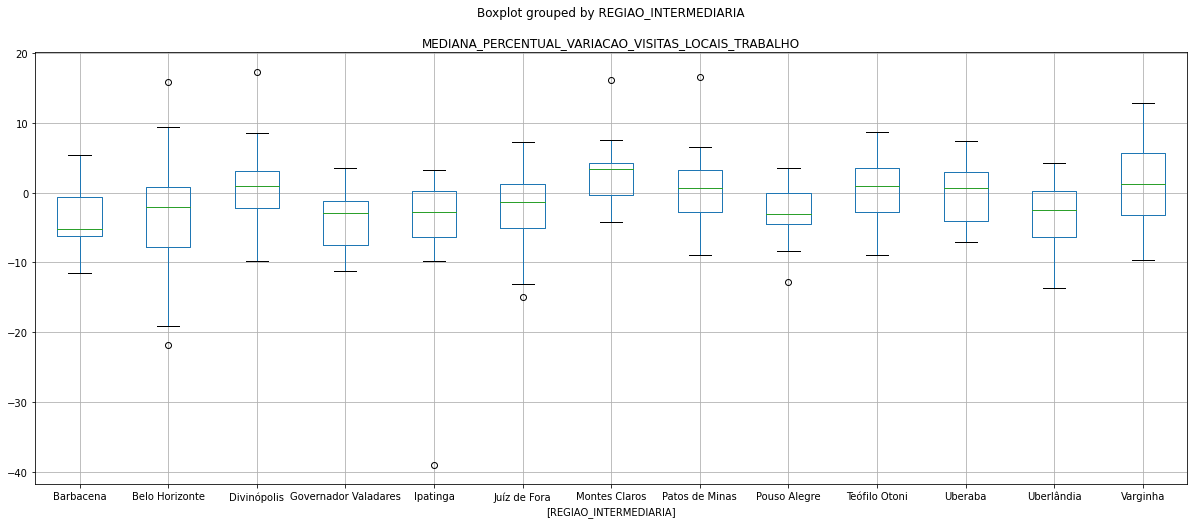

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


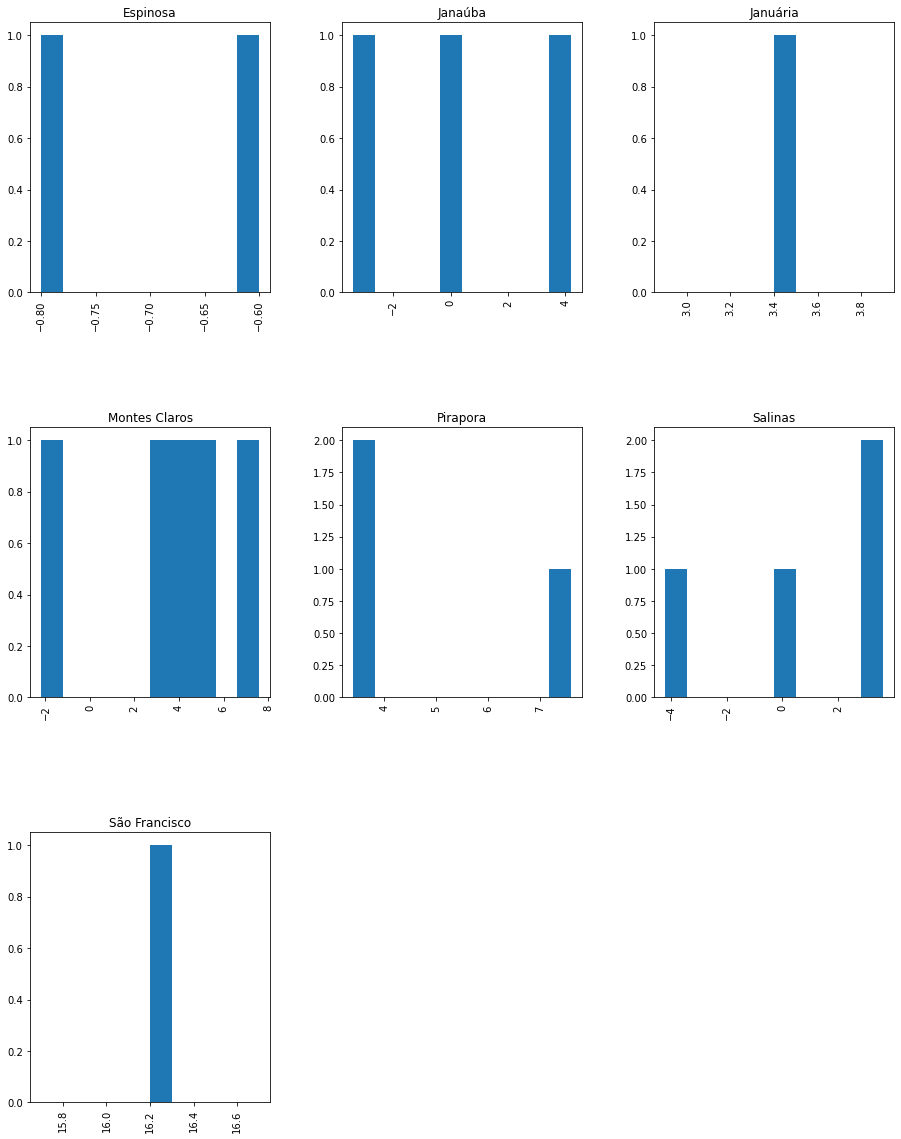

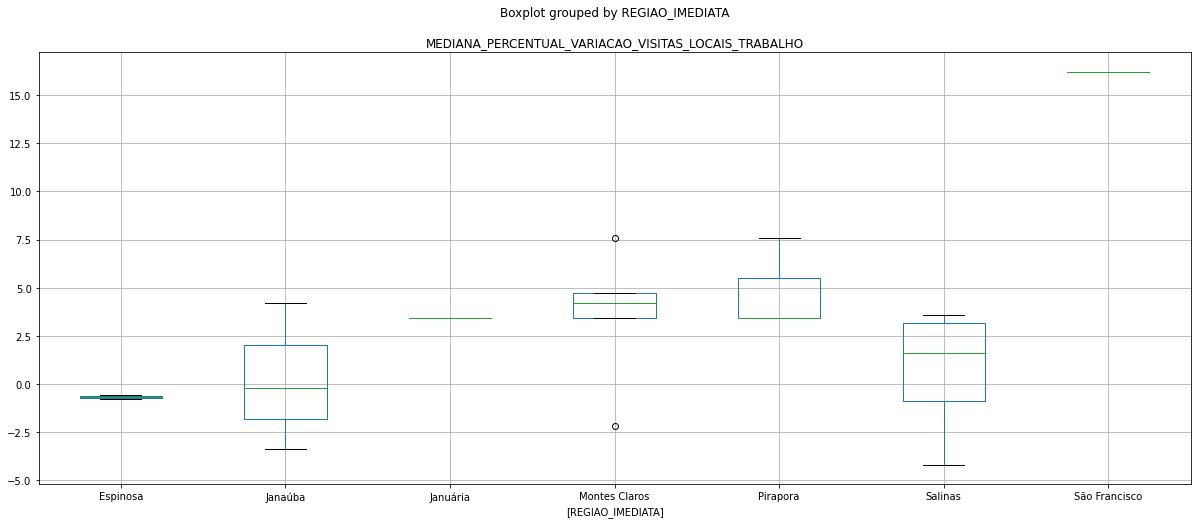

CODIGO_MUNICIPIO_6  \
0                110001   
1                110002   
2                110004   
3                110005   
4                110006   
...                 ...   
2303             522140   
2304             522160   
2305             522185   
2306             522200   
2307             530010   

      QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
0                                                   NaN           
1                                                   NaN           
2                                                   NaN           
3                                                   NaN           
4                                                   NaN           
...                                                 ...           
2303                                                7.9           
2304                                              -35.0           
2305                                               38.8           
2306                                                NaN           
2307                                               -4.8           

      QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
0                                                 23.20        
1                                                 22.75        
2                                                 16.15        
3                                                 12.00        
4                                                 13.65        
...                                                 ...        
2303                                               6.75        
2304                                              13.00        
2305                                               5.10        
2306                                               6.80        
2307                                              -9.95        

      QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS        REGIAO  \
0                                                   NaN              Norte   
1                                                 10.80              Norte   
2                                                  9.00              Norte   
3                                                   NaN              Norte   
4                                                   NaN              Norte   
...                                                 ...                ...   
2303                                              14.55       Centro-Oeste   
2304                                              10.95       Centro-Oeste   
2305                                              16.10       Centro-Oeste   
2306                                                NaN       Centro-Oeste   
2307                                              15.35       Centro-Oeste   

     SIGLA_ESTADO              REGIAO_INTERMEDIARIA       REGIAO_IMEDIATA  
0              RO                         Ji-Paraná                Cacoal  
1              RO                       Porto Velho             Ariquemes  
2              RO                         Ji-Paraná                Cacoal  
3              RO                         Ji-Paraná               Vilhena  
4              RO                         Ji-Paraná               Vilhena  
...           ...                               ...                   ...  
2303           GO                           Goiânia               Goiânia  
2304           GO                Porangatu - Uruaçu  Uruaçu - Niquelândia  
2305           GO  Luziânia - Águas Lindas de Goiás              Luziânia  
2306           GO                           Goiânia              Anápolis  
2307           DF                  Distrito Federal      Distrito Federal  

[2308 rows x 8 columns]

QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
count                                         710.000000           
mean                                          -17.362705           
std                                            32.264985           
min                                          -100.000000           
25%                                           -37.737500           
50%                                           -21.900000           
75%                                            -3.812500           
max                                           179.400000           

       QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
count                                        2285.000000        
mean                                            4.945137        
std                                             7.524165        
min                                           -55.000000        
25%                                             0.400000        
50%                                             5.000000        
75%                                             9.500000        
max                                            33.900000        

       QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS  
count                                        1091.000000       
mean                                            9.691789       
std                                             4.494327       
min                                           -71.000000       
25%                                             7.800000       
50%                                            10.000000       
75%                                            12.200000       
max                                            19.600000

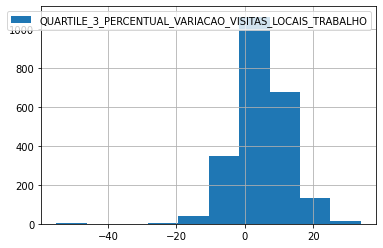

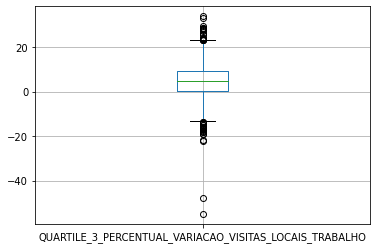

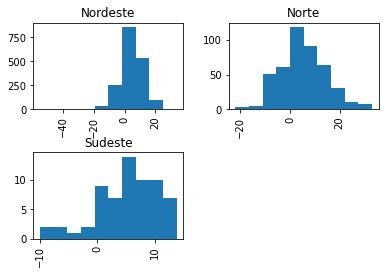

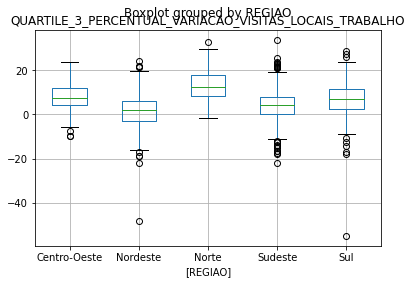

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


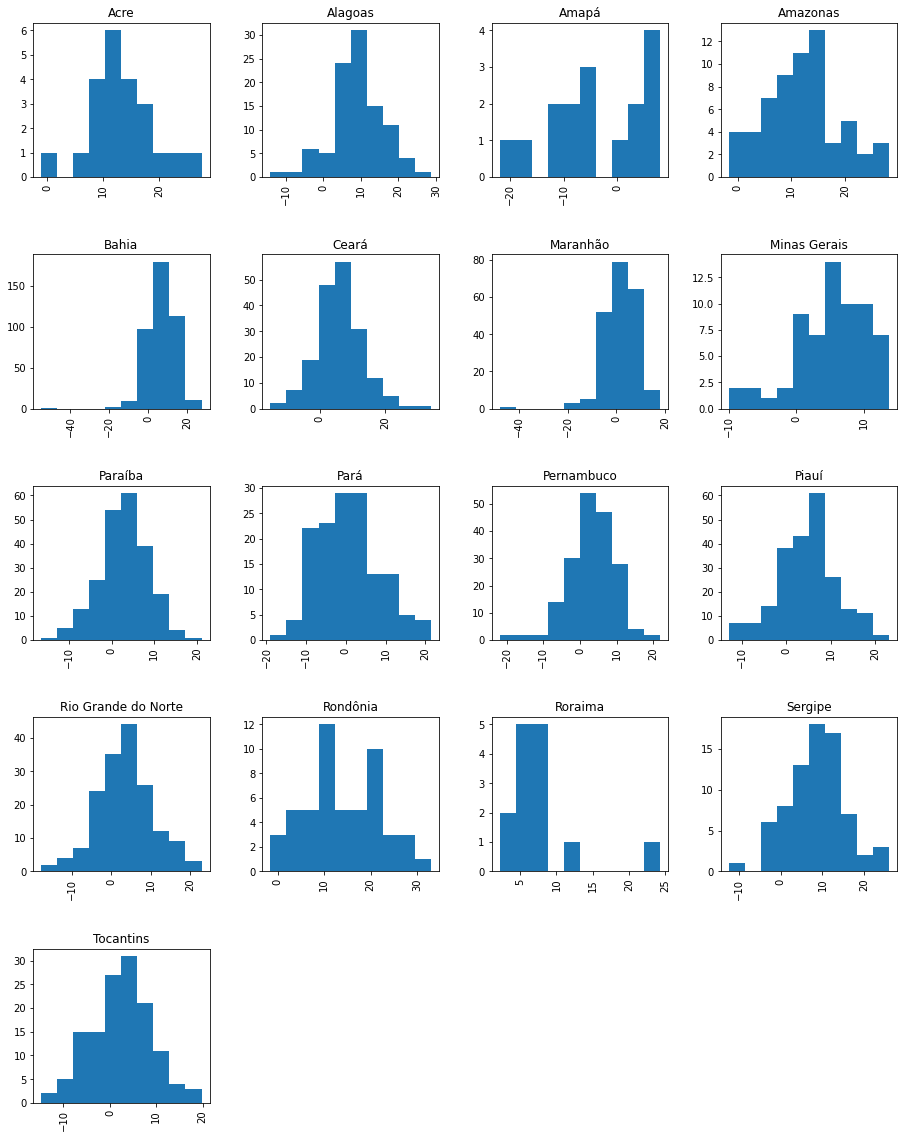

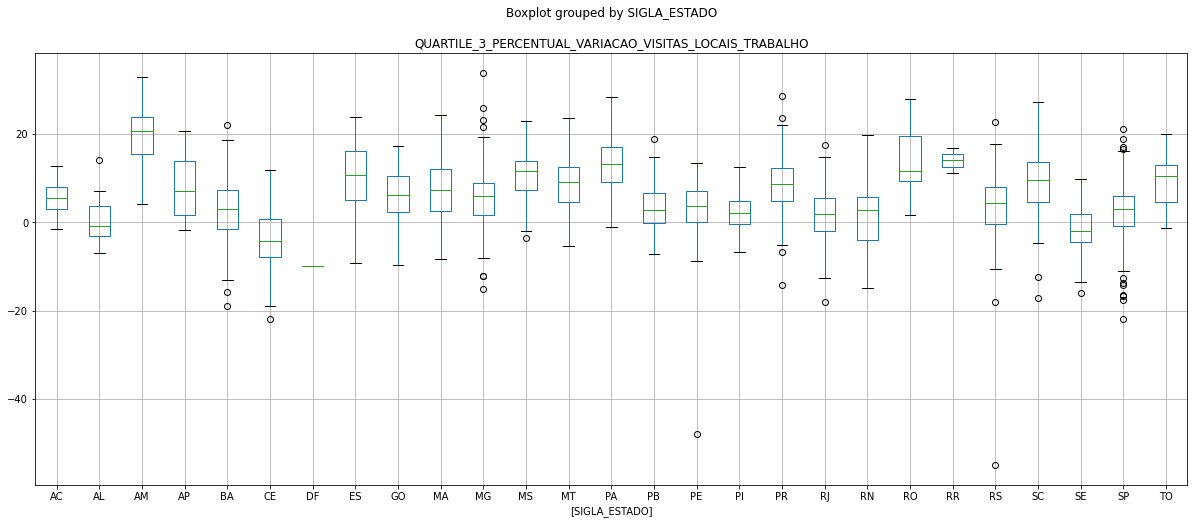

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


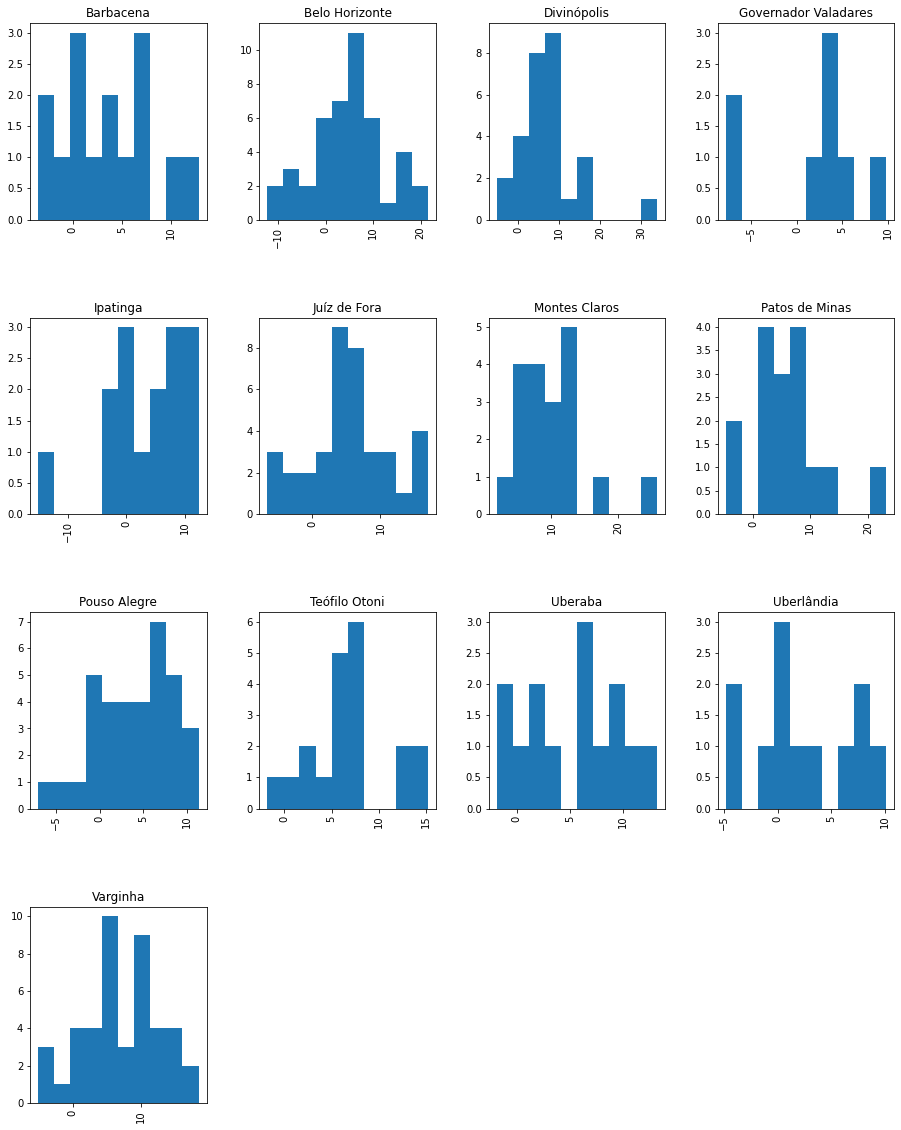

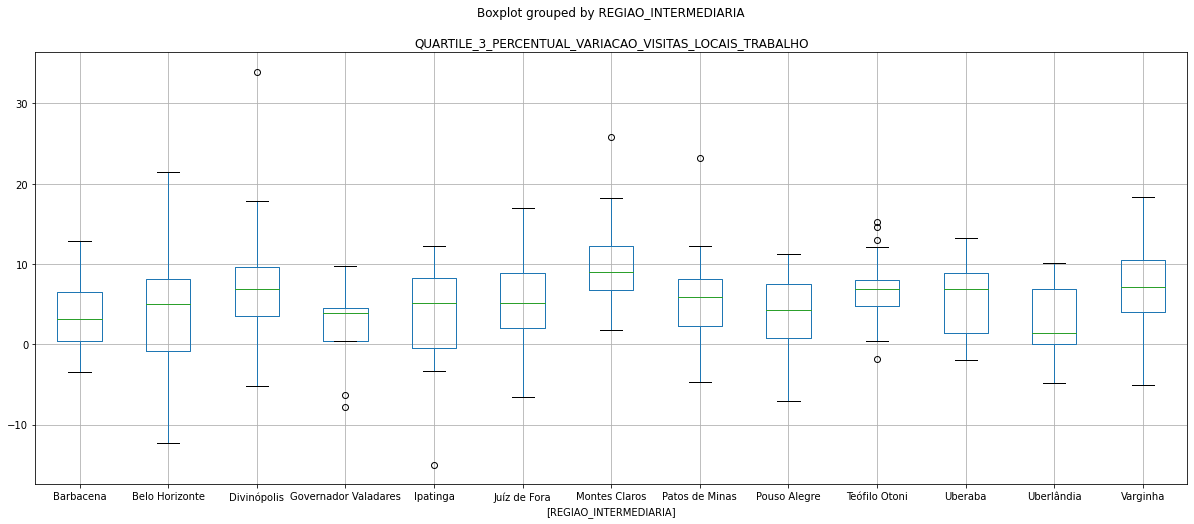

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


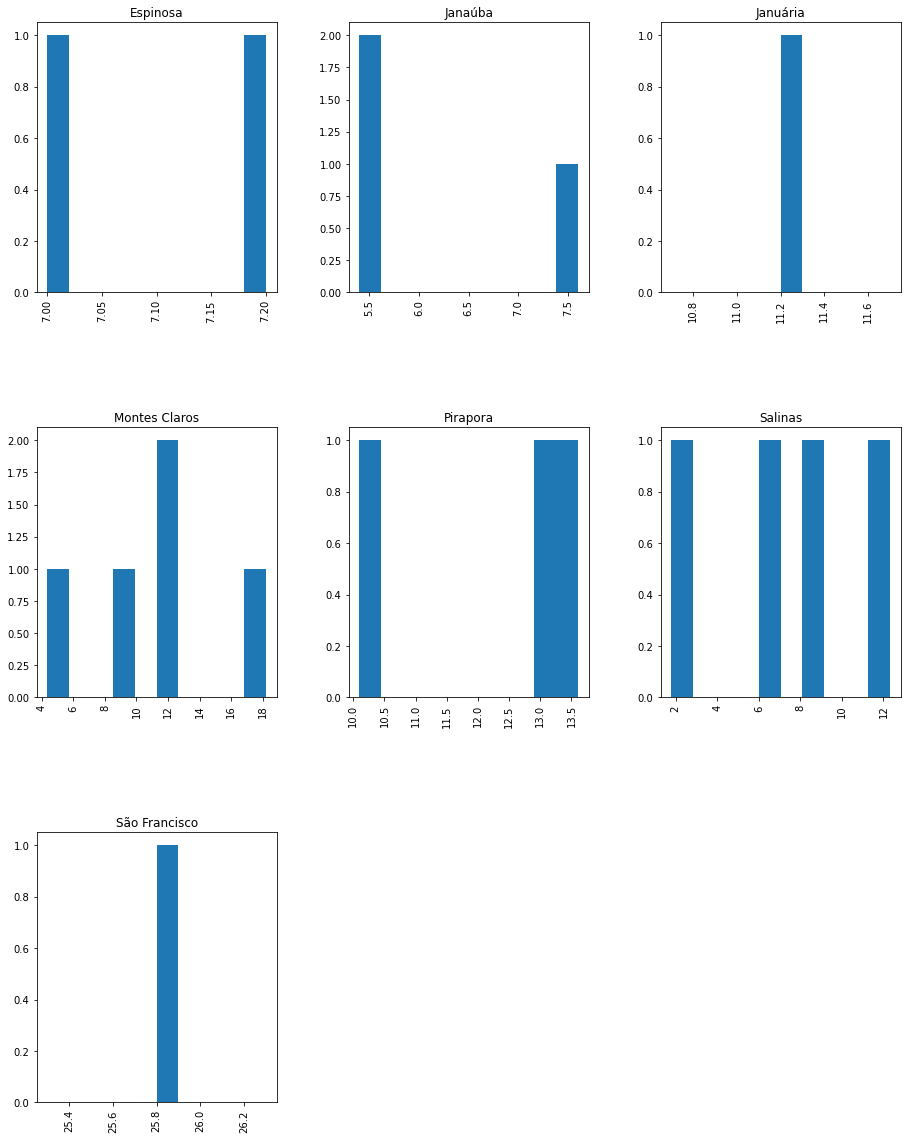

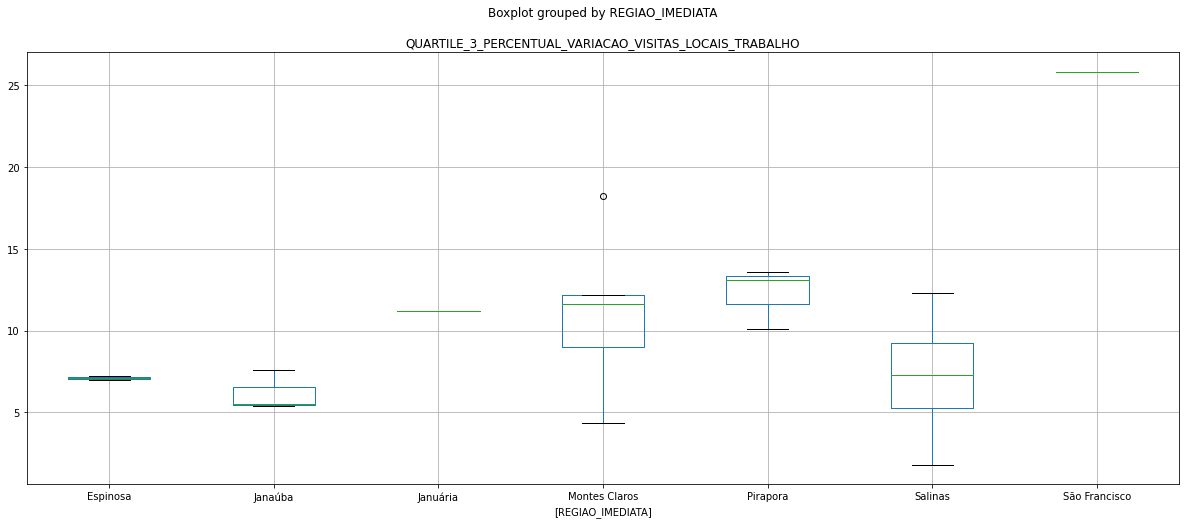

In [43]:
show_analisys_attribute(df_base, 'TAXA_OBITOS')

df_municipio = df_base[['CODIGO_MUNICIPIO_6', 'REGIAO', 'SIGLA_ESTADO', 'REGIAO_INTERMEDIARIA', 'REGIAO_IMEDIATA']]

df_mobilidade_media_visualizacao = pd.merge(df_mobilidade_media, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_media_visualizacao, 'MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

df_mobilidade_mediana_visualizacao = pd.merge(df_mobilidade_mediana, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_mediana_visualizacao, 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

df_mobilidade_3_quartile_visualizacao = pd.merge(df_mobilidade_3_quartile, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_3_quartile_visualizacao, 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

MUNICIPIO CODIGO_MUNICIPIO_6 SIGLA_ESTADO  CODIGO_ESTADO  \
0     Alta Floresta D'Oeste             110001           RO             11   
1                 Ariquemes             110002           RO             11   
2                    Cabixi             110003           RO             11   
3                    Cacoal             110004           RO             11   
4                Cerejeiras             110005           RO             11   
...                     ...                ...          ...            ...   
5565             Vianópolis             522200           GO             52   
5566         Vicentinópolis             522205           GO             52   
5567               Vila Boa             522220           GO             52   
5568          Vila Propício             522230           GO             52   
5569               Brasília             530010           DF             53   

            REGIAO      REGIAO_SAUDE  CODIGO_REGIAO_SAUDE  \
0            Norte      ZONA DA MATA              11005.0   
1            Norte    VALE DO JAMARI              11001.0   
2            Norte          CONE SUL              11006.0   
3            Norte              CAFE              11002.0   
4            Norte          CONE SUL              11006.0   
...            ...               ...                  ...   
5565  Centro-Oeste        CENTRO SUL              52002.0   
5566  Centro-Oeste        CENTRO SUL              52002.0   
5567  Centro-Oeste     ENTORNO NORTE              52003.0   
5568  Centro-Oeste   SAO PATRICIO II              52018.0   
5569  Centro-Oeste  DISTRITO FEDERAL              53001.0   

      REGIAO_METROPOLITANA     CASOS  OBITOS  ...  \
0                      0.0    4057.0      65  ...   
1                      0.0   22501.0     494  ...   
2                      0.0     907.0      21  ...   
3                      0.0   14507.0     302  ...   
4                      0.0    2537.0      61  ...   
...                    ...       ...     ...  ...   
5565                   0.0     974.0      33  ...   
5566                   0.0    1377.0      24  ...   
5567                   0.0     198.0       4  ...   
5568                   0.0     391.0       7  ...   
5569                   1.0  468264.0   10007  ...   

     TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA  \
0                                    157.813728   
1                                     85.417156   
2                                    130.286567   
3                                    157.813728   
4                                    130.286567   
...                                         ...   
5565                                 173.719449   
5566                                  65.840666   
5567                                  63.498111   
5568                                 140.043764   
5569                                 338.145730   

     TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA  \
0                                        120.146254   
1                                         71.323325   
2                                        111.312795   
3                                        120.146254   
4                                        111.312795   
...                                             ...   
5565                                     101.404056   
5566                                      94.271862   
5567                                      71.435375   
5568                                     126.118958   
5569                                     198.191338   

      TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA  \
0                                             12.988784              
1                                             20.927203              
2                                             10.119345              
3                                             12.988784              
4                                             10.119345              
...              

CODIGO_ESTADO  CODIGO_REGIAO_SAUDE  REGIAO_METROPOLITANA  \
count    5570.000000          5570.000000           5570.000000   
mean       32.377738         32403.123698              0.069300   
std         9.833862          9837.224401              0.253986   
min        11.000000         11001.000000              0.000000   
25%        25.000000         25010.000000              0.000000   
50%        31.000000         31059.000000              0.000000   
75%        41.000000         41015.000000              0.000000   
max        53.000000         53001.000000              1.000000   

               CASOS        OBITOS  POPULACAO_ESTIMADA  \
count    5570.000000   5570.000000        5.570000e+03   
mean     3714.094434    103.751885        3.772839e+04   
std     19091.629993    765.152091        2.214581e+05   
min        10.000000      0.000000        7.810000e+02   
25%       450.000000      9.000000        5.446500e+03   
50%       960.000000     20.000000        1.163100e+04   
75%      2355.750000     51.000000        2.549050e+04   
max    938981.000000  37030.000000        1.225202e+07   

       DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO  \
count                               5.570000e+03   
mean                                1.176968e+04   
std                                 7.378126e+04   
min                                 3.190000e+02   
25%                                 1.698500e+03   
50%                                 3.432500e+03   
75%                                 7.373000e+03   
max                                 4.104611e+06   

       DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO  \
count                                        5570.000000       
mean                                          920.600898       
std                                         12945.799490       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             0.000000       
max                                        529921.000000       

       PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO  \
count                                        5570.000000                  
mean                                            1.043896                  
std                                             4.509078                  
min                                             0.000000                  
25%                                             0.000000                  
50%                                             0.000000                  
75%                                             0.000000                  
max                                            73.993700                  

       CODIGO_REGIAO_IMEDIATA  ...  \
count             5570.000000  ...   
mean            323793.462657  ...   
std              98340.639166  ...   
min             110001.000000  ...   
25%             250009.000000  ...   
50%             310039.000000  ...   
75%             410019.000000  ...   
max             530001.000000  ...   

       TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA  \
count                                 5570.000000   
mean                                   141.237603   
std                                     79.544378   
min                                     22.013312   
25%                                     75.856192   
50%                                    123.168115   
75%                                    186.799997   
max                                    490.043880   

       TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA  \
count                                     5570.000000   
mean                                       113.414440   
std                                         33.585401   
min                                         35.609769   
25%                                         88.70453

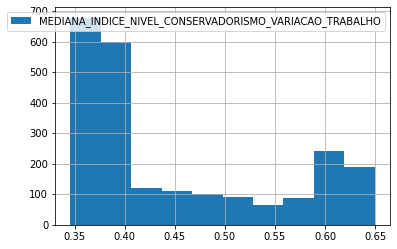

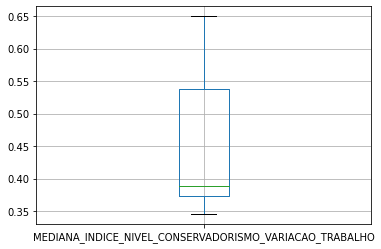

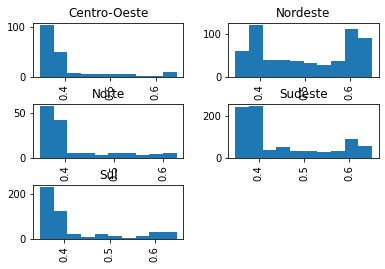

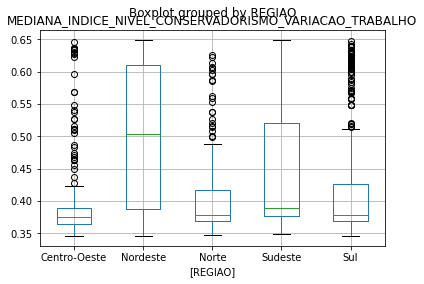

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


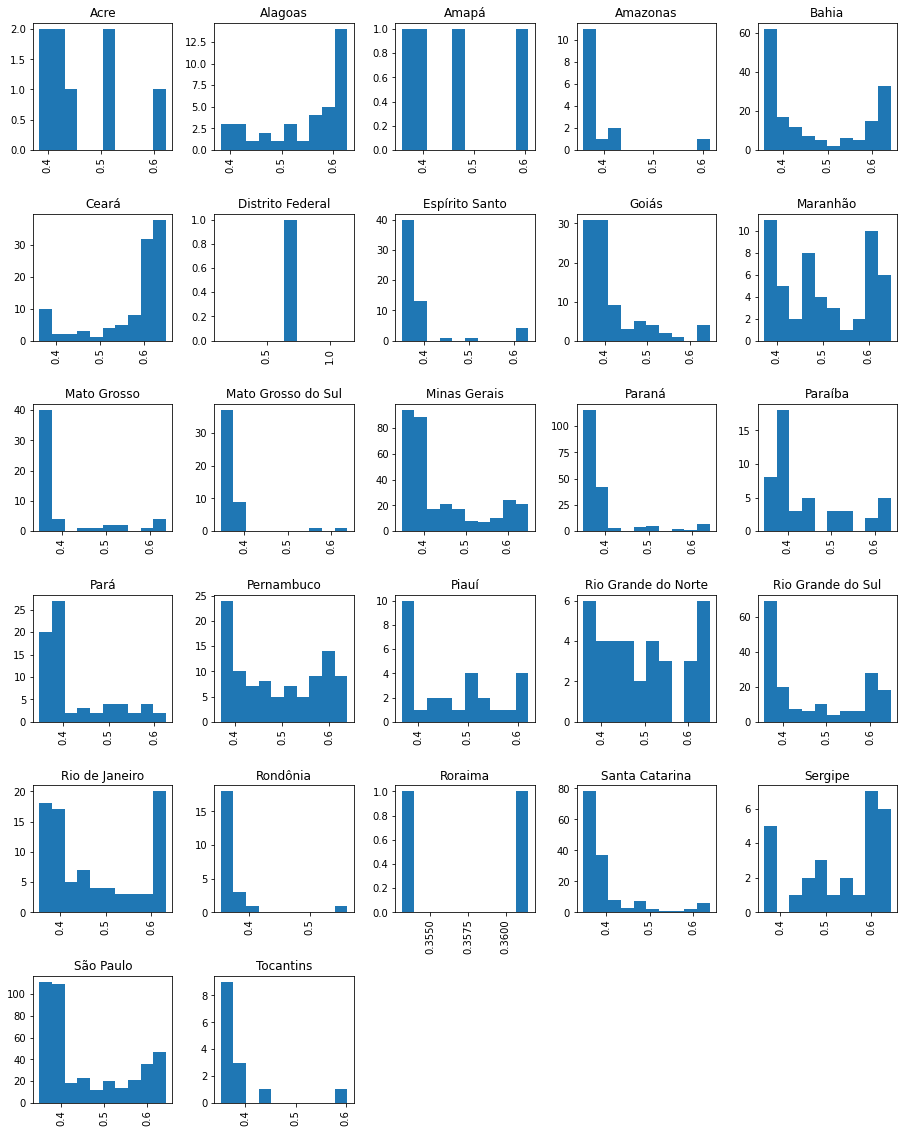

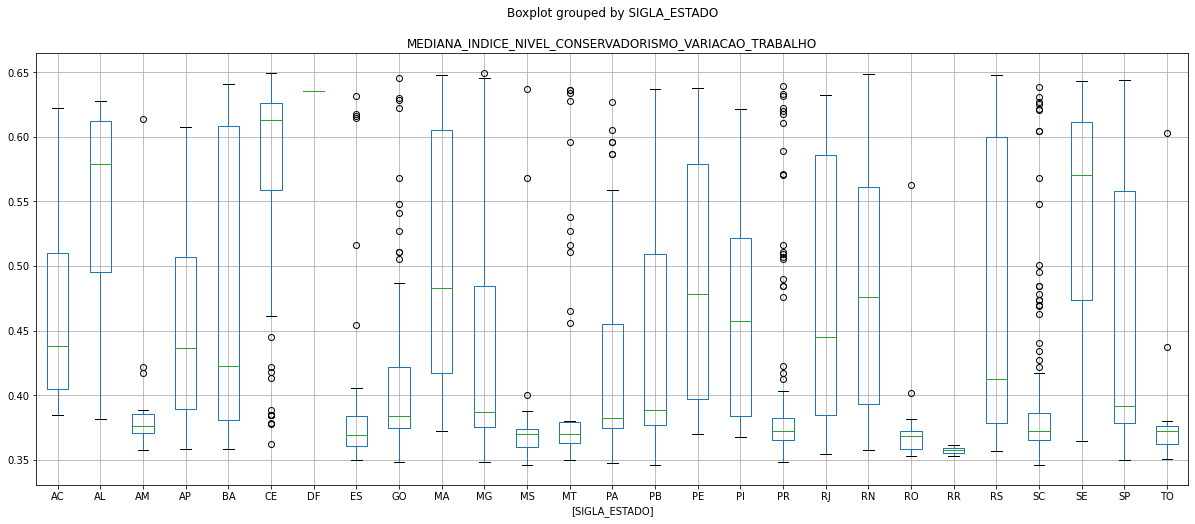

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


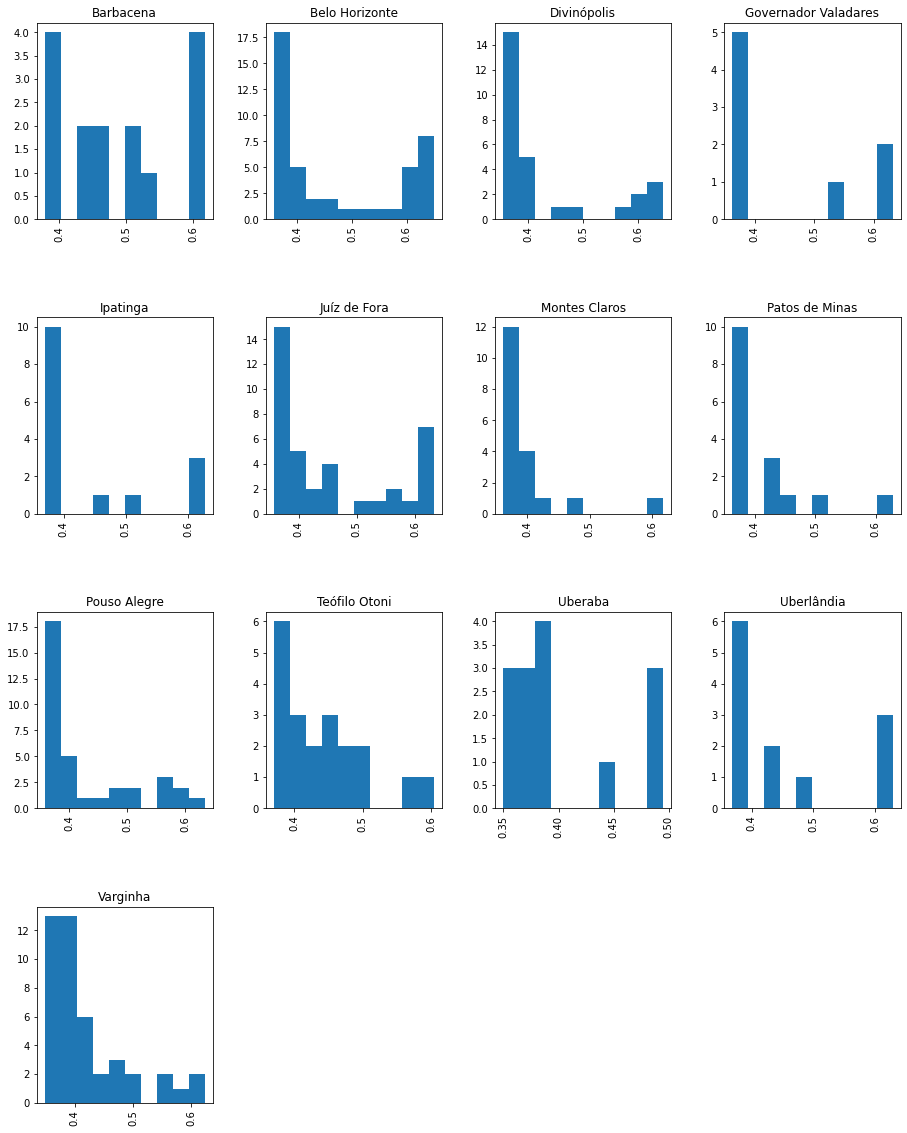

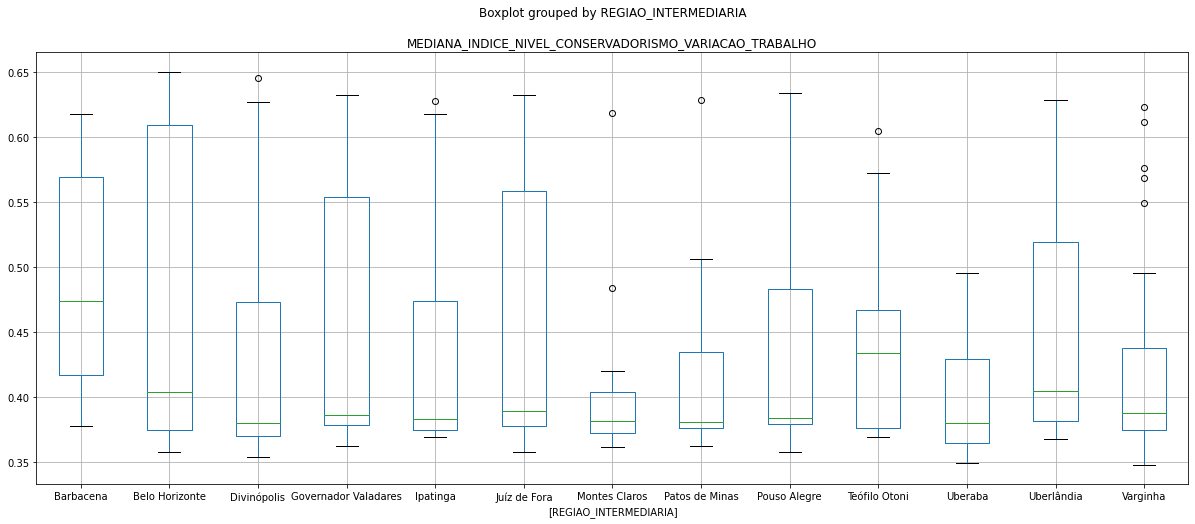

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


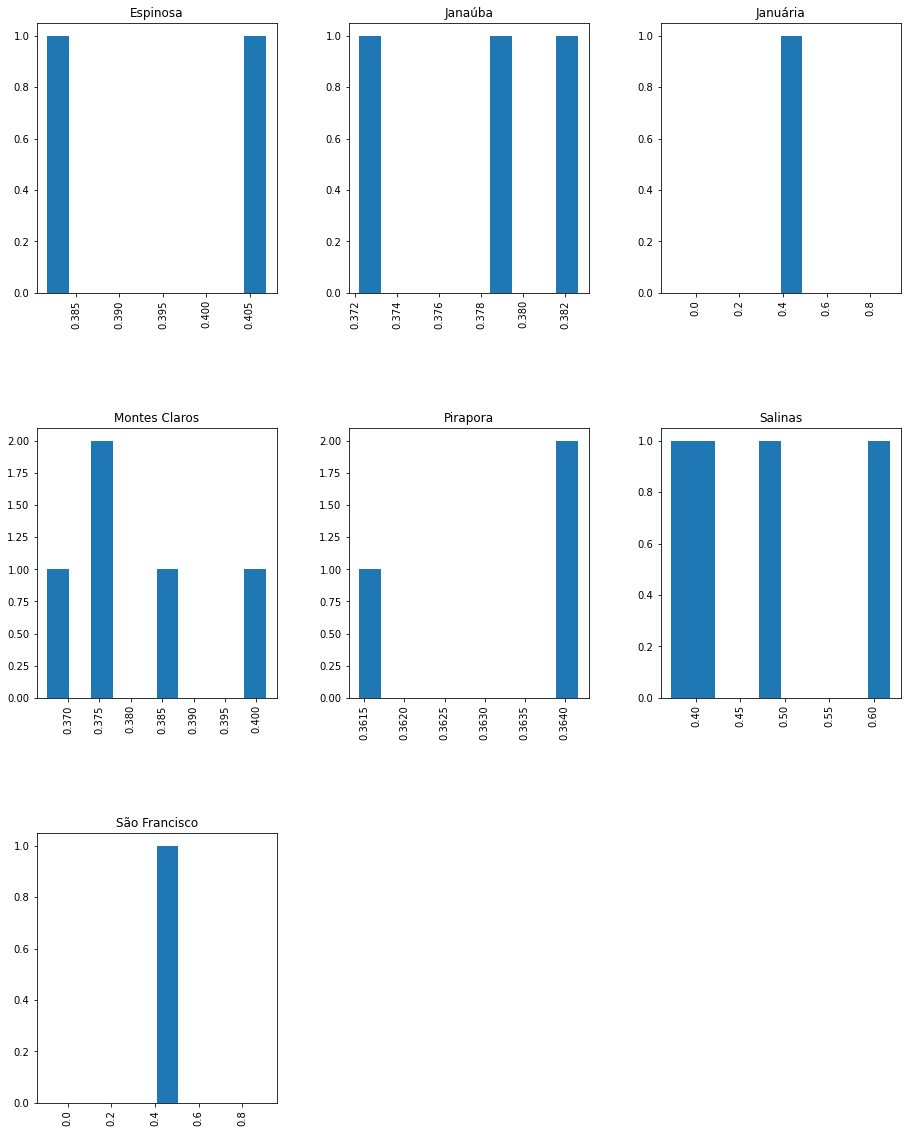

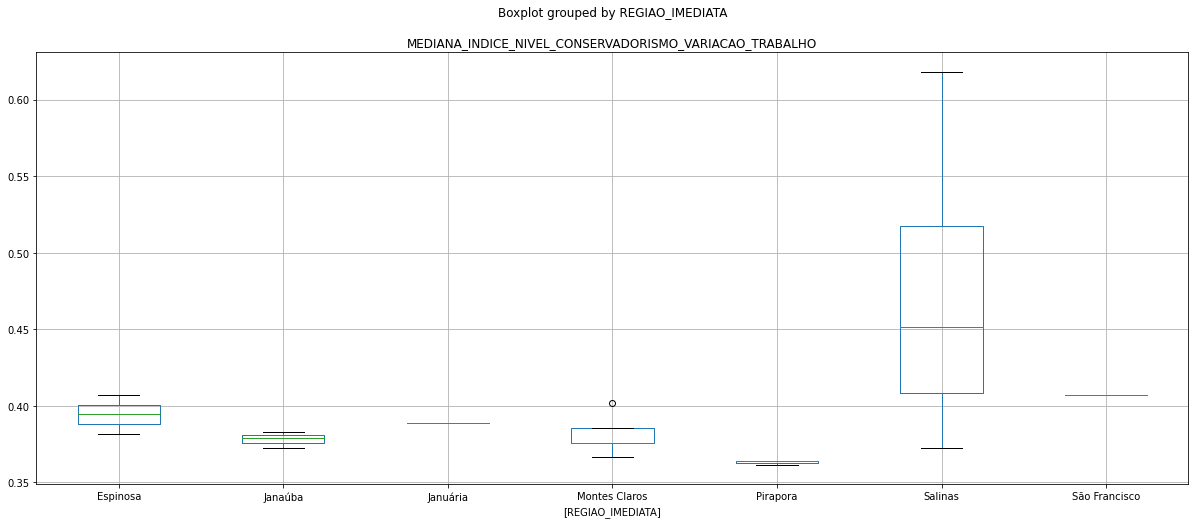

In [44]:
show_analisys_attribute(df_base, 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO')

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/helder/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/helder/.local/lib/python3.8/site-packages/matplotlib/ticker.py:652: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


Text(0, 0.5, 'Taxa óbitos')

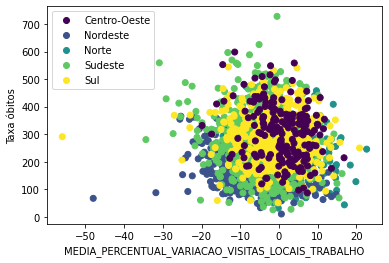

In [45]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

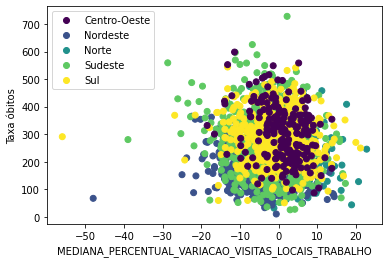

In [46]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

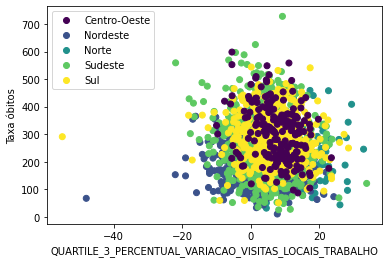

In [47]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base['QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO'], y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

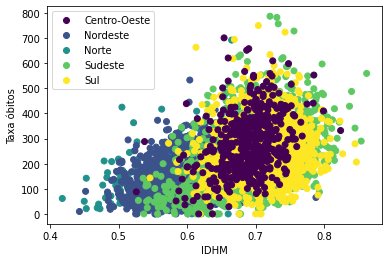

In [48]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.IDHM, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM')
plt.ylabel('Taxa óbitos')


Text(0, 0.5, 'Taxa óbitos')

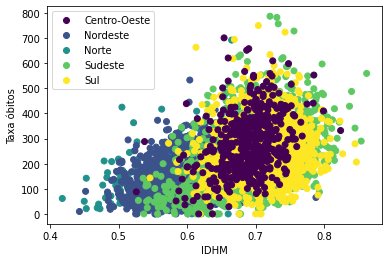

In [49]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.IDHM, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

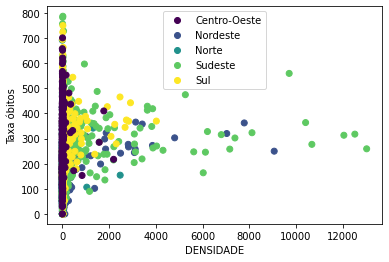

In [50]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.DENSIDADE, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('DENSIDADE')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

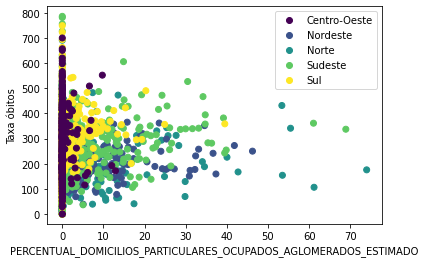

In [51]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

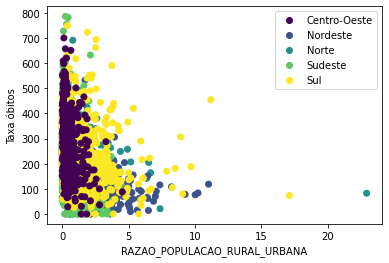

In [52]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.RAZAO_POPULACAO_RURAL_URBANA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('RAZAO_POPULACAO_RURAL_URBANA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

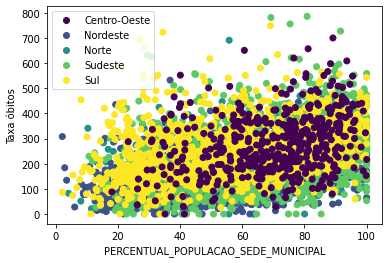

In [53]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_SEDE_MUNICIPAL, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_SEDE_MUNICIPAL')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

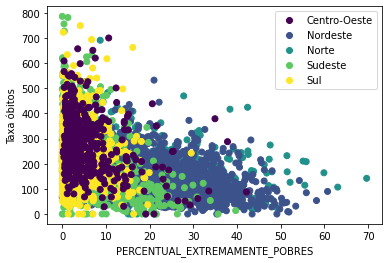

In [54]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_EXTREMAMENTE_POBRES, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_EXTREMAMENTE_POBRES')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

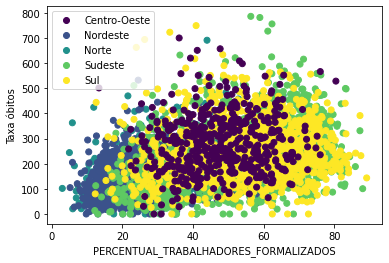

In [55]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_TRABALHADORES_FORMALIZADOS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_TRABALHADORES_FORMALIZADOS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

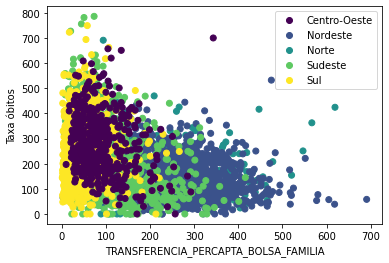

In [56]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

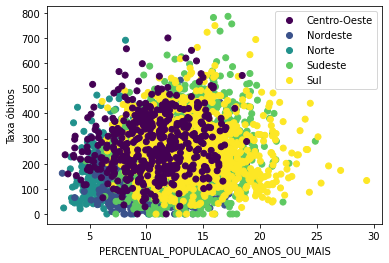

In [57]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

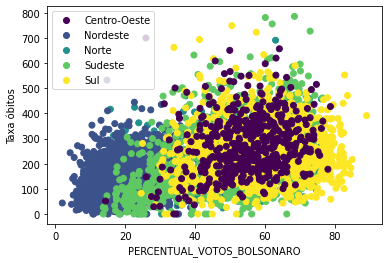

In [58]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_VOTOS_BOLSONARO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_VOTOS_BOLSONARO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

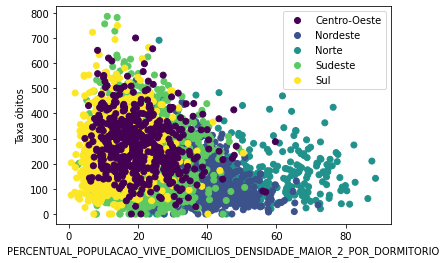

In [59]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

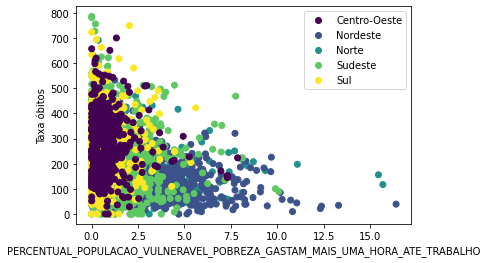

In [60]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

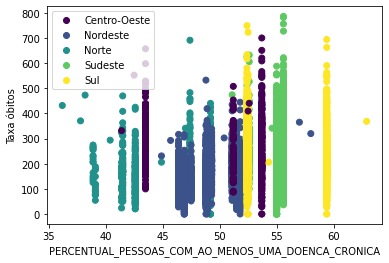

In [61]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

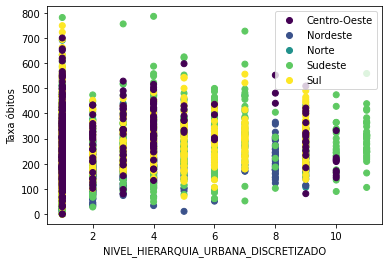

In [62]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('NIVEL_HIERARQUIA_URBANA_DISCRETIZADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

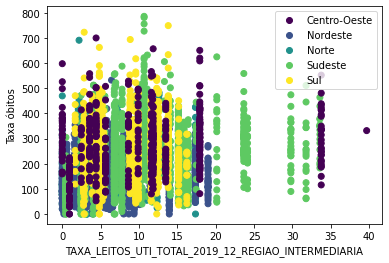

In [63]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

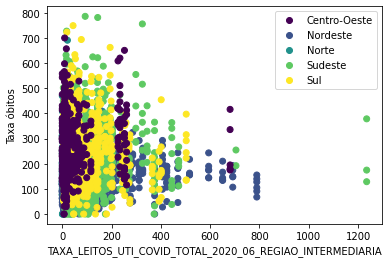

In [64]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

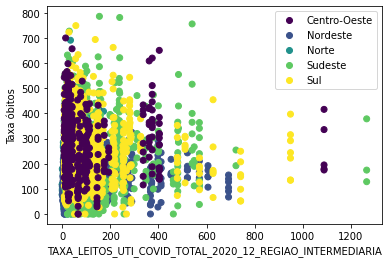

In [65]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

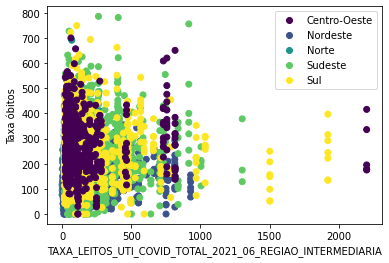

In [66]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([[<AxesSubplot:title={'center':'Capital Regional A'}>,
        <AxesSubplot:title={'center':'Capital Regional B'}>,
        <AxesSubplot:title={'center':'Capital Regional C'}>],
       [<AxesSubplot:title={'center':'Centro Local'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional A'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional B'}>],
       [<AxesSubplot:title={'center':'Centro de Zona A'}>,
        <AxesSubplot:title={'center':'Centro de Zona B'}>,
        <AxesSubplot:title={'center':'Grande Metrópole Nacional'}>],
       [<AxesSubplot:title={'center':'Metrópole'}>,
        <AxesSubplot:title={'center':'Metrópole Nacional'}>,
        <AxesSubplot:>]], dtype=object)

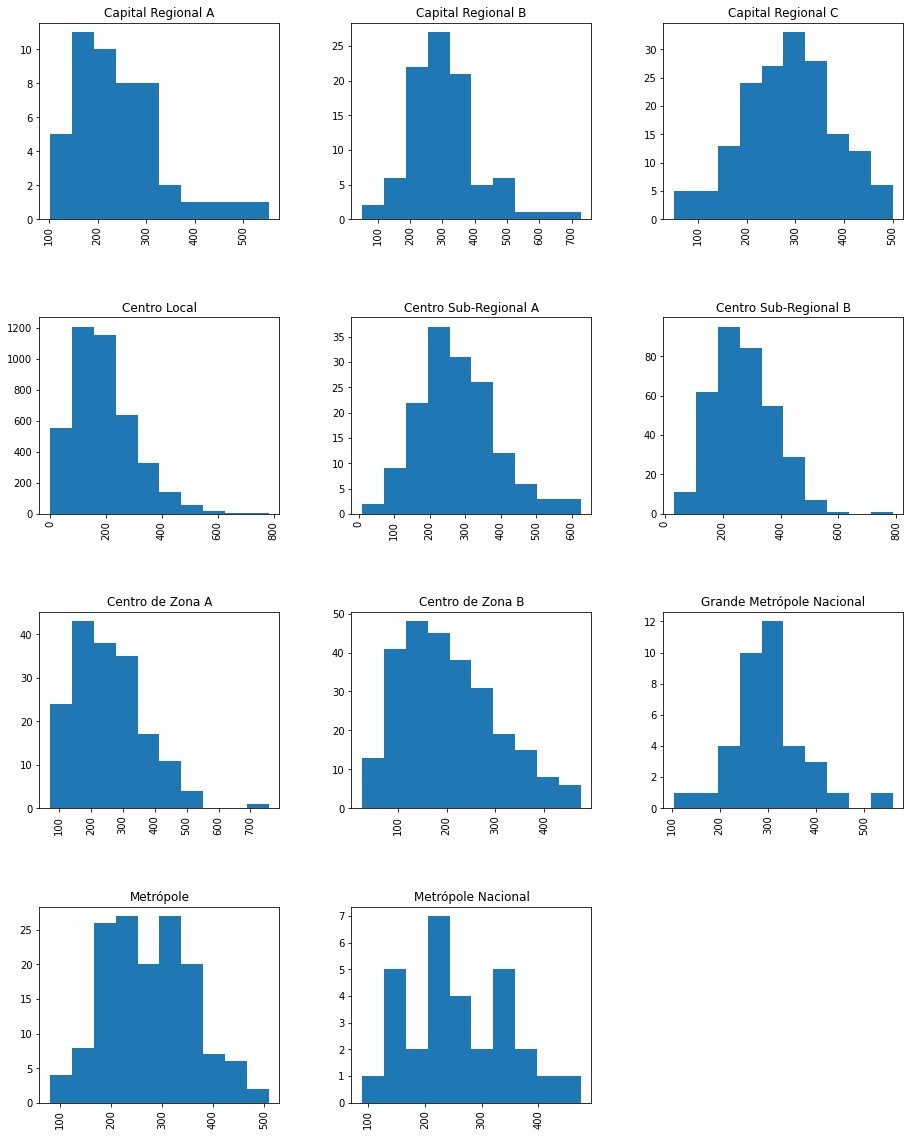

In [67]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_base.TAXA_OBITOS.hist(by=df_base.HIERARQUIA_URBANA, ax=ax)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[HIERARQUIA_URBANA]'>

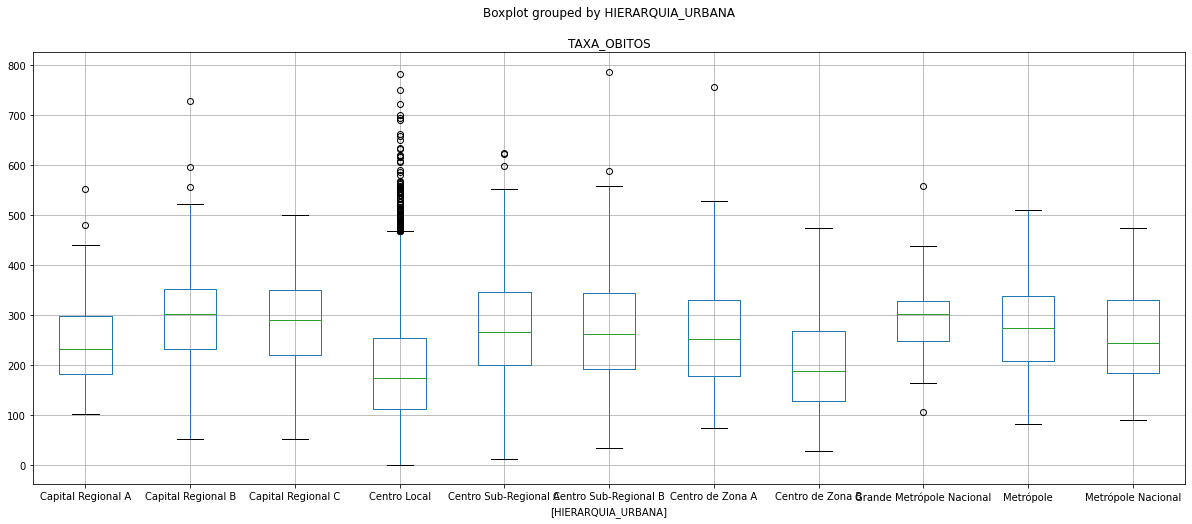

In [68]:
df_base[["TAXA_OBITOS",'HIERARQUIA_URBANA']].boxplot(by='HIERARQUIA_URBANA', figsize=(20,8))

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[NIVEL_HIERARQUIA_URBANA_DISCRETIZADO]'>

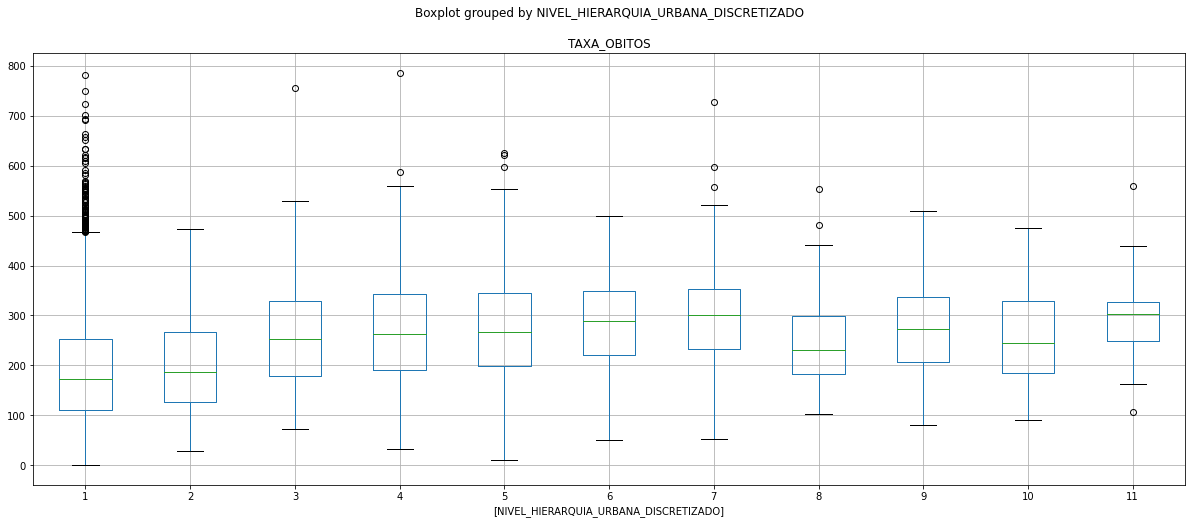

In [69]:
df_base[["TAXA_OBITOS",'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO']].boxplot(by='NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', figsize=(20,8))

In [70]:
df_base[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 4].sum().POPULACAO_ESTIMADA / df_base.sum().POPULACAO_ESTIMADA * 100

69.86338690096284

In [71]:
df_base.groupby('HIERARQUIA_URBANA').count().POPULACAO_ESTIMADA

HIERARQUIA_URBANA
Capital Regional A             48
Capital Regional B             92
Capital Regional C            168
Centro Local                 4115
Centro Sub-Regional A         151
Centro Sub-Regional B         345
Centro de Zona A              173
Centro de Zona B              264
Grande Metrópole Nacional      37
Metrópole                     147
Metrópole Nacional             30
Name: POPULACAO_ESTIMADA, dtype: int64

In [72]:
df_hierarquia_urbana_brasil = df_base.groupby('HIERARQUIA_URBANA').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_hierarquia_urbana_brasil['TAXA_OBITOS'] = df_hierarquia_urbana_brasil.OBITOS / df_hierarquia_urbana_brasil.POPULACAO_ESTIMADA * 100000
print(df_hierarquia_urbana_brasil)

                           OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
HIERARQUIA_URBANA                                                 
Capital Regional A          31941             9918266   322.042180
Capital Regional B          40084            12955894   309.388144
Capital Regional C          61232            19542042   313.334707
Centro Local                94015            51038490   184.204117
Centro Sub-Regional A       33225            11555268   287.531194
Centro Sub-Regional B       49855            18260630   273.019058
Centro de Zona A            15291             6150831   248.600555
Centro de Zona B            12014             6141905   195.607063
Grande Metrópole Nacional   68029            21673440   313.881876
Metrópole                  113059            36142341   312.815930
Metrópole Nacional          59153            16768018   352.772761


In [73]:
df_hierarquia_urbana_brasil_mean = df_base.groupby('HIERARQUIA_URBANA').mean()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_mean.columns = ['TAXA_OBITOS_MEDIA']
df_hierarquia_urbana_brasil_std = df_base.groupby('HIERARQUIA_URBANA').std()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_std.columns = ['TAXA_OBITOS_DESVIO_PADRAO']
df_hierarquia_urbana_brasil = pd.merge(df_hierarquia_urbana_brasil_mean, df_hierarquia_urbana_brasil_std, left_index=True, right_index=True)
print(df_hierarquia_urbana_brasil)

                           TAXA_OBITOS_MEDIA  TAXA_OBITOS_DESVIO_PADRAO
HIERARQUIA_URBANA                                                      
Capital Regional A                248.050284                  92.029852
Capital Regional B                308.448243                 105.879825
Capital Regional C                285.718193                  95.080357
Centro Local                      192.163479                 110.954311
Centro Sub-Regional A             278.247784                 111.796648
Centro Sub-Regional B             272.734771                 107.954469
Centro de Zona A                  258.365390                 109.751624
Centro de Zona B                  204.211244                  97.514632
Grande Metrópole Nacional         300.059889                  81.235885
Metrópole                         276.100087                  85.448548
Metrópole Nacional                255.921555                  90.440288


In [74]:
df_base.groupby('HIERARQUIA_URBANA').count()[['TAXA_OBITOS', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]

TAXA_OBITOS  \
HIERARQUIA_URBANA                        
Capital Regional A                  48   
Capital Regional B                  92   
Capital Regional C                 168   
Centro Local                      4115   
Centro Sub-Regional A              151   
Centro Sub-Regional B              345   
Centro de Zona A                   173   
Centro de Zona B                   264   
Grande Metrópole Nacional           37   
Metrópole                          147   
Metrópole Nacional                  30   

                           MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
HIERARQUIA_URBANA                                                                
Capital Regional A                                                        39     
Capital Regional B                                                        77     
Capital Regional C                                                       138     
Centro Local                                                            1038     
Centro Sub-Regional A                                                    130     
Centro Sub-Regional B                                                    301     
Centro de Zona A                                                         156     
Centro de Zona B                                                         197     
Grande Metrópole Nacional                                                 37     
Metrópole                                                                142     
Metrópole Nacional                                                        30     

                           QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
HIERARQUIA_URBANA                                                                      
Capital Regional A                                                        19           
Capital Regional B                                                        46           
Capital Regional C                                                        85           
Centro Local                                                             113           
Centro Sub-Regional A                                                     85           
Centro Sub-Regional B                                                    148           
Centro de Zona A                                                          43           
Centro de Zona B                                                          18           
Grande Metrópole Nacional                                                 36           
Metrópole                                                                 94           
Metrópole Nacional                                                        23           

                           MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS  
HIERARQUIA_URBANA                                                               
Capital Regional A                                                        31    
Capital Regional B                                                        58    
Capital Regional C                                                       110    
Centro Local                                                             186    
Centro Sub-Regional A                                                    107    
Centro Sub-Regional B                                                    266    
Centro de Zona A                                                         122    
Centro de Zona B                                                          32    
Grande Metrópole Nacional                                                 35    
Metrópole                                                                114    
Metrópole Nacional                                                        30

In [75]:
df_base.groupby('CAPITAL').count()[['TAXA_OBITOS', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]

TAXA_OBITOS  MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO  \
CAPITAL                                                                     
0               5543                                               2258     
1                 27                                                 27     

         QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE  \
CAPITAL                                                              
0                                                      683           
1                                                       27           

         MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS  
CAPITAL                                                       
0                                                     1064    
1                                                       27

In [76]:
df_base.groupby('HIERARQUIA_URBANA').mean()[['TAXA_OBITOS', 'POPULACAO_ESTIMADA', 'IDHM']]

TAXA_OBITOS  POPULACAO_ESTIMADA      IDHM
HIERARQUIA_URBANA                                                   
Capital Regional A          248.050284       206630.541667  0.678125
Capital Regional B          308.448243       140824.934783  0.746152
Capital Regional C          285.718193       116321.678571  0.735500
Centro Local                192.163479        12403.035237  0.641924
Centro Sub-Regional A       278.247784        76524.953642  0.729106
Centro Sub-Regional B       272.734771        52929.362319  0.709928
Centro de Zona A            258.365390        35553.936416  0.701902
Centro de Zona B            204.211244        23264.791667  0.656098
Grande Metrópole Nacional   300.059889       585768.648649  0.762000
Metrópole                   276.100087       245866.265306  0.719633
Metrópole Nacional          255.921555       558933.933333  0.716767

In [77]:
#Será considerado a mobilidade apenas de municípios de maior centralidade (Hierarquia urbana >= Centro Sub-regionais)
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO <= 3,
            ['MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
             'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
             'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']] = None

#### Removing outliers

In [78]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#### Análise da correlação de vários atributos


In [79]:
df = df_base[
    [ 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', 'REGIAO_METROPOLITANA', 'CAPITAL', 'POPULACAO_ESTIMADA',
      'PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS', 'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'DENSIDADE',
      'RAZAO_POPULCAO_DOMICILIOS_ESTIMADA', 'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
      'DENSIDADE_DEMOGRAFICA_AGLOMERADOS', 'DENSIDADE_DOMICILIOS_AGLOMERADOS','TAXA_FECUNDIDADE',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO','RAZAO_POPULACAO_MASCULINA_FEMININA',
     'RAZAO_POPULACAO_RURAL_URBANA', 'PERCENTUAL_POPULACAO_URBANA', 'PERCENTUAL_POPULACAO_SEDE_MUNICIPAL',
     'DENSIDADE_DOMICILIOS', 'PERCENTUAL_DOMICILIOS_AGLOMERADOS', 'PERCENTUAL_POPULACAO_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_ESTIMADA', 'IDHM', 'IDHM_EDUCACAO', 'IDHM_LONGEVIDADE', 'IDHM_RENDA', 'GINI',
     'PERCENTUAL_EXTREMAMENTE_POBRES', 'PERCENTUAL_POBRES',
     'PERCENTUAL_VULNERAVEIS_POBREZA', 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
     'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES', 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES',
     'RENDA_PER_CAPTA_MEDIA_POBRES', 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA', 'THEIL', 'RAZAO_DEPENDENCIA',
     'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_CONSTRUCAO', 'PERCENTUAL_OCUPADOS_MINERACAO', 'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA', 'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS', 'PERCENTUAL_OCUPADOS_SEM_RENDA', 'TAXA_ATIVIDADE', 'TAXA_DESOCUPACAO',
     'PERCENTUAL_TRABALHADORES_PUBLICOS', 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO', 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
     'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE', 'PERCENTUAL_AVC', 'PERCENTUAL_COLESTEROL_ALTO',
     'PERCENTUAL_DOENCA_CORACAO', 'PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA', 'PERCENTUAL_HIPERTENSAO',
     'PERCENTUAL_AUTO_AVALIACAO_POSITIVA_SAUDE', 'PERCENTUAL_ASMA', 'PERCENTUAL_CANCER',
     'PERCENTUAL_INSUFICIENCIA_RENAL_CRONICA', 'PERCENTUAL_DIABETES',  'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2020_06_REGIAO_INTERMEDIARIA',  'TAXA_LEITOS_INTERNACAO_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_MEDICOS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
       'TAXA_ENFERMEIROS_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO', 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
      'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
      'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
      'PERCENTUAL_VOTOS_BOLSONARO', 'PERCENTUAL_VOTOS_HADDAD','TAXA_CASOS', 'TAXA_LETALIDADE', 'TAXA_OBITOS']]


In [80]:
df_correlation = df.corr(method="spearman")

df_correlation_pvalue = pd.DataFrame(columns=['correlation_pearson', 'pvalue_pearson', 'correlation_spearman', 'pvalue_spearman'])
for column in df:
    if pd.api.types.is_numeric_dtype(df[column]) and column != 'TAXA_OBITOS':
        has_null_values = np.logical_or(df.TAXA_OBITOS.isnull(), df[column].isnull())
        correlation_pearson, pvalue_pearson = stats.pearsonr(df[~has_null_values].TAXA_OBITOS, df[~has_null_values][column])
        correlation_spearman, pvalue_spearman = stats.spearmanr(df[~has_null_values].TAXA_OBITOS, df[~has_null_values][column])
        df_correlation_pvalue.loc[column] = [round(correlation_pearson, 4), round(pvalue_pearson, 4),
                                             round(correlation_spearman, 4), round(pvalue_spearman, 4)]


#### Atributos selecionados para agrupamento

In [81]:
df_atributos_selecionados = df_base[
    ['PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS',
      'PERCENTUAL_POPULACAO_15_A_24_ANOS',
      'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS',
      'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
     'PERCENTUAL_POPULACAO_URBANA',
      'RAZAO_POPULCAO_DOMICILIOS_ESTIMADA',
     'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
     'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA',
     'IDHM_RENDA',
      'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
      'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
     'PERCENTUAL_TRABALHADORES_INFORMAIS',
      'PERCENTUAL_OCUPADOS_SEM_RENDA',
      'TAXA_ATIVIDADE',
      'PERCENTUAL_OCUPADOS_AGROPECUARIA',
      'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
     'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO',
     'PERCENTUAL_VOTOS_BOLSONARO',
     'TAXA_CASOS',
     'TAXA_LETALIDADE',
     'TAXA_OBITOS']]

In [82]:
df_correlation = df_atributos_selecionados.corr(method="spearman")

df_correlation_pvalue = pd.DataFrame(columns=['correlation_pearson', 'pvalue_pearson', 'correlation_spearman', 'pvalue_spearman'])
for column in df_atributos_selecionados:
    if pd.api.types.is_numeric_dtype(df_atributos_selecionados[column]) and column != 'TAXA_OBITOS':
        has_null_values = np.logical_or(df_atributos_selecionados.TAXA_OBITOS.isnull(), df_atributos_selecionados[column].isnull())
        correlation_pearson, pvalue_pearson = stats.pearsonr(df_atributos_selecionados[~has_null_values].TAXA_OBITOS, df_atributos_selecionados[~has_null_values][column])
        correlation_spearman, pvalue_spearman = stats.spearmanr(df_atributos_selecionados[~has_null_values].TAXA_OBITOS, df_atributos_selecionados[~has_null_values][column])
        df_correlation_pvalue.loc[column] = [round(correlation_pearson, 4), round(pvalue_pearson, 4),
                                             round(correlation_spearman, 4), round(pvalue_spearman, 4)]

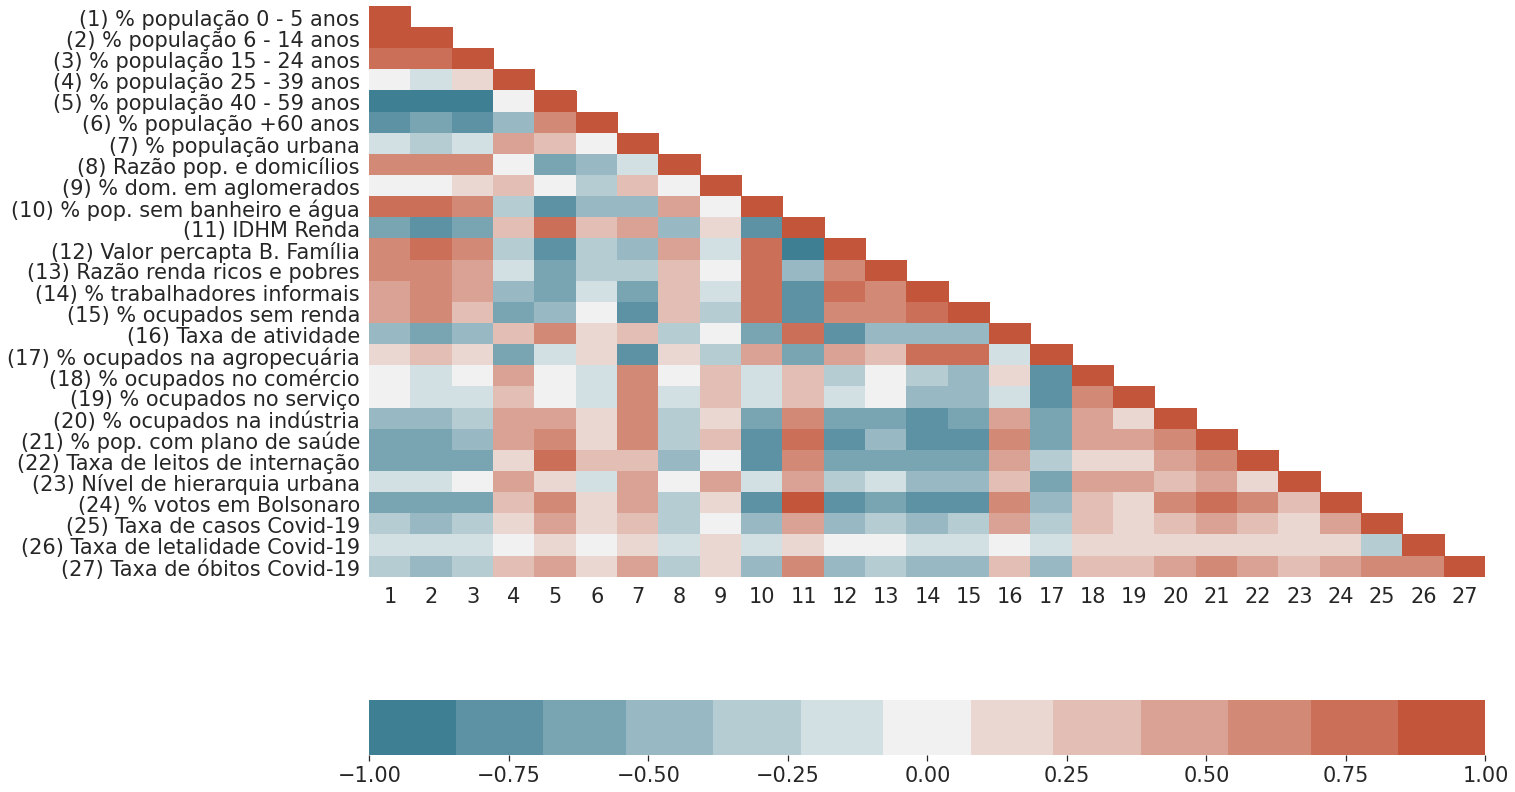

In [83]:
yticklabels = [
    '(1) % população 0 - 5 anos',
    '(2) % população 6 - 14 anos',
    '(3) % população 15 - 24 anos',
    '(4) % população 25 - 39 anos',
    '(5) % população 40 - 59 anos',
    '(6) % população +60 anos',
    '(7) % população urbana',
    '(8) Razão pop. e domicílios',
    '(9) % dom. em aglomerados',
    '(10) % pop. sem banheiro e água',
    '(11) IDHM Renda',
    '(12) Valor percapta B. Família',
    '(13) Razão renda ricos e pobres',
    '(14) % trabalhadores informais',
    '(15) % ocupados sem renda',
    '(16) Taxa de atividade',
    '(17) % ocupados na agropecuária',
    '(18) % ocupados no comércio',
    '(19) % ocupados no serviço',
    '(20) % ocupados na indústria',
    '(21) % pop. com plano de saúde',
    '(22) Taxa de leitos de internação',
    '(23) Nível de hierarquia urbana',
    '(24) % votos em Bolsonaro',
    '(25) Taxa de casos Covid-19',
    '(26) Taxa de letalidade Covid-19',
    '(27) Taxa de óbitos Covid-19']

xticklabels = [
    '1',
      '2',
      '3',
      '4',
      '5',
      '6',
     '7',
     '8',
     '9',
     '10',
     '11',
     '12',
      '13',
      '14',
     '15',
      '16',
      '17',
      '18',
      '19',
     '20',
     '21',
     '22',
     '23',
      '24',
      '25',
     '26',
     '27']
sns.set(font_scale=1.9)
mask = np.zeros_like(df_correlation)
mask[np.triu_indices_from(mask, k=1)] = True
palette = sns.diverging_palette(220, 20, n=13)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(df_correlation, vmin=-1, vmax=1, center=0, square=False, mask=mask, cmap=palette,
                     yticklabels=yticklabels, xticklabels=xticklabels,
                     cbar_kws={"orientation": "horizontal"}, cbar=True)
    plt.xticks(rotation=0)
    f.savefig('images/correlacao_heat_map.pdf', bbox_inches="tight")

In [84]:
df_antecedent = df_base[
    ['PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS',
      'PERCENTUAL_POPULACAO_15_A_24_ANOS',
      'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS',
      'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
     'PERCENTUAL_POPULACAO_URBANA',
      'RAZAO_POPULCAO_DOMICILIOS_ESTIMADA',
     'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
     'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA',
     'IDHM_RENDA',
      'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
      'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
     'PERCENTUAL_TRABALHADORES_INFORMAIS',
      'PERCENTUAL_OCUPADOS_SEM_RENDA',
      'TAXA_ATIVIDADE',
      'PERCENTUAL_OCUPADOS_AGROPECUARIA',
      'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA']]

df_base_antecedent = df_base.copy()
df_null = df_antecedent.isnull().any(axis=1)
df_base_antecedent = df_base_antecedent[df_null == False]
df_antecedent = df_antecedent[df_null == False]

df_base_antecedent = df_base_antecedent.reset_index()
df_base_antecedent = df_base_antecedent.drop(columns=['index'])

df_antecedent = df_antecedent.reset_index()
df_antecedent = df_antecedent.drop(columns=['index'])

df_consequent = df_base_antecedent[['TAXA_OBITOS', 'TAXA_CASOS', 'TAXA_LETALIDADE']]

##### Normalizing data

In [85]:
scaler_antecedents = preprocessing.MinMaxScaler()
antecedents_normalized = scaler_antecedents.fit_transform(df_antecedent.values)
df_antecedents_normalized = pd.DataFrame(antecedents_normalized, columns=df_antecedent.columns)

scaler_concequents = preprocessing.MinMaxScaler()
concequents_normalized = scaler_concequents.fit_transform(df_consequent.values)
df_concequents_normalized = pd.DataFrame(concequents_normalized, columns=df_consequent.columns)

##### Executing fcmenas

In [86]:
m = 2
epsilon = 10 ** (-4)

def plot_clusters(centers, u, x_not_normalized, y_not_normalized, df_not_normalized, scaler):
    sns.set(font_scale=1)
    cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization
    fig, ax = plt.subplots()

    for j in range(len(centers)):
        ax.plot(x_not_normalized.values[cluster_membership == j],
                y_not_normalized.values[cluster_membership == j], '.', label="Cluster " + str(j))
        ax.set_xlabel(x_not_normalized.name)
        ax.set_ylabel(y_not_normalized.name)
    ax.legend()

    # centers_not_normalized = scaler.inverse_transform(centers)
    # xi = df_not_normalized.columns.get_loc(x_not_normalized.name)
    # yi = df_not_normalized.columns.get_loc(y_not_normalized.name)
    # for pt in centers_not_normalized:
    #     ax.plot(pt[xi], pt[yi], 'rs')

    plt.show()


def describe_clusters(centers, u, df_not_normalized):
    cluster_membership = np.argmax(u, axis=0)
    for j in range(len(centers)):
        print("===================Cluster {0}==================".format(j))
        for column  in df_not_normalized.columns:
            print(df_not_normalized[cluster_membership == j][column].describe())
            print("\n")


def show_results(ra, centers, u, fpc, df_not_normalized, scaler, df_analysis):
    if ra is not None:
        print('RA = {0} - Subtractive Centers = {1}; FPC = {2:.2f}'.format(ra, len(centers), fpc))
    else:
        print('Centers = {0}; FPC = {1:.2f}'.format(len(centers), fpc))
    attributes = df_not_normalized.columns

    # for i in range(len(attributes) - 1):
    #     for j in range(i + 1, len(attributes)):
    #         plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]],
    #                       df_not_normalized, scaler)
    j = randrange(len(attributes))
    plot_clusters(centers, u, df_analysis['TAXA_OBITOS'], df_not_normalized[attributes[j]], df_not_normalized,
                  scaler)

    print("Describing results")
    describe_clusters(centers, u, df_analysis)

    print("Describing clusters")
    describe_clusters(centers, u, df_not_normalized)

In [87]:
df_analysis = df_base_antecedent[['TAXA_OBITOS', 'TAXA_CASOS', 'TAXA_LETALIDADE']]

In [88]:
# centers_2, u_2, u0, d, jm, p, fpc_2 = cluster.cmeans(
#     df_antecedents_normalized.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

In [89]:
centers_2, u_2, u0, d, jm, p, fpc_2 = cluster.cmeans(
    df_antecedents_normalized.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
    subtractive_clustering_influence_range=0.87)

In [316]:
# list_ra = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
#
# for ra in list_ra:
#     centers_2, u_2, u0, d, jm, p, fpc_2 = cluster.cmeans(
#         df_antecedents_normalized.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#         subtractive_clustering_influence_range=ra)
#     print('RA = {0} - Subtractive Centers = {1}; FPC = {2:.2f}'.format(ra, len(centers_2), fpc_2))

RA = 0.125 - Subtractive Centers = 14; FPC = 0.12
RA = 0.25 - Subtractive Centers = 4; FPC = 0.40
RA = 0.375 - Subtractive Centers = 5; FPC = 0.32
RA = 0.5 - Subtractive Centers = 4; FPC = 0.40
RA = 0.625 - Subtractive Centers = 3; FPC = 0.50
RA = 0.75 - Subtractive Centers = 2; FPC = 0.69
RA = 0.875 - Subtractive Centers = 2; FPC = 0.69


Centers = 2; FPC = 0.69


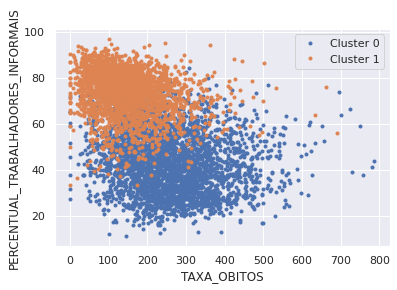

Describing results
===================Cluster 0==================
count    3139.000000
mean      259.387823
std       110.869049
min         0.000000
25%       179.918831
50%       249.500998
75%       327.807801
max       786.672837
Name: TAXA_OBITOS, dtype: float64


count     3139.000000
mean     11219.468149
std       4307.807068
min        776.644521
25%       8290.955432
50%      10948.323118
75%      13775.193173
max      47693.893326
Name: TAXA_CASOS, dtype: float64


count    3139.000000
mean        2.570872
std         1.496360
min         0.000000
25%         1.685110
50%         2.333333
75%         3.127878
max        31.325301
Name: TAXA_LETALIDADE, dtype: float64


===================Cluster 1==================
count    2426.000000
mean      147.386741
std        82.471905
min         0.000000
25%        88.092453
50%       135.931316
75%       190.088259
max       691.562932
Name: TAXA_OBITOS, dtype: float64


count     2426.000000
mean      7850.486502
std       4221.9

In [90]:
show_results(None, centers_2, u_2, fpc_2, df_antecedent, scaler_antecedents, df_analysis)

In [91]:
colunas_analise = df_atributos_selecionados.columns.values
colunas_analise = np.append(colunas_analise, ['MUNICIPIO', 'HIERARQUIA_URBANA'])
df_analise_agrupamentos = df_base_antecedent[colunas_analise].copy()

In [92]:
df_u_2 = pd.DataFrame(u_2).T
df_u_2.columns = ['GRUPO_MAIS_DESENVOLVIDOS', 'GRUPO_MENOS_DESENVOLVIDOS']
df_u_2.describe()
df_u_2['GRUPO'] = 'Desenvolvimento intermediário'

In [93]:
df_u_2.loc[df_u_2.GRUPO_MAIS_DESENVOLVIDOS >= 0.55, 'GRUPO'] = 'Mais desenvolvidos'
df_u_2.loc[df_u_2.GRUPO_MENOS_DESENVOLVIDOS >= 0.55, 'GRUPO'] = 'Menos desenvolvidos'
df_analise_agrupamentos['AGRUPAMENTO_PERFIL'] = df_u_2.GRUPO

In [94]:
df_analise_agrupamentos.groupby(['HIERARQUIA_URBANA', 'AGRUPAMENTO_PERFIL']).count()[['MUNICIPIO']]

MUNICIPIO
HIERARQUIA_URBANA         AGRUPAMENTO_PERFIL                      
Capital Regional A        Desenvolvimento intermediário          4
                          Mais desenvolvidos                    40
                          Menos desenvolvidos                    4
Capital Regional B        Mais desenvolvidos                    92
Capital Regional C        Desenvolvimento intermediário          3
                          Mais desenvolvidos                   157
                          Menos desenvolvidos                    8
Centro Local              Desenvolvimento intermediário        250
                          Mais desenvolvidos                  1804
                          Menos desenvolvidos                 2056
Centro Sub-Regional A     Desenvolvimento intermediário          5
                          Mais desenvolvidos                   139
                          Menos desenvolvidos                    7
Centro Sub-Regional B     Desenvolvimento intermediário         20
                          Mais desenvolvidos                   276
                          Menos desenvolvidos                   49
Centro de Zona A          Desenvolvimento intermediário         10
                          Mais desenvolvidos                   132
                          Menos desenvolvidos                   31
Centro de Zona B          Desenvolvimento intermediário         17
                          Mais desenvolvidos                   120
                          Menos desenvolvidos                  127
Grande Metrópole Nacional Mais desenvolvidos                    37
Metrópole                 Desenvolvimento intermediário          2
                          Mais desenvolvidos                   145
Metrópole Nacional        Desenvolvimento intermediário          1
                          Mais desenvolvidos                    29

In [95]:
df_analise_agrupamentos.groupby(['AGRUPAMENTO_PERFIL']).mean()

PERCENTUAL_POPULACAO_0_A_5_ANOS  \
AGRUPAMENTO_PERFIL                                               
Desenvolvimento intermediário                         8.595385   
Mais desenvolvidos                                    7.918132   
Menos desenvolvidos                                  10.556100   

                               PERCENTUAL_POPULACAO_6_A_14_ANOS  \
AGRUPAMENTO_PERFIL                                                
Desenvolvimento intermediário                         16.028397   
Mais desenvolvidos                                    14.404083   
Menos desenvolvidos                                   18.754851   

                               PERCENTUAL_POPULACAO_15_A_24_ANOS  \
AGRUPAMENTO_PERFIL                                                 
Desenvolvimento intermediário                          17.329006   
Mais desenvolvidos                                     16.929556   
Menos desenvolvidos                                    19.162945   

                               PERCENTUAL_POPULACAO_25_A_39_ANOS  \
AGRUPAMENTO_PERFIL                                                 
Desenvolvimento intermediário                          21.886282   
Mais desenvolvidos                                     23.047974   
Menos desenvolvidos                                    21.651871   

                               PERCENTUAL_POPULACAO_40_A_59_ANOS  \
AGRUPAMENTO_PERFIL                                                 
Desenvolvimento intermediário                          23.447692   
Mais desenvolvidos                                     24.817048   
Menos desenvolvidos                                    18.907791   

                               PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS  \
AGRUPAMENTO_PERFIL                                                    
Desenvolvimento intermediário                             12.713077   
Mais desenvolvidos                                        12.883366   
Menos desenvolvidos                                       10.966613   

                               PERCENTUAL_POPULACAO_URBANA  \
AGRUPAMENTO_PERFIL                                           
Desenvolvimento intermediário                    51.864484   
Mais desenvolvidos                               75.580411   
Menos desenvolvidos                              50.158986   

                               RAZAO_POPULCAO_DOMICILIOS_ESTIMADA  \
AGRUPAMENTO_PERFIL                                                  
Desenvolvimento intermediário                            3.190398   
Mais desenvolvidos                                       3.109435   
Menos desenvolvidos                                      3.658043   

                               PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO  \
AGRUPAMENTO_PERFIL                                                                                
Desenvolvimento intermediário                                           1.223266                  
Mais desenvolvidos                                                      1.426495                  
Menos desenvolvidos                                                     0.523544                  

                               PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA  \
AGRUPAMENTO_PERFIL                                                                      
Desenvolvimento intermediário                                          12.754199        
Mais desenvolvidos                                                      4.153965        
Menos desenvolvidos                                                    39.495399        

                               ...  PERCENTUAL_OCUPADOS_COMERCIO  \
AGRUPAMENTO_PERFIL             ...                                 
Desenvolvimento intermediário  ...                      9.264359   
Mais desenvolvidos             ...                     11.904753   
Menos desenvolvidos            ...                      9.022721   

                               PERCENTUAL_OCU

In [96]:
# centers, u, u0, d, jm, p, fpc = cluster.cmeans(
#     df_concequents_normalized.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

In [97]:
centers, u, u0, d, jm, p, fpc = cluster.cmeans(
    df_concequents_normalized.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
    subtractive_clustering_influence_range=0.15)

In [315]:
# for ra in list_ra:
#     centers, u, u0, d, jm, p, fpc = cluster.cmeans(
#         df_concequents_normalized.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#         subtractive_clustering_influence_range=ra)
#     print('RA = {0} - Subtractive Centers = {1}; FPC = {2:.2f}'.format(ra, len(centers), fpc))

RA = 0.125 - Subtractive Centers = 2; FPC = 0.77
RA = 0.25 - Subtractive Centers = 1; FPC = 1.00
RA = 0.375 - Subtractive Centers = 1; FPC = 1.00
RA = 0.5 - Subtractive Centers = 1; FPC = 1.00
RA = 0.625 - Subtractive Centers = 1; FPC = 1.00
RA = 0.75 - Subtractive Centers = 1; FPC = 1.00
RA = 0.875 - Subtractive Centers = 1; FPC = 1.00


Centers = 2; FPC = 0.77


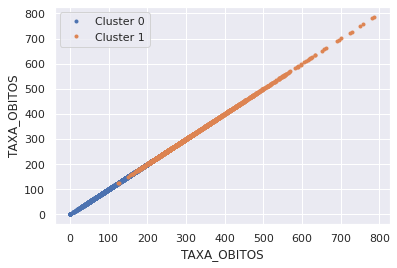

Describing results
===================Cluster 0==================
count    3293.000000
mean      136.149793
std        56.490601
min         0.000000
25%        93.301589
50%       139.535882
75%       179.639851
max       259.099165
Name: TAXA_OBITOS, dtype: float64


count     3293.000000
mean      7570.726493
std       3461.162811
min        161.516098
25%       5084.644015
50%       7283.109597
75%       9707.971586
max      24254.215305
Name: TAXA_CASOS, dtype: float64


count    3293.000000
mean        2.197263
std         1.839106
min         0.000000
25%         1.265823
50%         1.850813
75%         2.628449
max        46.666667
Name: TAXA_LETALIDADE, dtype: float64


===================Cluster 1==================
count    2272.000000
mean      318.414322
std        86.683196
min       123.051682
25%       256.833678
50%       302.052390
75%       361.393284
max       786.672837
Name: TAXA_OBITOS, dtype: float64


count     2272.000000
mean     12910.558288
std       4155.5

In [98]:
show_results(None, centers, u, fpc, df_consequent, scaler_antecedents, df_analysis)

In [99]:
df_u = pd.DataFrame(u).T
df_u.columns = ['GRUPO_MENOS_IMPACTADOS', 'GRUPO_MAIS_IMPACTADOS']
df_u.describe()
df_u['GRUPO'] = 'Impacto intermediário'

In [100]:
df_u.loc[df_u.GRUPO_MENOS_IMPACTADOS >= 0.55, 'GRUPO'] = 'Menos impactados'
df_u.loc[df_u.GRUPO_MAIS_IMPACTADOS >= 0.55, 'GRUPO'] = 'Mais impactados'
df_analise_agrupamentos['AGRUPAMENTO_IMPACTOS'] = df_u.GRUPO

In [184]:
df_analise_agrupamentos['HIERARQUIA_URBANA_AGRUPADA'] = None
df_analise_agrupamentos.loc[
    df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO == 1, 'HIERARQUIA_URBANA_AGRUPADA'] = 'Centro local'
df_analise_agrupamentos.loc[
    (df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 2) &
    (df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO <= 3), 'HIERARQUIA_URBANA_AGRUPADA'] = 'Centro de zona'
df_analise_agrupamentos.loc[
    (df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 4) &
    (df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO <= 5), 'HIERARQUIA_URBANA_AGRUPADA'] = 'Centro sub-regional'
df_analise_agrupamentos.loc[
    (df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 6) &
    (df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO <= 8), 'HIERARQUIA_URBANA_AGRUPADA'] = 'Capital regional'
df_analise_agrupamentos.loc[
    (df_analise_agrupamentos.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 9) , 'HIERARQUIA_URBANA_AGRUPADA'] = 'Metrópole'

In [209]:
def create_dataframe_hierarquia_urbana_classe(agrupamento, classes):
    df_base = df_analise_agrupamentos.groupby(['HIERARQUIA_URBANA_AGRUPADA', agrupamento]).count()[['MUNICIPIO']]
    df_base.columns = ['TOTAL']
    df_hierarquia_total = df_base.groupby('HIERARQUIA_URBANA_AGRUPADA').sum()
    df_hierarquia_total.columns = ['TOTAL_MUNICIPIOS_HIERARQUIA']
    df_base = pd.merge(df_base, df_hierarquia_total, how='left', left_index=True, right_index=True)
    df_base = df_base.reset_index()
    df_base['PERCENTUAL'] = df_base.TOTAL / df_base.TOTAL_MUNICIPIOS_HIERARQUIA * 100
    df_base = df_base.round(2)
    df_base = df_base.drop(columns='TOTAL_MUNICIPIOS_HIERARQUIA')

    df = pd.DataFrame()
    df['HIERARQUIA_URBANA_AGRUPADA'] = df_base['HIERARQUIA_URBANA_AGRUPADA'].unique()

    estatisticas = ['TOTAL', 'PERCENTUAL']
    for classe in classes:
        for estatistica in estatisticas:
            coluna = agrupamento + ' - ' + classe + ' - ' + estatistica
            temp = df_base[df_base[agrupamento] == classe][['HIERARQUIA_URBANA_AGRUPADA', estatistica]]
            temp.columns = ['HIERARQUIA_URBANA_AGRUPADA', coluna]
            df = pd.merge(df, temp, how='left', on='HIERARQUIA_URBANA_AGRUPADA')
    return df

In [214]:
agrupamento = 'AGRUPAMENTO_PERFIL'
classes = ['Desenvolvimento intermediário', 'Mais desenvolvidos', 'Menos desenvolvidos']
df_hierarquia_perfil = create_dataframe_hierarquia_urbana_classe(agrupamento, classes)

agrupamento = 'AGRUPAMENTO_IMPACTOS'
classes = ['Impacto intermediário', 'Mais impactados', 'Menos impactados']
df_hierarquia_impactos = create_dataframe_hierarquia_urbana_classe(agrupamento, classes)

df_hierarquia_classes = pd.merge(df_hierarquia_perfil, df_hierarquia_impactos, how='left', on='HIERARQUIA_URBANA_AGRUPADA')
df_hierarquia_classes = df_hierarquia_classes.fillna(0)
df_hierarquia_classes['AGRUPAMENTO_PERFIL - Menos desenvolvidos - TOTAL'] = \
    df_hierarquia_classes['AGRUPAMENTO_PERFIL - Menos desenvolvidos - TOTAL'].astype(int)

df_hierarquia_classes.HIERARQUIA_URBANA_AGRUPADA = \
    pd.Categorical(df_hierarquia_classes.HIERARQUIA_URBANA_AGRUPADA,
                   ['Metrópole', 'Capital regional', 'Centro sub-regional', 'Centro de zona', 'Centro local'])
df_hierarquia_classes = df_hierarquia_classes.sort_values('HIERARQUIA_URBANA_AGRUPADA')

colunas = df_hierarquia_classes.columns.values
df_hierarquia_classes = df_hierarquia_classes[
    [colunas[0], colunas[5], colunas[6], colunas[1], colunas[2], colunas[3], colunas[4], colunas[11], colunas[12],
     colunas[7], colunas[8], colunas[9], colunas[10]]].copy()

df_hierarquia_classes.to_csv('dados/df_hierarquia_classes.csv', index=False)

In [221]:
df_base[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 4]

MUNICIPIO CODIGO_MUNICIPIO_6 SIGLA_ESTADO  CODIGO_ESTADO  \
1               Ariquemes             110002           RO             11   
3                  Cacoal             110004           RO             11   
9           Guajará-Mirim             110010           RO             11   
10                   Jaru             110011           RO             11   
11              Ji-Paraná             110012           RO             11   
...                   ...                ...          ...            ...   
5554         Três Ranchos             522130           GO             52   
5555             Trindade             522140           GO             52   
5560               Uruaçu             522160           GO             52   
5563  Valparaíso de Goiás             522185           GO             52   
5569             Brasília             530010           DF             53   

            REGIAO      REGIAO_SAUDE  CODIGO_REGIAO_SAUDE  \
1            Norte    VALE DO JAMARI              11001.0   
3            Norte              CAFE              11002.0   
9            Norte    MADEIRA-MAMORE              11004.0   
10           Norte           CENTRAL              11003.0   
11           Norte           CENTRAL              11003.0   
...            ...               ...                  ...   
5554  Centro-Oeste  ESTRADA DE FERRO              52005.0   
5555  Centro-Oeste           CENTRAL              52001.0   
5560  Centro-Oeste     SERRA DA MESA              52014.0   
5563  Centro-Oeste       ENTORNO SUL              52004.0   
5569  Centro-Oeste  DISTRITO FEDERAL              53001.0   

      REGIAO_METROPOLITANA     CASOS  OBITOS  ...  \
1                      0.0   22501.0     494  ...   
3                      0.0   14507.0     302  ...   
9                      0.0    5434.0     223  ...   
10                     0.0    7951.0     178  ...   
11                     0.0   20045.0     592  ...   
...                    ...       ...     ...  ...   
5554                   0.0     245.0      12  ...   
5555                   1.0   13731.0     464  ...   
5560                   0.0    5799.0     145  ...   
5563                   0.0   13582.0     366  ...   
5569                   1.0  468264.0   10007  ...   

     TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA  \
1                                     85.417156   
3                                    157.813728   
9                                    196.129626   
10                                    62.716102   
11                                    96.358235   
...                                         ...   
5554                                 181.650320   
5555                                 276.558207   
5560                                  67.005666   
5563                                  79.702406   
5569                                 338.145730   

     TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA  \
1                                         71.323325   
3                                        120.146254   
9                                        139.559750   
10                                        69.317797   
11                                        72.348708   
...                                             ...   
5554                                     109.110093   
5555                                     128.089290   
5560                                      87.851873   
5563                                      65.510791   
5569                                     198.191338   

      TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA  \
1                                             20.927203              
3                                             12.988784              
9                                             36.366349              
10                                             2.475636              
11                                            10.564192              
...                                    

In [ ]:
df_analise_agrupamentos.groupby(['HIERARQUIA_URBANA_AGRUPADA', 'AGRUPAMENTO_IMPACTOS']).count()[['MUNICIPIO']]

In [102]:
df_analise_agrupamentos.groupby(['AGRUPAMENTO_IMPACTOS']).mean()

PERCENTUAL_POPULACAO_0_A_5_ANOS  \
AGRUPAMENTO_IMPACTOS                                     
Impacto intermediário                         8.682295   
Mais impactados                               8.237553   
Menos impactados                              9.607799   

                       PERCENTUAL_POPULACAO_6_A_14_ANOS  \
AGRUPAMENTO_IMPACTOS                                      
Impacto intermediário                         15.777213   
Mais impactados                               14.881819   
Menos impactados                              17.265345   

                       PERCENTUAL_POPULACAO_15_A_24_ANOS  \
AGRUPAMENTO_IMPACTOS                                       
Impacto intermediário                          17.612172   
Mais impactados                                17.174800   
Menos impactados                               18.357304   

                       PERCENTUAL_POPULACAO_25_A_39_ANOS  \
AGRUPAMENTO_IMPACTOS                                       
Impacto intermediário                          22.647172   
Mais impactados                                22.959809   
Menos impactados                               22.019590   

                       PERCENTUAL_POPULACAO_40_A_59_ANOS  \
AGRUPAMENTO_IMPACTOS                                       
Impacto intermediário                          23.102787   
Mais impactados                                24.195293   
Menos impactados                               20.983207   

                       PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS  \
AGRUPAMENTO_IMPACTOS                                          
Impacto intermediário                             12.178361   
Mais impactados                                   12.550847   
Menos impactados                                  11.766928   

                       PERCENTUAL_POPULACAO_URBANA  \
AGRUPAMENTO_IMPACTOS                                 
Impacto intermediário                    63.583193   
Mais impactados                          74.604953   
Menos impactados                         56.537048   

                       RAZAO_POPULCAO_DOMICILIOS_ESTIMADA  \
AGRUPAMENTO_IMPACTOS                                        
Impacto intermediário                            3.331436   
Mais impactados                                  3.108597   
Menos impactados                                 3.495691   

                       PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO  \
AGRUPAMENTO_IMPACTOS                                                                      
Impacto intermediário                                           1.000084                  
Mais impactados                                                 1.558283                  
Menos impactados                                                0.700149                  

                       PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA  \
AGRUPAMENTO_IMPACTOS                                                            
Impacto intermediário                                          15.897951        
Mais impactados                                                 7.648084        
Menos impactados                                               27.160757        

                       ...  PERCENTUAL_OCUPADOS_COMERCIO  \
AGRUPAMENTO_IMPACTOS   ...                                 
Impacto intermediário  ...                     10.890779   
Mais impactados        ...                     12.129786   
Menos impactados       ...                      9.496361   

                       PERCENTUAL_OCUPADOS_SERVICO  \
AGRUPAMENTO_IMPACTOS                                 
Impacto intermediário                    32.239467   
Mais impactados                          35.308916   
Menos impactados                         30.541955   

                       PERCENTUAL_OCUPADOS_INDUSTRIA  \
AGRUPAMENTO_IMPACTOS                                   
Impacto intermediário                      10.894754   
Mais impactados                       

In [103]:
df_analise_agrupamentos[(df_analise_agrupamentos.HIERARQUIA_URBANA == 'Metrópole Nacional') & (df_analise_agrupamentos.AGRUPAMENTO_IMPACTOS == 'Impacto intermediário')]

PERCENTUAL_POPULACAO_0_A_5_ANOS  PERCENTUAL_POPULACAO_6_A_14_ANOS  \
3203                             8.72                             15.78   
3216                             7.93                             14.72   
3246                             7.15                             13.53   
3248                             7.97                             14.83   

      PERCENTUAL_POPULACAO_15_A_24_ANOS  PERCENTUAL_POPULACAO_25_A_39_ANOS  \
3203                              16.98                              25.47   
3216                              16.43                              23.81   
3246                              15.87                              25.14   
3248                              16.64                              23.94   

      PERCENTUAL_POPULACAO_40_A_59_ANOS  PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS  \
3203                              23.56                                  9.48   
3216                              25.50                                 11.60   
3246                              26.28                                 12.03   
3248                              25.28                                 11.35   

      PERCENTUAL_POPULACAO_URBANA  RAZAO_POPULCAO_DOMICILIOS_ESTIMADA  \
3203                    95.524837                            3.771663   
3216                   100.000000                            3.367943   
3246                    99.927080                            3.032801   
3248                   100.000000                            3.028185   

      PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO  \
3203                                           5.979925                  
3216                                           1.828335                  
3246                                           3.463498                  
3248                                           8.491503                  

      PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA  ...  \
3203                                               6.85       ...   
3216                                               3.27       ...   
3246                                               8.25       ...   
3248                                               4.54       ...   

      TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA  \
3203                                          81.658409           
3216                                          81.658409           
3246                                          81.658409           
3248                                          81.658409           

      NIVEL_HIERARQUIA_URBANA_DISCRETIZADO  PERCENTUAL_VOTOS_BOLSONARO  \
3203                                    10                   66.960736   
3216                                    10                   64.591210   
3246                                    10                   59.113500   
3248                                    10                   63.634660   

       TAXA_CASOS  TAXA_LETALIDADE  TAXA_OBITOS           MUNICIPIO  \
3203  4082.875379         6.978457   284.921703             Itaguaí   
3216  2254.930353        11.231428   253.260876            Mesquita   
3246  5501.461507         4.911028   270.178340         São Gonçalo   
3248  2500.814977        10.360589   259.099165  São João de Meriti   

       HIERARQUIA_URBANA  AGRUPAMENTO_PERFIL   AGRUPAMENTO_IMPACTOS  
3203  Metrópole Nacional  Mais desenvolvidos  Impacto intermediário  
3216  Metrópole Nacional  Mais desenvolvidos  Impacto intermediário  
3246  Metrópole Nacional  Mais desenvolvidos  Impacto intermediário  
3248  Metrópole Nacional  Mais desenvolvidos  Impacto intermediário  

[4 rows x 31 columns]

In [104]:
df_analise_agrupamentos.groupby(['AGRUPAMENTO_PERFIL', 'AGRUPAMENTO_IMPACTOS']).count()['MUNICIPIO']

AGRUPAMENTO_PERFIL             AGRUPAMENTO_IMPACTOS 
Desenvolvimento intermediário  Impacto intermediário      22
                               Mais impactados            96
                               Menos impactados          194
Mais desenvolvidos             Impacto intermediário     135
                               Mais impactados          1763
                               Menos impactados         1073
Menos desenvolvidos            Impacto intermediário      87
                               Mais impactados           291
                               Menos impactados         1904
Name: MUNICIPIO, dtype: int64

In [105]:
df_analise = df_analise_agrupamentos.groupby(['AGRUPAMENTO_PERFIL']).describe()
df_analise = df_analise.reset_index()
df_analise.T

0  \
AGRUPAMENTO_PERFIL                     Desenvolvimento intermediário   
PERCENTUAL_POPULACAO_0_A_5_ANOS count                            312   
                                mean                         8.59538   
                                std                          1.92898   
                                min                              3.4   
...                                                              ...   
TAXA_OBITOS                     min                                0   
                                25%                          136.174   
                                50%                           187.63   
                                75%                          250.197   
                                max                          694.444   

                                                        1                    2  
AGRUPAMENTO_PERFIL                     Mais desenvolvidos  Menos desenvolvidos  
PERCENTUAL_POPULACAO_0_A_5_ANOS count                2971                 2282  
                                mean              7.91813              10.5561  
                                std               1.31693              2.05089  
                                min                  2.81                  6.1  
...                                                   ...                  ...  
TAXA_OBITOS                     min                     0                    0  
                                25%               183.888              86.6225  
                                50%               252.982              132.987  
                                75%               331.373              186.986  
                                max               786.673              691.563  

[217 rows x 3 columns]

In [106]:
def calculate_statistic(clustering_attribute, statistic):
    if statistic == 'Média':
        df_cluster_statistic = df_analise_agrupamentos.groupby([clustering_attribute]).mean()
    elif statistic == 'Desvio padrão':
        df_cluster_statistic = df_analise_agrupamentos.groupby([clustering_attribute]).std()
    df_cluster_statistic = df_cluster_statistic.T
    # df_cluster_statistic.columns = clustering_attribute + ' - ' + df_cluster_statistic.columns.str + ' - ' + statistic
    prefix = [clustering_attribute + ' - ' + statistic for i in range(len(df_cluster_statistic.columns))]
    df_cluster_statistic.columns = df_cluster_statistic.columns.str.cat(prefix, sep=' - ')
    df_cluster_statistic = df_cluster_statistic.reset_index()
    df_cluster_statistic = df_cluster_statistic.rename(columns={'index': 'Atributo'})
    return df_cluster_statistic

In [165]:
df_perfil_media = calculate_statistic('AGRUPAMENTO_PERFIL', 'Média')
df_perfil_media

AGRUPAMENTO_PERFIL                                           Atributo  \
0                                     PERCENTUAL_POPULACAO_0_A_5_ANOS   
1                                    PERCENTUAL_POPULACAO_6_A_14_ANOS   
2                                   PERCENTUAL_POPULACAO_15_A_24_ANOS   
3                                   PERCENTUAL_POPULACAO_25_A_39_ANOS   
4                                   PERCENTUAL_POPULACAO_40_A_59_ANOS   
5                                PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS   
6                                         PERCENTUAL_POPULACAO_URBANA   
7                                  RAZAO_POPULCAO_DOMICILIOS_ESTIMADA   
8                   PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AG...   
9                   PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHE...   
10                                                         IDHM_RENDA   
11                               TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA   
12                  RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_M...   
13                                 PERCENTUAL_TRABALHADORES_INFORMAIS   
14                                      PERCENTUAL_OCUPADOS_SEM_RENDA   
15                                                     TAXA_ATIVIDADE   
16                                   PERCENTUAL_OCUPADOS_AGROPECUARIA   
17                                       PERCENTUAL_OCUPADOS_COMERCIO   
18                                        PERCENTUAL_OCUPADOS_SERVICO   
19                                      PERCENTUAL_OCUPADOS_INDUSTRIA   
20                           PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE   
21                  TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IN...   
22                               NIVEL_HIERARQUIA_URBANA_DISCRETIZADO   
23                                         PERCENTUAL_VOTOS_BOLSONARO   
24                                                         TAXA_CASOS   
25                                                    TAXA_LETALIDADE   
26                                                        TAXA_OBITOS   

AGRUPAMENTO_PERFIL  Desenvolvimento intermediário - AGRUPAMENTO_PERFIL - Média  \
0                                                            8.595385            
1                                                           16.028397            
2                                                           17.329006            
3                                                           21.886282            
4                                                           23.447692            
5                                                           12.713077            
6                                                           51.864484            
7                                                            3.190398            
8                                                            1.223266            
9                                                           12.754199            
10                                                           0.644071            
11                                                         110.952468            
12                                                           9.010417            
13                                                          62.204455            
14                                                          14.359487            
15                                                          57.801987            
16                                                          44.889167            
17                                                           9.264359            
18                                                          28.940096            
19                                                           6.386923            
20                                                           3.972628            
21                                                          64.081636            
22                                                           1.592949

In [ ]:
df_perfil_desvio_padrao = calculate_statistic('AGRUPAMENTO_PERFIL', 'Desvio padrão')
df_impactos_media = calculate_statistic('AGRUPAMENTO_IMPACTOS', 'Média')
df_impactos_desvio_padrao = calculate_statistic('AGRUPAMENTO_IMPACTOS', 'Desvio padrão')
df_statisticas_grupos = pd.merge(df_perfil_media, df_perfil_desvio_padrao, how='left', on='Atributo')
df_statisticas_grupos = pd.merge(df_statisticas_grupos, df_impactos_media, how='left', on='Atributo')
df_statisticas_grupos = pd.merge(df_statisticas_grupos, df_impactos_desvio_padrao, how='left', on='Atributo')
df_statisticas_grupos

atributos_labels = [
    '% população 0 - 5 anos',
    '% população 6 - 14 anos',
    '% população 15 - 24 anos',
    '% população 25 - 39 anos',
    '% população 40 - 59 anos',
    '% população +60 anos',
    '% população urbana',
    'Razão pop. e domicílios',
    '% dom. em aglomerados',
    '% pop. sem banheiro e água',
    'IDHM Renda',
    'Valor percapta B. Família',
    'Razão renda ricos e pobres',
    '% trabalhadores informais',
    '% ocupados sem renda',
    'Taxa de atividade',
    '% ocupados na agropecuária',
    '% ocupados no comércio',
    '% ocupados no serviço',
    '% ocupados na indústria',
    '% pop. com plano de saúde',
    'Taxa de leitos de internação',
    'Nível de hierarquia urbana',
    '% votos em Bolsonaro',
    'Taxa de casos Covid-19',
    'Taxa de letalidade Covid-19',
    'Taxa de óbitos Covid-19']
serie_atributos_labels = pd.Series(atributos_labels)
df_statisticas_grupos.Atributo = serie_atributos_labels
colunas = df_statisticas_grupos.columns.values
df_statisticas_grupos = df_statisticas_grupos[
    ['Atributo', colunas[3], colunas[6], colunas[1], colunas[4], colunas[2], colunas[5], colunas[9], colunas[12],
     colunas[7], colunas[10], colunas[8], colunas[11]]].copy()
df_statisticas_grupos = df_statisticas_grupos[df_statisticas_grupos.Atributo != 'Nível de hierarquia urbana']
df_statisticas_grupos = df_statisticas_grupos.round(2)
df_statisticas_grupos.to_csv('dados/df_statisticas_grupos.csv')

In [206]:
df_statisticas_grupos

Atributo  \
0         % população 0 - 5 anos   
1        % população 6 - 14 anos   
2       % população 15 - 24 anos   
3       % população 25 - 39 anos   
4       % população 40 - 59 anos   
5           % população +60 anos   
6             % população urbana   
7        Razão pop. e domicílios   
8          % dom. em aglomerados   
9     % pop. sem banheiro e água   
10                    IDHM Renda   
11     Valor percapta B. Família   
12    Razão renda ricos e pobres   
13     % trabalhadores informais   
14          % ocupados sem renda   
15             Taxa de atividade   
16    % ocupados na agropecuária   
17        % ocupados no comércio   
18         % ocupados no serviço   
19       % ocupados na indústria   
20     % pop. com plano de saúde   
21  Taxa de leitos de internação   
23          % votos em Bolsonaro   
24        Taxa de casos Covid-19   
25   Taxa de letalidade Covid-19   
26       Taxa de óbitos Covid-19   

    Menos desenvolvidos - AGRUPAMENTO_PERFIL - Média  \
0                                              10.56   
1                                              18.75   
2                                              19.16   
3                                              21.65   
4                                              18.91   
5                                              10.97   
6                                              50.16   
7                                               3.66   
8                                               0.52   
9                                              39.50   
10                                              0.56   
11                                            241.55   
12                                             13.20   
13                                             74.39   
14                                             23.53   
15                                             49.04   
16                                             46.84   
17                                              9.02   
18                                             29.35   
19                                              4.46   
20                                              1.62   
21                                             31.29   
23                                             24.25   
24                                           7756.15   
25                                              2.20   
26                                            143.93   

    Menos desenvolvidos - AGRUPAMENTO_PERFIL - Desvio padrão  \
0                                                2.05          
1                                                2.41          
2                                                1.46          
3                                                1.59          
4                                                2.60          
5                                                2.77          
6                                               16.93          
7                                                0.66          
8                                                3.19          
9                                               19.79          
10                                               0.04          
11                                              90.90          
12                                               7.79          
13                                               9.45          
14                                              11.21          
15                                               7.55          
16                                              12.29          
17                                               3.75          
18                                               6.95          
19                                               4.03          
20                                               5.00          
21                                              19.58          
23                                              13.04          
24

In [108]:
colunas = df_statisticas_grupos.columns.values
for i in range(len(colunas)):
    print(str(i) + ' - ' + colunas[i])

0 - Atributo
1 - Menos desenvolvidos - AGRUPAMENTO_PERFIL - Média
2 - Menos desenvolvidos - AGRUPAMENTO_PERFIL - Desvio padrão
3 - Desenvolvimento intermediário - AGRUPAMENTO_PERFIL - Média
4 - Desenvolvimento intermediário - AGRUPAMENTO_PERFIL - Desvio padrão
5 - Mais desenvolvidos - AGRUPAMENTO_PERFIL - Média
6 - Mais desenvolvidos - AGRUPAMENTO_PERFIL - Desvio padrão
7 - Menos impactados - AGRUPAMENTO_IMPACTOS - Média
8 - Menos impactados - AGRUPAMENTO_IMPACTOS - Desvio padrão
9 - Impacto intermediário - AGRUPAMENTO_IMPACTOS - Média
10 - Impacto intermediário - AGRUPAMENTO_IMPACTOS - Desvio padrão
11 - Mais impactados - AGRUPAMENTO_IMPACTOS - Média
12 - Mais impactados - AGRUPAMENTO_IMPACTOS - Desvio padrão


In [109]:
sns.set(font_scale=1)
palette = 'Paired'

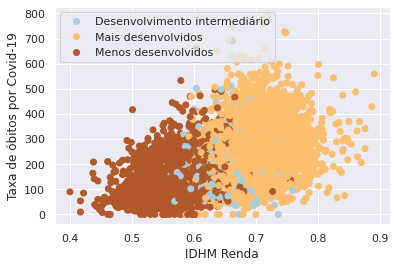

In [110]:
labels, index = np.unique(df_analise_agrupamentos.AGRUPAMENTO_PERFIL, return_inverse=True)
grafico = plt.scatter(x=df_analise_agrupamentos.IDHM_RENDA, y=df_analise_agrupamentos.TAXA_OBITOS, cmap=palette, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM Renda')
plt.ylabel('Taxa de óbitos por Covid-19')
plt.savefig('images/renda_obitos_perfil.pdf', bbox_inches="tight")
plt.show()

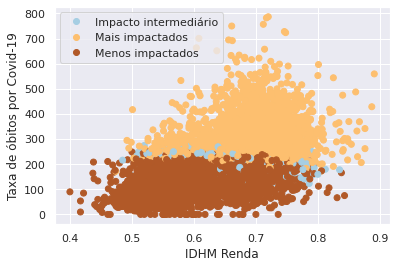

In [111]:
labels, index = np.unique(df_analise_agrupamentos.AGRUPAMENTO_IMPACTOS, return_inverse=True)
grafico = plt.scatter(x=df_analise_agrupamentos.IDHM_RENDA, y=df_analise_agrupamentos.TAXA_OBITOS, cmap=palette, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM Renda')
plt.ylabel('Taxa de óbitos por Covid-19')
plt.savefig('images/renda_obitos_impactos.pdf', bbox_inches="tight")
plt.show()

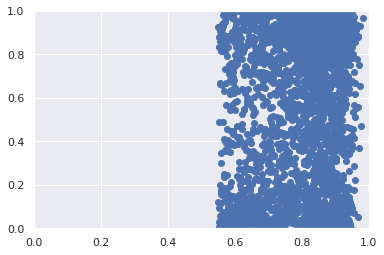

In [117]:
grafico = plt.scatter(x=df_u_2[df_u_2.GRUPO == 'Mais desenvolvidos'].GRUPO_MAIS_DESENVOLVIDOS,
                      y=df_u[df_u_2.GRUPO == 'Mais desenvolvidos'].GRUPO_MAIS_IMPACTADOS)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

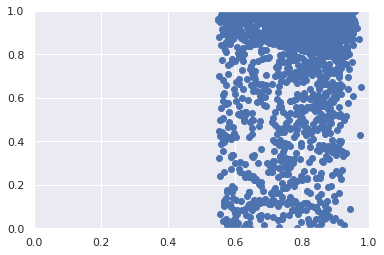

In [119]:
grafico = plt.scatter(x=df_u_2[df_u_2.GRUPO == 'Menos desenvolvidos'].GRUPO_MENOS_DESENVOLVIDOS,
                      y=df_u[df_u_2.GRUPO == 'Menos desenvolvidos'].GRUPO_MENOS_IMPACTADOS)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

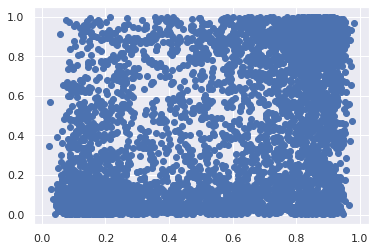

In [118]:
grafico = plt.scatter(x=df_u_2.GRUPO_MAIS_DESENVOLVIDOS,
                      y=df_u.GRUPO_MAIS_IMPACTADOS)
plt.show()

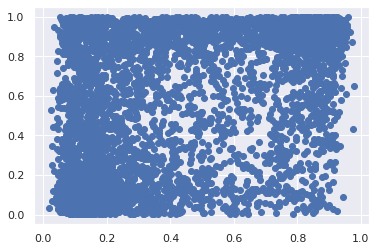

In [120]:
grafico = plt.scatter(x=df_u_2.GRUPO_MENOS_DESENVOLVIDOS,
                      y=df_u.GRUPO_MENOS_IMPACTADOS)
plt.show()

In [130]:
stats.pearsonr(df_u_2[df_u_2.GRUPO == 'Menos desenvolvidos'].GRUPO_MENOS_DESENVOLVIDOS, df_u[df_u_2.GRUPO == 'Menos desenvolvidos'].GRUPO_MENOS_IMPACTADOS)

(0.2626398124745345, 2.5970455664023965e-37)

In [129]:
stats.pearsonr(df_u_2.GRUPO_MAIS_DESENVOLVIDOS, df_u.GRUPO_MAIS_IMPACTADOS)

(0.5418720307884657, 0.0)

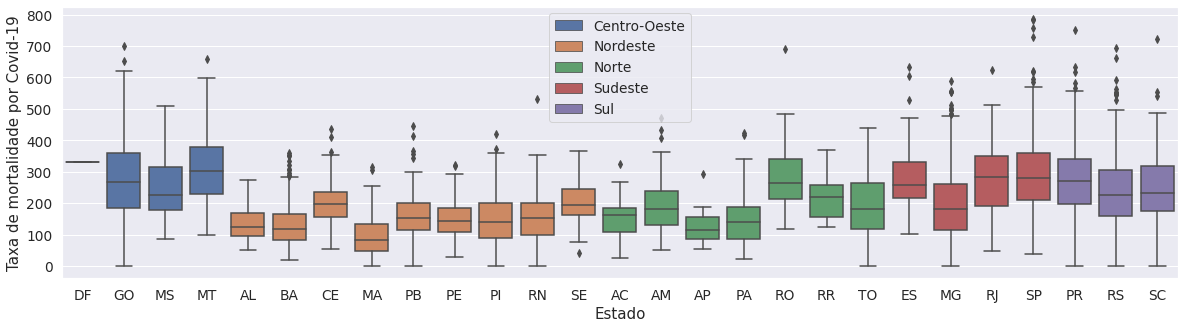

In [313]:
df_base = df_base.sort_values(['REGIAO', 'SIGLA_ESTADO'])
sns.set(font_scale=1.25)
fig = plt.figure(figsize=(20,5))
ax = sns.boxplot(x="SIGLA_ESTADO", y="TAXA_OBITOS", data=df_base, dodge=False, hue='REGIAO')
ax.legend(handles=handles[1:], labels=labels[1:])
plt.xlabel('Estado')
plt.ylabel('Taxa de mortalidade por Covid-19')
plt.savefig('images/estado_mortalidade.pdf', bbox_inches="tight")
plt.show()